Here are a few thoughts for research questions:

1.) How much of a performance benefit does examining PI by POSGRU provide?
2.) How much of a performance benefit does adding meters gained into the analysis add?
3.) What does the explained variance and decision tree analysis tell us about POSGRU vs team-level key PI

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.base import clone
from itertools import combinations
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import sys
from scipy.stats import ttest_ind, zscore
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import copy
import json
import string

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
plt.rcParams['axes.facecolor'] = 'white'

Michael Schlitzer

Primary References: 

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235


**Project Description:**

The goal of this project is to see if I can predict the outcome (home win / away win) of Australian Football League games by looking at the difference between the two teams' season-long performance in a number of standard AFL Performance Indicators (PI). Fahey-Gilmour, et.al. use a variety of categorical data points with regards to the individual matches (distance traveled, game location, etc.) and aggregate measures of team ladder position. They do not consider individual "contests" the same way that I am in this research.
Therefore, the goal of this effort is to use that comparative PI data in both optimized single perceptron machine learning algorithms and optimized multi-perceptron Neural Networks to see if I can outperform the benchmarks of 73.3% accuracy on the test sample set by Fahey-Gilmour, et.al.


**Learning Objective:** 

The primary objective of this project is to apply the techniques of choosing algorithms and parameters to a real-world dataset, one that has not been “worked out” in advance. This includes the optimization of the complex TensorFlow hyperparameters, including regularization and neural network parameters. By working on this data set, which holds personal interest for me, I am able to better understand the meaning and importance of each variable and parameter in the code.

**Preparatory Files:**

The data has required considerable reshaping and merging across multiple web sites and web pages.  The biggest challenge
was to reconfigure the data from one Performance Indicator all rounds in columns to all Performance Indicators as columns
and rounds as the index for each team for each season.  It was a challenge - one that was too daunting for me just a few months ago, but I was able to create nested dictionaries and export the dictionaries as a JSON file.  I obviously know the
structure of the JSON file, so reversing it to create a functional dataframe just takes a few lines of code.

Without doing any machine learning at all, getting to this point has been a point of pride for me.

In [2]:
teams = ['Adelaide', 'Brisbane', 'Carlton', 'Collingwood', 'Essendon', 'Fremantle', 'Geelong', 'Gold Coast', 
         'GWS', 'Hawthorn', 'Melbourne', 'North Melbourne', 'Port Adelaide', 'Richmond',
        'St. Kilda', 'Sydney', 'West Coast', 'Western Bulldogs']

years = [2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020]

webpath = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/AFL_Season_Team_PI_Data_amg.json'
# test_path = 'C:/Users/Michael/Documents/UMBC/DataScience 606/AFL_Season_Team_PI_Data.json'
# test_path2 = 'C:/Users/Michael/Documents/UMBC/DataScience 606/AFL_Season_Team_PI_Data_amg.json'
AFL_Season_Team_PI_Data = pd.read_json(webpath)

new_season_team_PI = []
for y, year in zip(years, range(len(years))):
    new_team_round_PI = []
    for t, team in zip(teams, range(len(teams))):
        new_round_PI = []
        
        for rnd in range(len(AFL_Season_Team_PI_Data[team][year])):
        
            new_rtc_df = pd.DataFrame.from_dict(AFL_Season_Team_PI_Data[team][year][rnd])
        
            new_round_PI.append(new_rtc_df)
        new_team_round_PI.append(new_round_PI)
    new_season_team_PI.append(new_team_round_PI)
    
master_seasonPI_df = pd.DataFrame()

for s in range(9):
    for t in range(18):
        master_seasonPI_df = master_seasonPI_df.append(new_season_team_PI[s][t])

        
master_seasonPI_df.reset_index(inplace = True)
master_seasonPI_df.rename(columns={'index': 'Round'}, inplace = True)
master_seasonPI_df['Round'] = master_seasonPI_df['Round'].str.replace('R','round')
master_seasonPI_df.fillna(value = 0, inplace = True)

with_ruck = master_seasonPI_df[master_seasonPI_df['R-HO'] != 0]

with_ruck[['D-HO', 'F-HO', 'M-HO', 'R-HO']]

with_ruck = with_ruck[with_ruck.loc[:] !=0].dropna(thresh = 4)

no_ruck = master_seasonPI_df[master_seasonPI_df['R-HO'] == 0]

no_ruck[['D-HO', 'F-HO', 'M-HO', 'R-HO']]

no_ruck = no_ruck[no_ruck.loc[:] !=0].dropna(thresh = 4)

baseline_with_ruck = with_ruck[['Season', 'D-HO', 'F-HO', 'M-HO', 'R-HO']].groupby('Season').mean()
baseline_without_ruck = no_ruck[['Season', 'D-HO', 'F-HO', 'M-HO', 'R-HO']].groupby('Season').mean()

test_df = copy.deepcopy(master_seasonPI_df)

new_ruck_PI = pd.DataFrame(columns = ['R-HO', 'F-HO', 'D-HO', 'R-Age', 'R-Height', 'R-Weight'])

# This gets me the indices where there are no ruck stats
select_indices = list(np.where(test_df["R-HO"] == 0)[0])

for index in select_indices:
    yiq = test_df.iloc[index]['Season']
    
    if test_df.iloc[index][3:-3].sum() != 0:
    
        if test_df.iloc[index]['D-HO'] > 0 and test_df.iloc[index]['F-HO'] > 0:
            
            if test_df.iloc[index]['D-HO'] > baseline_with_ruck.loc[yiq]['D-HO'] and test_df.iloc[index]['F-HO'] > baseline_with_ruck.loc[yiq]['F-HO']:
    
                new_rho = (test_df.iloc[index]['D-HO'] - baseline_with_ruck.loc[yiq]['D-HO']) + (test_df.iloc[index]['F-HO'] - baseline_with_ruck.loc[yiq]['F-HO'])
                new_fho = baseline_with_ruck.loc[yiq]['F-HO']
                new_dho = baseline_with_ruck.loc[yiq]['D-HO']
                new_rage = (test_df.iloc[index]['D-Age'] + test_df.iloc[index]['F-Age']) / 2
                new_rh = (test_df.iloc[index]['D-Height'] + test_df.iloc[index]['F-Height']) / 2
                new_rw = (test_df.iloc[index]['D-Weight'] + test_df.iloc[index]['F-Weight']) / 2
            
            else:
                
                new_rho = 2.0
                new_fho = test_df.iloc[index]['F-HO'] - 1.0
                new_dho = test_df.iloc[index]['D-HO'] - 1.0
                new_rage = (test_df.iloc[index]['D-Age'] + test_df.iloc[index]['F-Age']) / 2
                new_rh = (test_df.iloc[index]['D-Height'] + test_df.iloc[index]['F-Height']) / 2
                new_rw = (test_df.iloc[index]['D-Weight'] + test_df.iloc[index]['F-Weight']) / 2

        elif test_df.iloc[index]['D-HO'] > 0:
            
            if test_df.iloc[index]['D-HO'] > baseline_with_ruck.loc[yiq]['D-HO']:

                new_rho = (test_df.iloc[index]['D-HO'] - baseline_with_ruck.loc[yiq]['D-HO'])
                new_fho = test_df.iloc[index]['F-HO']
                new_dho = baseline_with_ruck.loc[yiq]['D-HO']
                new_rage = test_df.iloc[index]['D-Age']
                new_rh = test_df.iloc[index]['D-Height']
                new_rw = test_df.iloc[index]['D-Weight']
                
            else:
                
                new_rho = 1.0
                new_fho = test_df.iloc[index]['F-HO']
                new_dho = test_df.iloc[index]['D-HO'] - 1.0
                new_rage = test_df.iloc[index]['D-Age']
                new_rh = test_df.iloc[index]['D-Height']
                new_rw = test_df.iloc[index]['D-Weight']

        elif test_df.iloc[index]['F-HO'] > 0:
            
            if test_df.iloc[index]['F-HO'] > baseline_with_ruck.loc[yiq]['F-HO']:

                new_rho = (test_df.iloc[index]['F-HO'] - baseline_with_ruck.loc[yiq]['F-HO'])
                new_fho = baseline_with_ruck.loc[yiq]['F-HO']
                new_dho = test_df.iloc[index]['D-HO']
                new_rage = test_df.iloc[index]['F-Age']
                new_rh = test_df.iloc[index]['F-Height']
                new_rw = test_df.iloc[index]['F-Weight']
                
            else:
                
                new_rho = 1.0
                new_fho = test_df.iloc[index]['F-HO'] - 1.0
                new_dho = test_df.iloc[index]['D-HO']
                new_rage = test_df.iloc[index]['F-Age']
                new_rh = test_df.iloc[index]['F-Height']
                new_rw = test_df.iloc[index]['F-Weight']

        new_list = [new_rho, new_fho, new_dho, new_rage, new_rh, new_rw]

        new_ruck_PI.loc[index] = new_list
    else:
        pass

nri = new_ruck_PI.index.tolist()
nrc = new_ruck_PI.columns

# new_ruck_PI.loc[59, 'F-HO'] # This is the pattern to change individual cells in a df
# df.loc[index, column_name] = the new value

for i in nri:
    for c in nrc:
        
        master_seasonPI_df.loc[i, c] = new_ruck_PI.loc[i, c]

    
index_names2 = master_seasonPI_df.loc[(master_seasonPI_df['Round'].isin(['round19', 'round20', 'round21', 'round22', 'round23'])) & (master_seasonPI_df['Season'] == '2020')].index
master_seasonPI_df = master_seasonPI_df.drop(index_names2)
master_seasonPI_df.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
master_seasonPI_df['Season'] = pd.to_numeric(master_seasonPI_df['Season'])

master_seasonPI_df

Round              Team  Season   D-DI   D-KI  D-MK   D-HB  D-GL  \
0      round1          Adelaide    2012  332.0  188.0  94.0  144.0   4.0   
1      round2          Adelaide    2012  322.0  194.0  90.0  128.0   0.0   
2      round3          Adelaide    2012  240.0  136.0  36.0  104.0   6.0   
3      round4          Adelaide    2012  332.0  230.0  40.0  102.0   4.0   
4      round5          Adelaide    2012  226.0  126.0  52.0  100.0   0.0   
...       ...               ...     ...    ...    ...   ...    ...   ...   
3552  round13  Western Bulldogs    2020  111.0   66.0  38.0   46.0   1.0   
3553  round14  Western Bulldogs    2020   86.0   54.0  31.0   32.0   4.0   
3554  round16  Western Bulldogs    2020   73.0   39.0  31.0   35.0   1.0   
3555  round17  Western Bulldogs    2020  150.0   90.0  44.0   62.0   5.0   
3556  round18  Western Bulldogs    2020  104.0   70.0  26.0   33.0   2.0   

      D-BH  D-HO  ...  R-UP  R-CM  R-MI  R-1%  R-BO   R-AMG  R-GA  R-Height  \
0      2.0   2.0  ...  44.0   6.0   6.0  14.0   0.0    0.00   2.0     202.0   
1      6.0   4.0  ...  28.0   8.0   0.0  10.0   2.0    0.00   0.0     202.0   
2      8.0   0.0  ...  30.0  10.0  12.0   6.0   0.0    0.00   8.0     202.0   
3     14.0   2.0  ...  30.0   2.0  10.0  14.0   0.0    0.00   0.0     202.0   
4      4.0   2.0  ...  32.0   4.0   6.0   2.0   0.0    0.00   2.0     202.0   
...    ...   ...  ...   ...   ...   ...   ...   ...     ...   ...       ...   
3552   0.0   0.0  ...  14.0   1.0   1.0   2.0   0.0  392.61   0.0     201.5   
3553   2.0   0.0  ...  24.0   1.0   0.0   7.0   0.0  392.61   0.0     201.5   
3554   3.0   0.0  ...  17.0   4.0   0.0   8.0   0.0  392.61   0.0     201.5   
3555   4.0   0.0  ...  22.0   0.0   1.0   6.0   0.0  392.61   0.0     201.5   
3556   2.0   0.0  ...  18.0   2.0   2.0   7.0   1.0  392.61   1.0     201.5   

      R-Weight  R-Age  
0        104.5   24.5  
1        104.5   24.5  
2        104.5   24.5  
3        104.5   24.5  
4        104.5   24.5  
...        ...    ...  
3552      91.0   21.5  
3553      91.0   21.5  
3554      91.0   21.5  
3555      91.0   21.5  
3556      91.0   21.5  

[3472 rows x 103 columns]

# Cut the main df up into multiple experimental dfs to answer these exploratory questions (the data will have to be cut again after merger with the fixture schedule):

1.) Drop AMG from the 2012-2020 sample    2.) Create a 2015 - 2020 sample without AMG    3.) Drop 2012-2014 from the sample to focus on 2015 - 2020 with AMG.  This will let us test the impact of AMG as a predictor.

In [3]:
# The default df with no Average Meters Gained

drop_amg = [g for g in master_seasonPI_df if g.endswith(('-AMG'))]
df1 = master_seasonPI_df.drop(columns = drop_amg)

# df2 is 2015 - 2020 WITH AMG

df2 = master_seasonPI_df[master_seasonPI_df['Season'] > 2014]

# df3 is 2015 WITHOUT AMG

df3 = df1[df1['Season'] > 2014]

# Taking an exploratory look at the data before I carve it up

In [4]:
# master_seasonPI_df_section = master_seasonPI_df.iloc[:-5]

# Here maybe I want to break it up into seasons with AMG and seasons without, or take out AMG.

season12 = master_seasonPI_df[master_seasonPI_df['Season'] == 2012]
season13 = master_seasonPI_df[master_seasonPI_df['Season'] == 2013]
season14 = master_seasonPI_df[master_seasonPI_df['Season'] == 2014]
season15 = master_seasonPI_df[master_seasonPI_df['Season'] == 2015]
season16 = master_seasonPI_df[master_seasonPI_df['Season'] == 2016]
season17 = master_seasonPI_df[master_seasonPI_df['Season'] == 2017]
season18 = master_seasonPI_df[master_seasonPI_df['Season'] == 2018]
season19 = master_seasonPI_df[master_seasonPI_df['Season'] == 2019]
season20 = master_seasonPI_df[master_seasonPI_df['Season'] == 2020]

# index_names = season20[season20['Round'].isin(['round19', 'round20', 'round21', 'round22', 'round23'])].index
# season20 = season20.drop(index_names)

<Figure size 576x504 with 0 Axes>

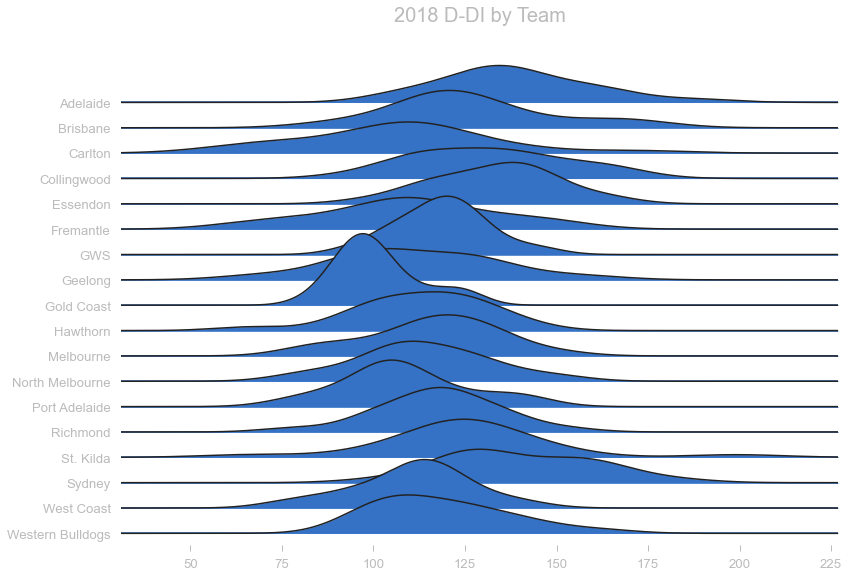

In [5]:
# Let's see if I can do a ridgeline plot here.

from joypy import joyplot

plt.figure()
# plt.set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'white'
joyplot(data=season18[['Team', 'D-DI']], by='Team', figsize=(12, 8))
plt.title('2018 D-DI by Team', fontsize=20);
plt.show();

# This is nice and interesting, but it really doesn't show a very different view than the boxplot below.

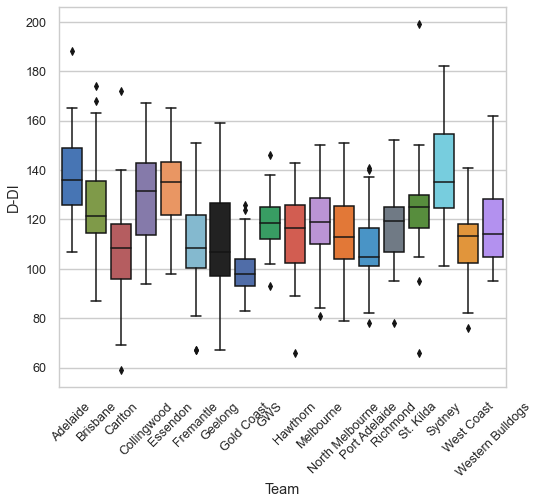

In [6]:
# season20
sns.set_style("whitegrid")
sns.boxplot(x = 'Team', y = 'D-DI', data = season18)
plt.xticks(rotation = 45);

In [7]:
# There is a ton of variability across the teams.  There's only a few times where one team's range is completely
# out of the bounds of another team, but there is still a lot of variability.  That's not a bad thing.

Now THIS is awesome.  With two lines I now have the season descriptions and the TEAM descriptions by season, so
I have an idea of how the teams are performing over time in relation to the rest of the league and to each other.

This is information that I need to operationalize, especially when I'm looking to make forward-looking predictions.

I need this variability to try and and answer the predictive questions - given this opponent with these conditions and this
spread of variability in performance, who is more likely to win?

I feel as if this has the potential to be a big deal.

# Checking distribution

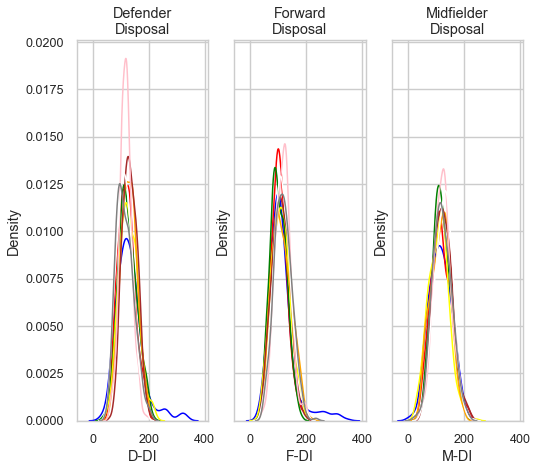

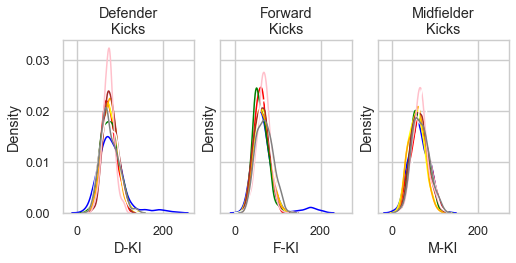

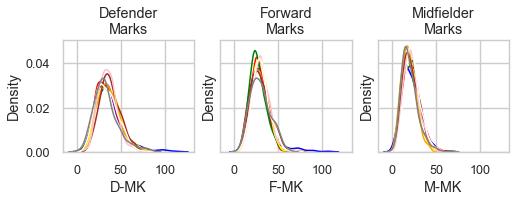

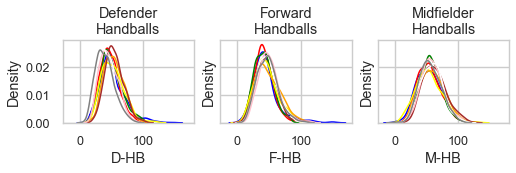

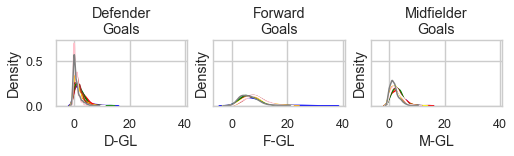

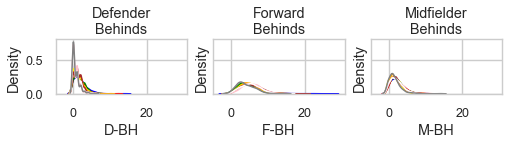

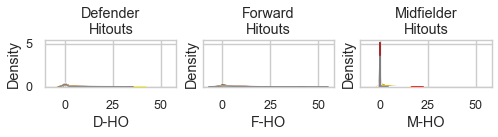

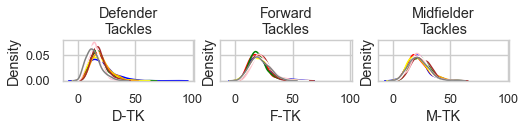

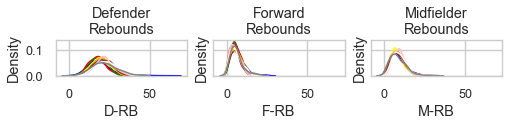

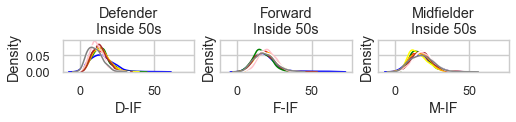

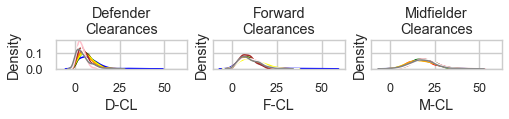

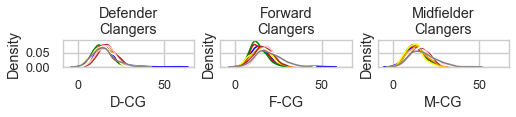

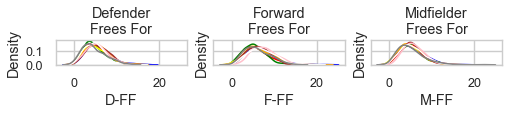

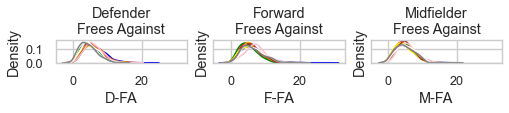

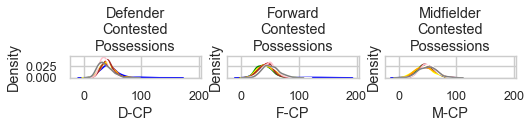

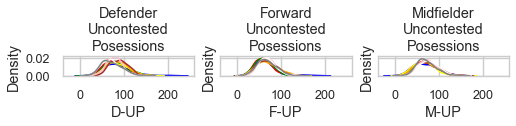

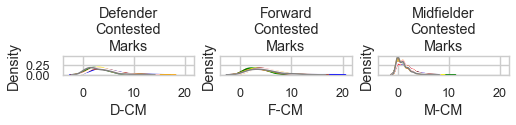

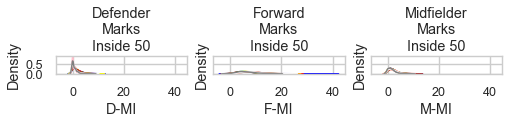

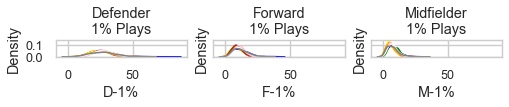

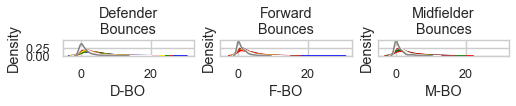

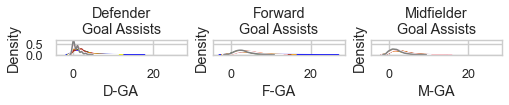

In [8]:
# So let's take a look at one stat over the entire sample size and see what that does
# This is pretty good.  Make it white to make it easier to read / see and then break it into years to look for
# variability and then just loop it through for every PI.

# Another way to look at this would be to compare each PI by each pos group within a season.

# There are a couple of really useful ways to stripe this data I think.
# %config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
# fig1 = plt.figure(figsize = (6,4))
# plt.gca().set_facecolor("white")

seasonlist = [season12, season13, season14, season15, season16, season17, season18, season19, season20]

colorlist = ['blue', 'red', 'green', 'yellow', 'orange', 'brown', 'pink', 'white', 'gray']

new_column_basis = ['DI', 'KI', 'MK', 'HB', 'GL', 'BH', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP', 
                    'CM', 'MI', '1%', 'BO', 'GA']

header_titles = ['Disposal', 'Kicks', 'Marks', 'Handballs', 'Goals', 'Behinds', 'Hitouts', 'Tackles', 'Rebounds',
                'Inside 50s', 'Clearances', 'Clangers', 'Frees For', 'Frees Against', 'Contested\nPossessions',
                'Uncontested\nPosessions', 'Contested\nMarks', 'Marks\nInside 50', '1% Plays', 'Bounces', 
                 'Goal Assists']

for ncb, ht in zip(enumerate(new_column_basis), header_titles):
    
    ax1 = plt.subplot(ncb[0]+1,3,1)
    plt.gca().set_facecolor("white")
    for season, svet in zip(seasonlist, colorlist):
        sns.kdeplot(season['D-'+ncb[1]],  color = svet).set_title('Defender\n'+ht)

    ax2 = plt.subplot(ncb[0]+1,3,2, sharey = ax1, sharex = ax1)
    plt.gca().set_facecolor("white")
    for season, svet in zip(seasonlist, colorlist):
        sns.kdeplot(season['F-'+ncb[1]],  color = svet).set_title('Forward\n'+ht)
    plt.setp(ax2.get_yticklabels(), visible=False);

    ax3 = plt.subplot(ncb[0]+1,3,3, sharey = ax1, sharex = ax1)
    plt.gca().set_facecolor("white")
    for season, svet in zip(seasonlist, colorlist):
        sns.kdeplot(season['M-'+ncb[1]],  color = svet).set_title('Midfielder\n'+ht)
    plt.setp(ax3.get_yticklabels(), visible=False);

#     ax4 = plt.subplot(ncb[0]+1,4,4, sharey = ax1, sharex = ax1)
#     plt.gca().set_facecolor("white")
#     for season, svet in zip(seasonlist, colorlist):
#         sns.kdeplot(season['R-'+ncb[1]],  color = svet).set_title('Ruck\n'+ht)
#     plt.setp(ax4.get_yticklabels(), visible=False)
    
    plt.show();

# Merging game data with the season-level position group PI

Now that I have all of the matches broken out by season and team, both home and away, and all of the PI by season / team / position group, I can merge the two together so that everything is aligned.  This alignment is the key step that makes the rest of the analysis possible.

First I merge the Home df with the PI data on both Club and Season so that I get the right player group PI.  These become home_list and away_list, respectively.

In [9]:
hurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Home12-20.csv'
aurl = 'https://raw.githubusercontent.com/michaelschlitzer/2019_Footy_Player_Dictionary/master/Away12-20.csv'

home = pd.read_csv(hurl)
away = pd.read_csv(aurl)

# home.Year = home.Year.astype(str) # I have made master_seasonPI_df an int dtype.
# away.Year = away.Year.astype(str)

home.replace({'Greater Western Sydney': 'GWS'}, inplace = True)
away.replace({'Greater Western Sydney': 'GWS'}, inplace = True)

home['Game'] = home['Game'].str.lstrip(string.digits)
away['Game'] = away['Game'].str.lstrip(string.digits)

home.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)
away.sort_values(by = ['Year', 'Round', 'Game'], axis = 0, ignore_index = True, inplace = True)

home_list = pd.merge(home, master_seasonPI_df, how = 'left', left_on = ['Year', 'Home', 'Round'], 
                     right_on = ['Season', 'Team', 'Round'])
away_list = pd.merge(away, master_seasonPI_df, how = 'left', left_on = ['Year', 'Away', 'Round'], 
                     right_on = ['Season', 'Team', 'Round'])

away_list.drop(['Team', 'Season'], axis = 1, inplace = True)
home_list.drop(['Team', 'Season'], axis = 1, inplace = True)

What I’m really interested in is the difference between the PI for each team in a particular contest: which team “won” a particular PI.  All PI are calculated from the Home team’s perspective.  Therefore, a positive number indicates that the home team “won” and a negative number indicates that the away team “won” that PI.  The difference in the final score is, of course, the ultimate arbiter of the winner or loser, so I use that to create my target class variable.

I use this data to create some categorical variables that I think might be interesting: interstate games, where travel could be a factor; clash games, where teams that share a stadium play each other; and Relative Ladder Position (RLP) to indicate which team is better than the other team.  I created my own one-hot encoding for each binary categorical variable.

I do not create any rolling “momentum” features (performance over the last x games).  While this is prevalent on AFL’s website, and mentioned in the Young, et.al. paper, I did not create that feature.  Obviously, it would start each year – last year’s performance is irrelevant to Round 1 – and I felt that having low numbers at the start of each season might muddy the waters even further.

In [10]:
# This separates the merged descriptive data from the PIs

home_list_stats = home_list.iloc[:,9:]
away_list_stats = away_list.iloc[:,8:]

home_list_info = home_list.iloc[:,:9]
away_list_info = away_list.iloc[:,:8]


# This is the key of the analysis, I subtract the away PI from the home PI
home_away_net = home_list_stats.subtract(away_list_stats, fill_value = None)


# Here I merge the info for each match together and create the Relative Ladder Position (RLP) column
# and manually set up categorical variables, rather than using one hot encoding
info = home_list_info.merge(away_list_info, how = 'left', left_index = True, right_index = True)

info['RLP'] = info['LP-H'] - info['LP-A']

condition1 = info['Venue'] == info['Home Field-H'] 
condition2 = info['Home Field-H'] == info['Home Field-A']

condition3 = info['Venue'] != info['Home Field-H'] 
condition4 = info['Home Field-H'] != info['Home Field-A']


(info['Net Score'], info['Intrastate'], info['Same / Neutral Venue']) = \
((info['Home Score'] - info['Away Score']), np.where(info['Home State'] == info['Away State'], 0, 1), 
 np.where((condition1 & condition2) | (condition3 & condition4), 1, 0))

info['Clash'] = np.where((info['Intrastate'] == 0) & (info['Same / Neutral Venue'] == 1), 1, 0)
# info['Winner'] = np.where(info['Net Score'] >0, 'Home', 'Away')

###

conditions = [info['Net Score'] > 0, info['Net Score'] < 0, info['Net Score'] == 0]
choices = ['Home', 'Away', 'Draw']

info['Winner'] = np.select(conditions, choices, default = np.nan)

###

# Here I reconstruct and finalize the information portion of the dataframe, merge it with the PI, and then reorder it.

info = info[['Year_x','Home', 'Away', 'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP','Net Score', 'Winner']]
info = info.rename(columns = {'Year_x': 'Season'})

home_away_net_complete = home_away_net.join(info)

home_away_net_complete['Round'] = home_list_info['Round']
home_away_net_complete['Game'] = home_list_info['Game']

col = home_away_net_complete.pop('Round')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Game')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Season')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Away')
home_away_net_complete.insert(0, col.name, col)
col = home_away_net_complete.pop('Home')
home_away_net_complete.insert(0, col.name, col)

In [11]:
# specials = home_away_net_complete.columns[101:]

In [12]:
d_cols = [col for col in master_seasonPI_df.columns if col.startswith('D-')]
f_cols = [col for col in master_seasonPI_df.columns if col.startswith('F-')]
m_cols = [col for col in master_seasonPI_df.columns if col.startswith('M-')]
r_cols = [col for col in master_seasonPI_df.columns if col.startswith('R-')]

hd = home_list_stats[d_cols]
af = away_list_stats[f_cols]
hf = home_list_stats[f_cols]
ad = away_list_stats[d_cols]
new_computed_column_basis = ['DI', 'KI', 'MK', 'HB', 'GL', 'BH', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP',
                             'UP', 'CM', 'MI', '1%', 'BO', 'AMG', 'GA', 'Height', 'Weight', 'Age']

new_posgru = [hd, af, hf, ad]

for npg in new_posgru:
    npg.columns = new_computed_column_basis

hdaf = hd - af
hfad = hf - ad
####
pos_prefixes = ['HDAF', 'HFAD']
            
new_delta_headers = []
for pos in pos_prefixes:
    for stat in new_computed_column_basis:
        new_col_head = pos+'-'+stat
        new_delta_headers.append(new_col_head)
hdaf_headers = new_delta_headers[:25]
hfad_headers = new_delta_headers[25:]

hdaf.columns = hdaf_headers
hfad.columns = hfad_headers

hdaf_avmg = home_list_stats['D-AMG'] - away_list_stats['F-AMG']
hfad_avmg = home_list_stats['F-AMG'] - away_list_stats['D-AMG']
####

pos_dfs = [hdaf, hfad]

for pp, pd in zip(pos_prefixes, pos_dfs):
    pd[pp+'-TM'] = pd[pp+'-MK'] + pd[pp+'-CM'] + pd[pp+'-MI']
    pd[pp+'-TP'] = pd[pp+'-CP'] + pd[pp+'-UP']
    pd[pp+'-TT'] = pd[pp+'-FA'] + pd[pp+'-CG']
    
hdaf_short = hdaf[['HDAF-TM', 'HDAF-TP', 'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age']]
hfad_short = hfad[['HFAD-TM', 'HFAD-TP', 'HFAD-FF', 'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age']]

short_stack = hfad_short.join(hdaf_short)

# I need to move these special columns to the end.
home_away_net_complete = home_away_net_complete.join(short_stack)

# Here I'm just re-ordering my columns to make it easier to normalize later.

home_away_net_complete = home_away_net_complete[['Home', 'Away', 'Season', 'Game', 'Round', 'D-DI', 'D-KI', 'D-MK', 'D-HB', 
                                                 'D-GL', 'D-BH', 'D-HO', 'D-TK', 'D-RB', 'D-IF', 'D-CL', 'D-CG', 'D-FF', 
                                                 'D-FA', 'D-CP', 'D-UP', 'D-CM', 'D-MI', 'D-1%', 'D-BO', 'D-AMG','D-GA', 'D-Height', 
                                                 'D-Weight', 'D-Age', 'F-DI', 'F-KI', 'F-MK', 'F-HB', 'F-GL', 'F-BH', 'F-HO', 
                                                 'F-TK', 'F-RB', 'F-IF', 'F-CL', 'F-CG', 'F-FF', 'F-FA', 'F-CP', 'F-UP', 
                                                 'F-CM', 'F-MI', 'F-1%', 'F-BO', 'F-AMG','F-GA', 'F-Height', 'F-Weight', 'F-Age', 
                                                 'M-DI', 'M-KI', 'M-MK', 'M-HB', 'M-GL', 'M-BH', 'M-HO', 'M-TK', 'M-RB', 
                                                 'M-IF', 'M-CL', 'M-CG', 'M-FF', 'M-FA', 'M-CP', 'M-UP', 'M-CM', 'M-MI', 
                                                 'M-1%', 'M-BO', 'M-AMG','M-GA', 'M-Height', 'M-Weight', 'M-Age', 'R-DI', 'R-KI', 
                                                 'R-MK', 'R-HB', 'R-GL', 'R-BH', 'R-HO', 'R-TK', 'R-RB', 'R-IF', 'R-CL', 
                                                 'R-CG', 'R-FF', 'R-FA', 'R-CP', 'R-UP', 'R-CM', 'R-MI', 'R-1%', 'R-BO', 'R-AMG',
                                                 'R-GA', 'R-Height', 'R-Weight', 'R-Age', 'HFAD-TM', 'HFAD-TP', 'HFAD-FF', 
                                                 'HFAD-TT', 'HFAD-Height', 'HFAD-Weight', 'HFAD-Age', 'HDAF-TM', 'HDAF-TP',
                                                 'HDAF-FF', 'HDAF-TT', 'HDAF-Height', 'HDAF-Weight', 'HDAF-Age', 'Intrastate',
                                                 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]

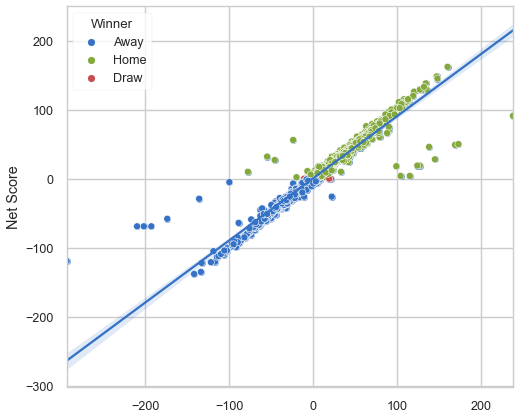

In [13]:
# Here, let's do a scatterplot of RLP vs Net Score

total_goal_difference = (home_away_net_complete['F-GL'] + home_away_net_complete['D-GL'] + home_away_net_complete['M-GL'] + home_away_net_complete['R-GL']) * 6 +\
home_away_net_complete['F-BH'] + home_away_net_complete['D-BH'] + home_away_net_complete['M-BH'] + home_away_net_complete['R-BH']

sns.regplot(data = home_away_net_complete, x=total_goal_difference, y="Net Score");
sns.scatterplot(data = home_away_net_complete, x=total_goal_difference, y="Net Score", hue = 'Winner');


# Here is the least surprising plot in the world, the most points wins and the slope is 1: it's always right.

At this point, I have all the data that I have.  I could supplement it (possibly) with distance traveled, but I'm not
sure that is critical.  I think I'm happy with this data.

Originally I wanted to reduce dimensionality, but in TensorFlow I don't think I want to reduce dimensionality.

What I want to do is cut each of these rows into the relevant position groups and run them through a ML process, then
take the output of each position group and run that through a further ML analysis before coming out with a relu prediction.

I do not want a binary judgment out of each position group - I want the most important impacts on winning for each position
group, and then I want to weigh each of those components against each other.

I have not normalized the data yet, so comparisons are a little difficult at this point.

Still, there are a couple of things that I'd like to check, like the obvious things:

1.) Does relative ladder position matter?  Does a higher seed ALWAYS beat a lower side, or is it still a crap shoot?
2.) Is there an aristocracy?  Do some teams just "always" win?  How can I encapsulate that?  That may require a different
dataset, but it should be easy.  Let's see if we can create tiers and use that to introduce some variability in the
prediction.

Maybe look at every PI for every game over the season (to date) and take a look at the variability and create a std range
based on historical performance.

That's going to come from the setup data and it's never going to change from year to year (since the 2021 season hasn't
started, everything is locked).  

The idea would be to look for PI that show a consistently high variability across season, teams, something, and then
use that to key in, or look for some explanatory value.

I broke out all of this data because it's always better to start with too much, and then sift it down to what really matters, rather than starting with too little and being unable to draw inferences.

But clearly, 78 usable features is too many.  And, because we’re looking at position PI in a game where PI flow into one another (one man's kick is another man's mark, etc.), it stands to reason that many of the features are going to be correlated to each other.  Young, et.al. suggest that an easy first step to reduce dimensionality is to look for features that are correlated with each other >.95, using Pearson’s R.

In [14]:
# By adding the _AMG suffix, I am ONLY running this analysis on years with AMG.

d_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('D-')]
f_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('F-')]
m_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('M-')]
r_delta_cols = [col for col in home_away_net_complete.columns if col.startswith('R-')]

d_deltas = home_away_net_complete[d_cols]
f_deltas = home_away_net_complete[f_cols]
m_deltas = home_away_net_complete[m_cols]
r_deltas = home_away_net_complete[r_cols]

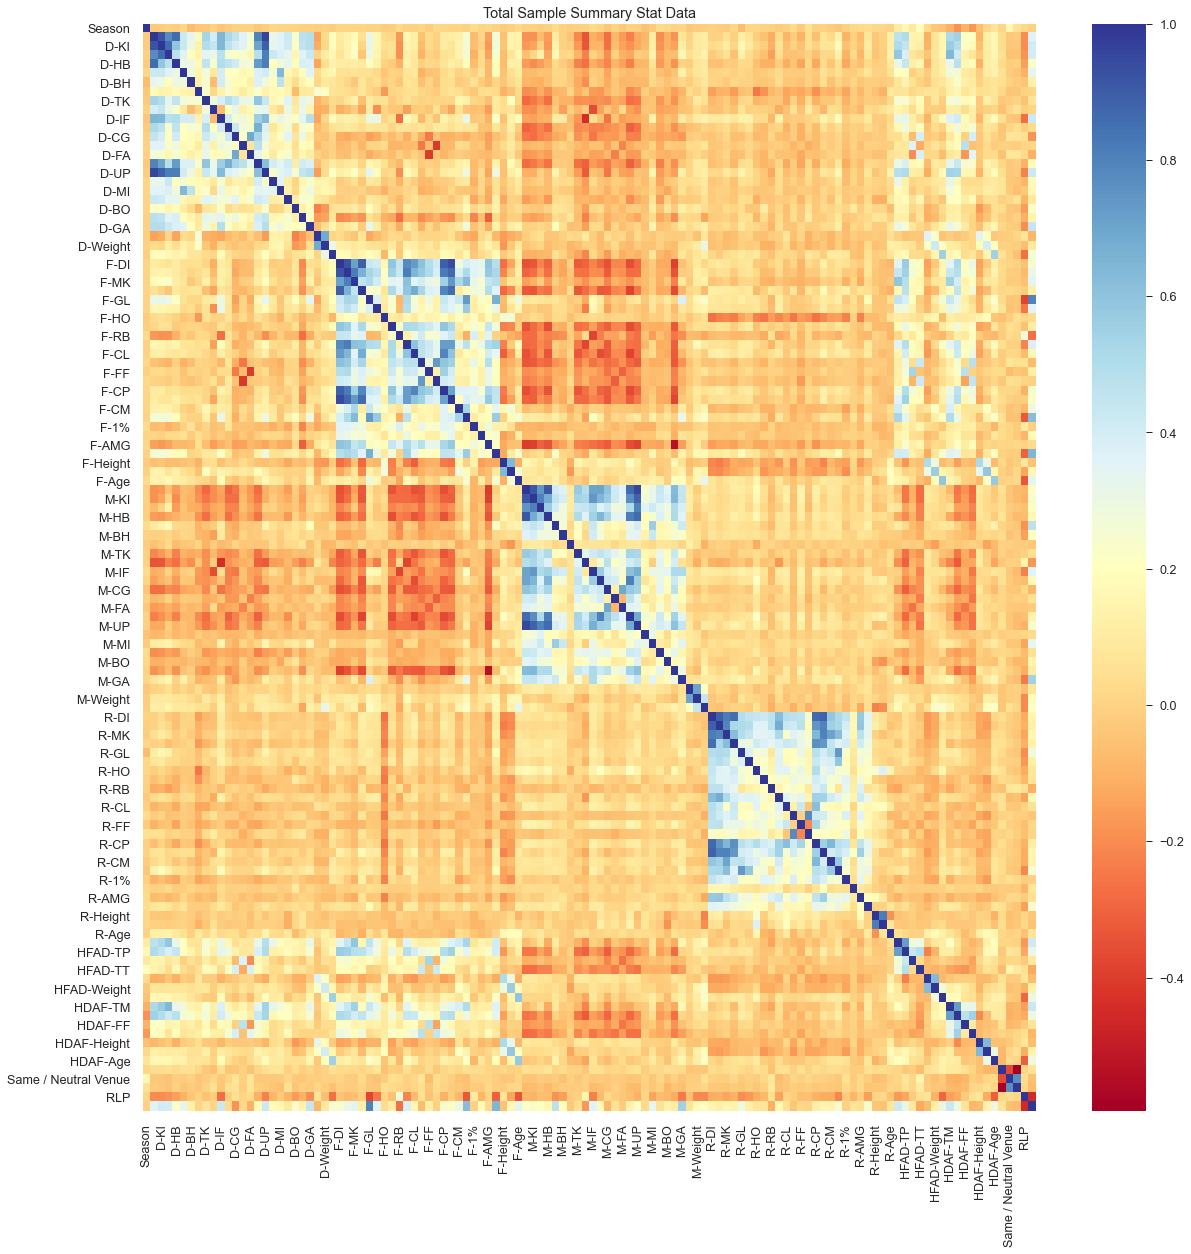

In [15]:
sns.set_style("whitegrid")
plt.figure(figsize=(20,20))
plt.title('Total Sample Summary Stat Data')
sns.heatmap(home_away_net_complete.corr(), cmap = 'RdYlBu');

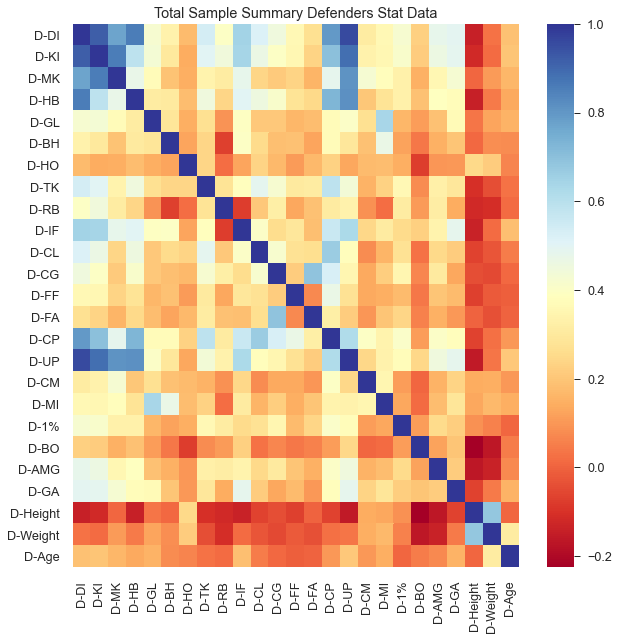

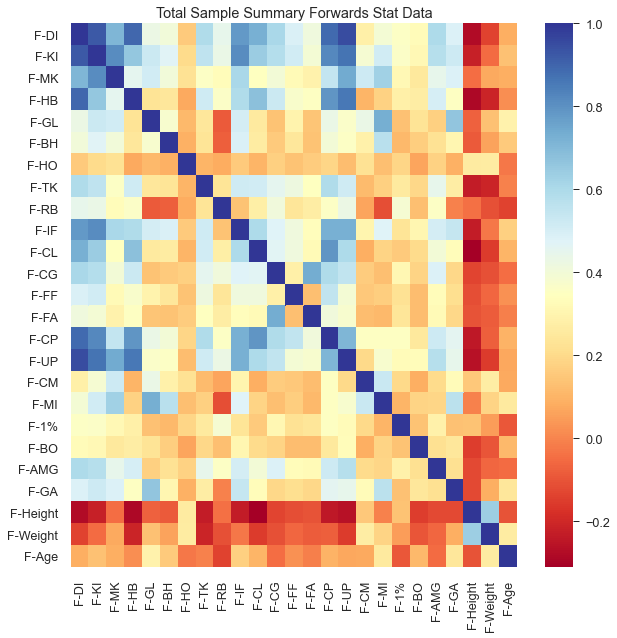

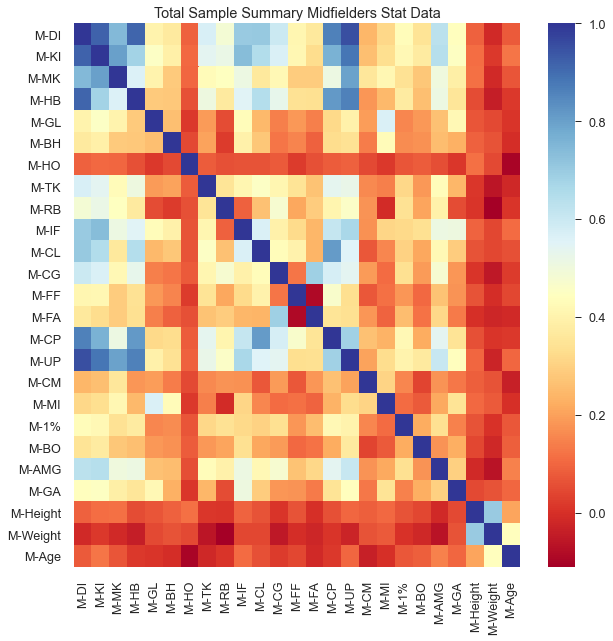

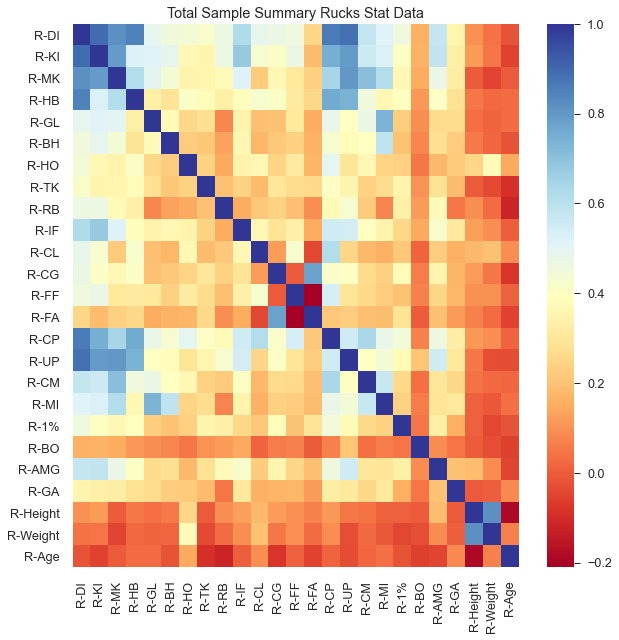

In [16]:
# plt.figure(figsize=(15,15))
# plt.title('Season Summary Stat Data')
# sns.heatmap(home_away_net.corr(), cmap = 'RdYlBu');

posgru_deltas = [d_deltas, f_deltas, m_deltas, r_deltas]
titles = ['Defenders', 'Forwards', 'Midfielders', 'Rucks']

for pg, t in zip(posgru_deltas, titles):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10,10))
    plt.title('Total Sample Summary '+t+' Stat Data')
    sns.heatmap(pg.corr(), cmap = 'RdYlBu');


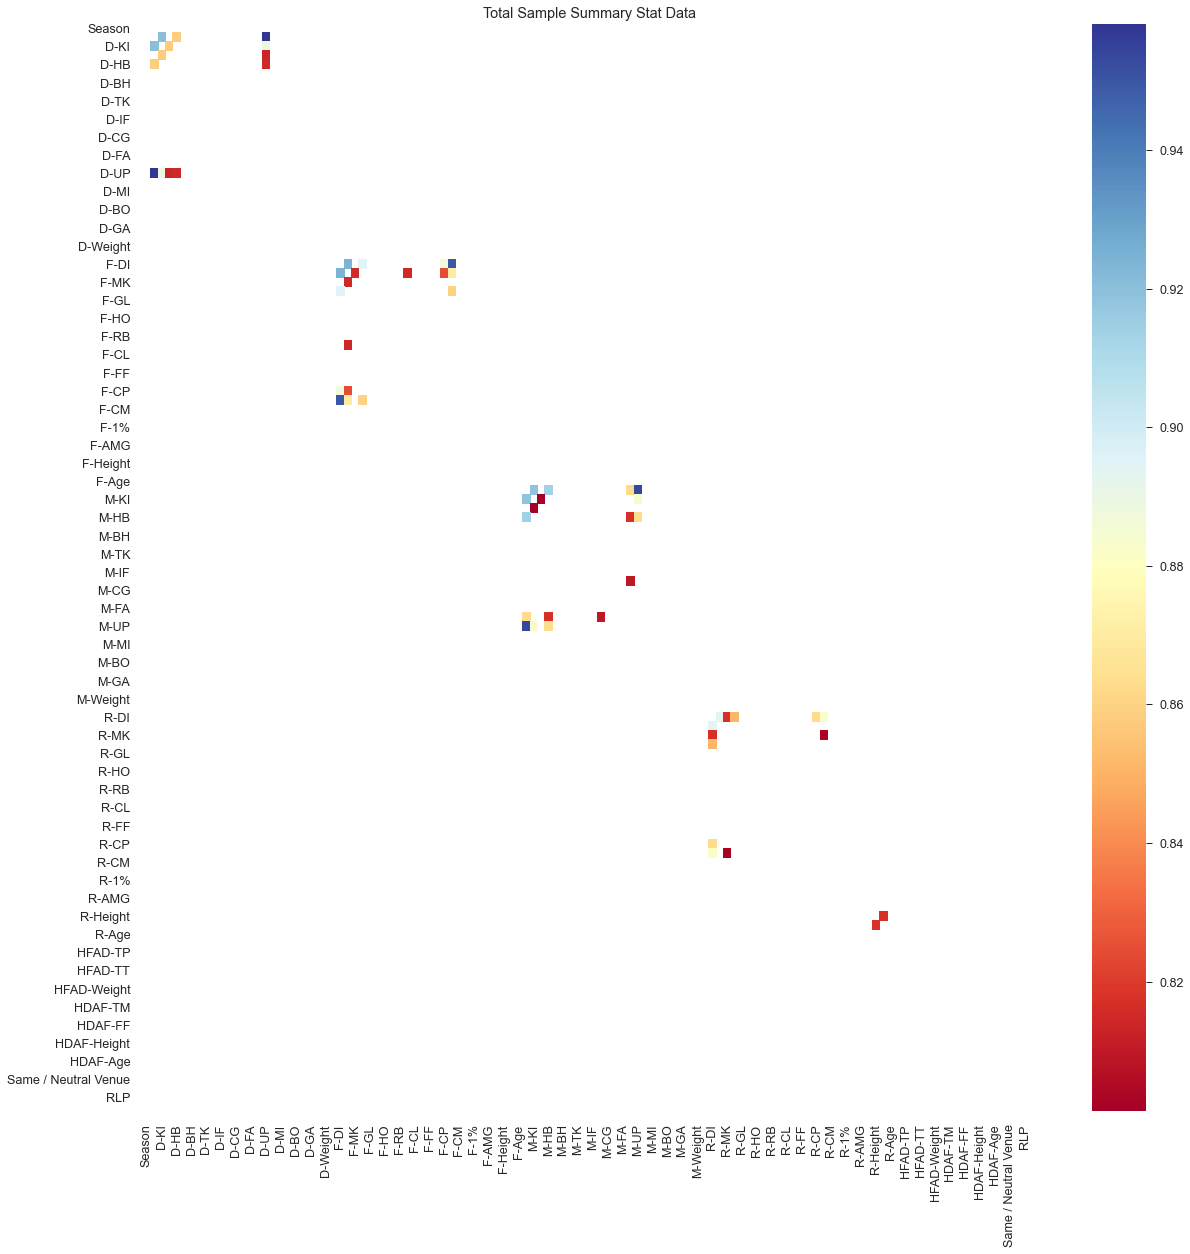

In [17]:
r_criterion = .8

all_deltas_criteria_list = []
plt.figure(figsize=(20,20))
plt.title('Total Sample Summary Stat Data')
corr = home_away_net_complete.corr()
kot = corr[(corr>=r_criterion) & (corr < 1.0)]
if kot.isnull().values.all() == False:
    sns.heatmap(kot, cmap = 'RdYlBu');
else:
    pass

all_deltas_criteria = np.argwhere(kot.notnull().values).tolist()
all_deltas_criteria_list.append(all_deltas_criteria)


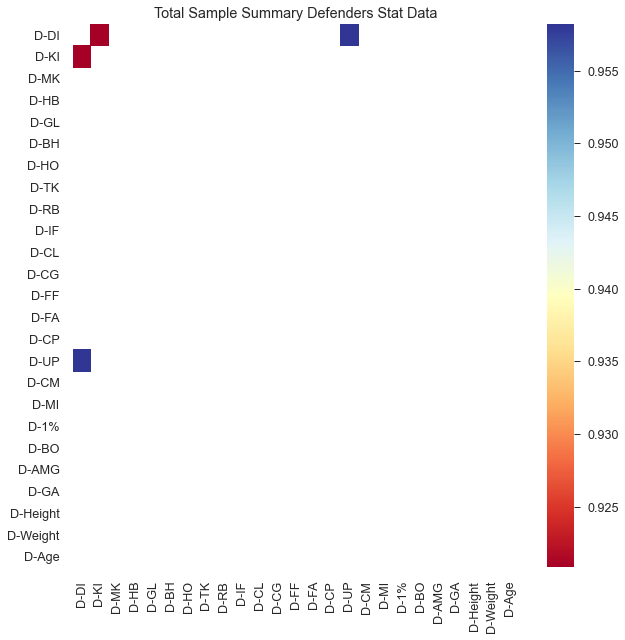

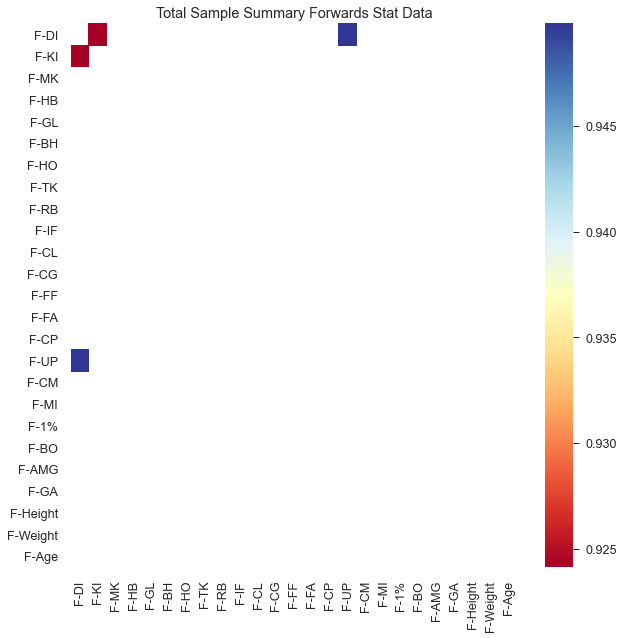

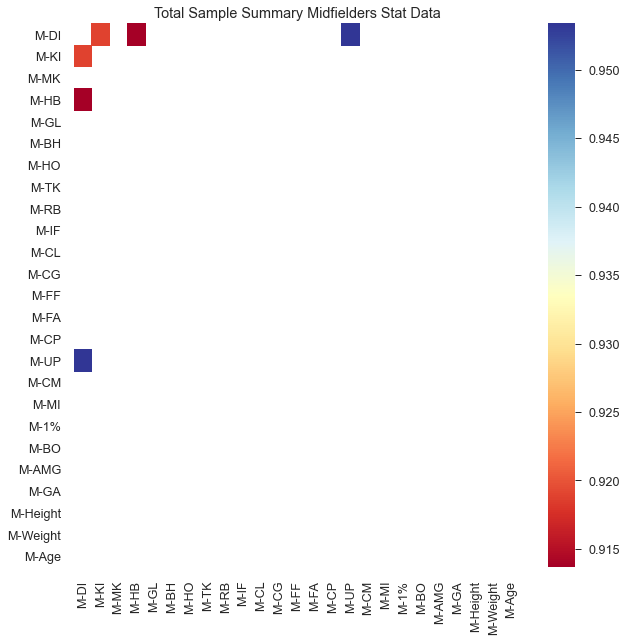

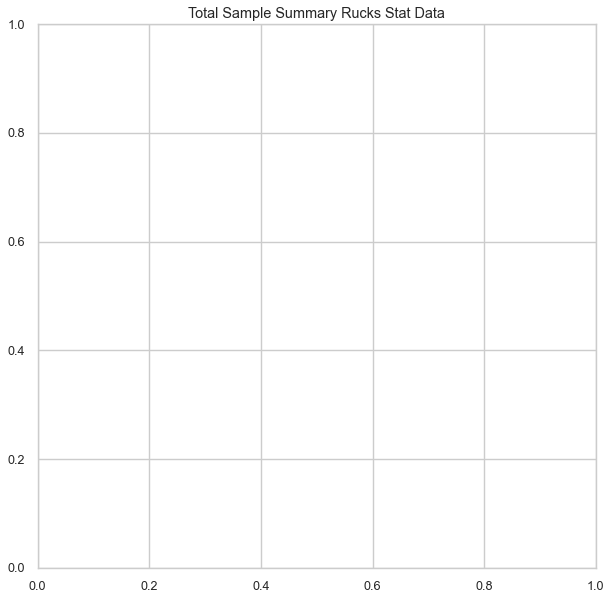

In [18]:
# plt.figure(figsize=(15,15))
# plt.title('Game PI Stat Data')
# sns.heatmap(home_away_net.corr(), cmap = 'RdYlBu');

r_criterion = .9

deltas_criteria_list = []
for pg, t in zip(posgru_deltas, titles):
    plt.figure(figsize=(10,10))
    plt.title('Total Sample Summary '+t+' Stat Data')
    corr = pg.corr()
    kot = corr[(corr>=r_criterion) & (corr < 1.0)]
    if kot.isnull().values.all() == False:
        sns.heatmap(kot, cmap = 'RdYlBu');
    else:
        pass

    deltas_criteria = np.argwhere(kot.notnull().values).tolist()
    deltas_criteria_list.append(deltas_criteria)


In [19]:
for dcl, t in zip(deltas_criteria_list, titles):
    print(t+' Deltas: ', dcl)
    

Defenders Deltas:  [[0, 1], [0, 15], [1, 0], [15, 0]]
Forwards Deltas:  [[0, 1], [0, 15], [1, 0], [15, 0]]
Midfielders Deltas:  [[0, 1], [0, 3], [0, 15], [1, 0], [3, 0], [15, 0]]
Rucks Deltas:  []


When you drill down, you see some things that make sense: there is a high correlation between having the ball and getting rid of the ball (which is a bit like noting that there is a high correlation between the numbers of pitches, balls, strikes, and hits - moving the ball is the point of the game).  Still, I'm not 100% what to do with this information.

Given that my plan is to take a deep learning approach, I don't WANT to reduce dimensionality.  I think the predictive power comes in the interplay of the PI, not in the elimination of PI.

When I looked at the bigger picture, I was looking for correlations OUTSIDE of the diagonal (within the POSGRU) and I just do not see them, almost no matter how low I drop the correlation.

I do need to try and figure out the absolute value thing, if possible.

# Preparing the PI Differential Data for Analysis

In [20]:
# Here I want to get rid of draws, drop all scoring-related PI, and then recreate my three experimental samples:

# 2012 - 2020 with no AMG
# 2015 - 2020 with AMG
# 2015 - 2020 with no AMG

In [21]:
# Here I removed the draws / ties from consideration.  There were 11 draws over the entire sample

home_away_net_complete.drop(home_away_net_complete[home_away_net_complete['Winner'] == 'Draw'].index, inplace = True)

# Here I eliminate all goal-scoring features (Goals, Behinds, and Goal Assists)

han_cols = home_away_net_complete.columns
no_goals = [g for g in han_cols if g.endswith(('GL', 'BH', 'GA'))]

home_away_net_complete_AMG_ng = home_away_net_complete.drop(no_goals, axis = 1)
# home_away_net_complete_AMG_ng

In [22]:
import pandas as pd
pi_abbrevs = ['DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP',
             'CM', 'MI', '1%', 'BO', 'AMG']

sums = []
for pia in pi_abbrevs:
    posgru_list = [g for g in home_away_net_complete_AMG_ng if g.startswith(('D', 'F', 'M', 'R')) and g.endswith((pia))]
    pi_sub = home_away_net_complete_AMG_ng[posgru_list]
    pi_sum = pi_sub.sum(axis = 1)
    sums.append(pi_sum)

new_dict = dict(zip(pi_abbrevs, sums))
new_df = pd.DataFrame(new_dict)

index_columns = home_away_net_complete_AMG_ng[['Home', 'Away', 'Season', 'Game', 'Round', 'Intrastate', 
                                               'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]
new_df1 = pd.concat([new_df,index_columns], axis = 1)
base_no_posgru_df = new_df1[['Home', 'Away', 'Season', 'Game', 'Round', 'DI', 'KI', 'MK', 'HB', 'HO', 'TK', 'RB', 
                             'IF', 'CL', 'CG', 'FF', 'FA', 'CP', 'UP', 'CM', 'MI', '1%', 'BO', 'AMG',
                             'Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP', 'Net Score', 'Winner']]

# this is new to cut the time sample down to 2015 and beyond

han_df0 = copy.deepcopy(base_no_posgru_df[base_no_posgru_df['Season'] > 2014])

han_df0 = han_df0.drop(columns = 'AMG')


In [23]:
# This is the same as df0, but WITH AMG

# han_drops = [g for g in home_away_net_complete_AMG_ng if g.endswith(('-AMG'))]

han_df1 = copy.deepcopy(base_no_posgru_df)

han_df1 = base_no_posgru_df[base_no_posgru_df['Season'] > 2014]

In [24]:
han_drops = [g for g in home_away_net_complete_AMG_ng if g.endswith(('-AMG'))]
han_df2 = home_away_net_complete_AMG_ng[home_away_net_complete_AMG_ng['Season']>2014]
han_df2.drop(columns = han_drops, inplace = True)

C:\Users\Michael\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
han_df3 = home_away_net_complete_AMG_ng[home_away_net_complete_AMG_ng['Season']>2014]

In [26]:
# Here I want to check and make sure that AMG is NOT in d1, but is in d2 and d3

d0_cols = han_df0.columns
d1_cols = han_df1.columns

dcol_base = [d0_cols, d1_cols]
dcol_base_str = ['d0_cols', 'd1_cols']

for dcb, dcbs in zip(dcol_base, dcol_base_str):
    if ('AMG') in dcb:
        print(dcbs+' has AMG column')
    else:
        print(dcbs+' does not have the AMG column')
    if ('GL' or 'GA' or 'BH') in dcb:
        print(dcbs+' still has Goal columns')
    else:
        print(dcbs+' does NOT have Goal columns')

d2_cols = han_df2.columns
d3_cols = han_df3.columns

dcols = [d2_cols, d3_cols]
dcols_str = ['d2_cols', 'd3_cols']

for dc, dcs in zip(dcols, dcols_str):
    if ('F-AMG' and 'D-AMG' and 'M-AMG' and 'R-AMG') in dc:
        print(dcs+' has AMG column')
    else:
        print(dcs+' does not have the AMG column')
    
    if ('F-GL' and 'D-GA' and 'M-BH' and 'R-GL') in dc:
        print(dcs+' still has Goal columns')
    else:
        print(dcs+' does NOT have the Goal columns')

###
# Here I am just checking da numbas of the target variable.

d1 = han_df1['Winner'].value_counts()
d2 = han_df2['Winner'].value_counts()

d1_h = (d1[0] / han_df1['Winner'].count()) * 100
d2_h = (d2[0] / han_df2['Winner'].count()) * 100

print('\nThe df1 home win distribution is: ', d1_h, 100 - d1_h)
print('\nThe df2 and df3 home win distribtion is: ', d2_h, 100 - d2_h)

d0_cols does not have the AMG column
d0_cols does NOT have Goal columns
d1_cols has AMG column
d1_cols does NOT have Goal columns
d2_cols does not have the AMG column
d2_cols does NOT have the Goal columns
d3_cols has AMG column
d3_cols does NOT have the Goal columns

The df1 home win distribution is:  56.79012345679012 43.20987654320988

The df2 and df3 home win distribtion is:  56.79012345679012 43.20987654320988


Here I am going to create my 4 samples: no POSGRU separation w/o all AMG data (han0), 2012-2020 w/o all AMG data (han1), 2015-2020 with AMG data (han2), 2015 w/o AMG data (han3).

# Normalization and X_train / X_test split

In [27]:
# First I define the X and Y variables and transform the Y via LabelEncoder()
# I have done all of my imports at the start of the worksheet

X0 = han_df0.iloc[:, 5:-2]
X1 = han_df1.iloc[:, 5:-2]
X2 = han_df2.iloc[:, 5:-2]
X3 = han_df3.iloc[:, 5:-2]

col0 = X0.pop('RLP')
X0.insert(0, col0.name, col0)

col1 = X1.pop('RLP')
X1.insert(0, col1.name, col1)

col2 = X2.pop('RLP')
X2.insert(0, col2.name, col2)

col3 = X3.pop('RLP')
X3.insert(0, col3.name, col3)

y0 = han_df0.iloc[:,-1]
y1 = han_df1.iloc[:,-1]
y2 = han_df2.iloc[:,-1]
y3 = han_df3.iloc[:,-1]
# z = home_away_net_complete_AMG_ng.iloc[:,-2]

le = LabelEncoder()
y0 = le.fit_transform(y0)
y1 = le.fit_transform(y1)
y2 = le.fit_transform(y2)
y3 = le.fit_transform(y3)

le.transform(['Home', 'Away'])

# # Here, 1 is a Home Win, 0 is an Away Win / Home Loss

array([1, 0], dtype=int64)

In [28]:
rs = 15 # my original random state was 5

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.20, stratify = y0, 
                                                        shuffle = True, random_state = rs)

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.20, stratify = y1, 
                                                        shuffle = True, random_state = rs)

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.20, stratify = y2, 
                                                        shuffle = True, random_state = rs)

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.20, stratify = y3, 
                                                        shuffle = True, random_state = rs)

In [29]:
# Here I am just verifying that the home / loss wins are approximately the same - it's just a sanity check.

samples = ['Sample 0','Sample 1', 'Sample 2', 'Sample 3']
trains = [y0_train, y1_train, y2_train, y3_train]
tests = [y0_test, y1_test, y2_test, y3_test]

for train, test, sample in zip(trains, tests, samples):
    unique_train, counts_train = np.unique(train, return_counts = True)
    train_ratio = dict(zip(unique_train, counts_train))

    unique_test, counts_test = np.unique(test, return_counts = True)
    test_ratio = dict(zip(unique_test, counts_test))

    percent_home_win_train = train_ratio[1] / (train_ratio[0] + train_ratio[1]) * 100
    percent_home_win_test = test_ratio[1] / (test_ratio[0] + test_ratio[1]) * 100

    print('Season summary ratio in '+ sample+': ', percent_home_win_train, percent_home_win_test)

# When I work on X1 / y1 I get 56.3 / 56.52 on the split.  If I do X2, X3 / y2, y3

Season summary ratio in Sample 0:  56.780595369349506 56.82819383259912
Season summary ratio in Sample 1:  56.780595369349506 56.82819383259912
Season summary ratio in Sample 2:  56.780595369349506 56.82819383259912
Season summary ratio in Sample 3:  56.780595369349506 56.82819383259912


In [30]:
X0_train_scaled = []
X1_train_scaled = []
X2_train_scaled = []
X3_train_scaled = []

X_train_str = ['X0_train','X1_train', 'X2_train', 'X3_train']
X_trains = [X0_train, X1_train, X2_train, X3_train]
X_tests = [X0_test, X1_test, X2_test, X3_test]
X_train_scaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]


for X_train_st, X_train, X_test in zip(X_train_str, X_trains, X_tests):
    columns = list(X_train.columns)

    keeper_columns = columns[:-3]

    keeper_data = X_train[keeper_columns]

    ct = ColumnTransformer([('somename', StandardScaler(), keeper_columns)], remainder = 'passthrough')

# # Here all of my data is scaled and transformed
    
    if X_train_st == 'X0_train':
        X0_train_scaled = ct.fit_transform(X_train[columns])
        X0_test_scaled = ct.transform(X_test[columns])    
    elif X_train_st == 'X1_train':
        X1_train_scaled = ct.fit_transform(X_train[columns])
        X1_test_scaled = ct.transform(X_test[columns])
    elif X_train_st == 'X2_train':
        X2_train_scaled = ct.fit_transform(X_train[columns])
        X2_test_scaled = ct.transform(X_test[columns])
    else:
        X3_train_scaled = ct.fit_transform(X_train[columns])
        X3_test_scaled = ct.transform(X_test[columns])
        

In [31]:
X1_train

RLP    DI    KI    MK    HB    HO    TK    RB    IF    CL  ...    CP  \
1681   13 -16.0 -21.0   3.0   4.0 -30.0   1.0  18.0 -28.0 -12.0  ... -33.0   
654     3   0.0  -5.0  21.0   5.0 -14.0  17.0  -6.0   2.0 -12.0  ... -28.0   
759     8 -17.0 -45.0 -48.0  28.0  -1.0   2.0  19.0 -19.0   2.0  ...  14.0   
735     4   3.0  -8.0  -7.0  11.0  -6.0   9.0  15.0 -18.0 -16.0  ... -18.0   
1231  -12  51.0  12.0 -16.0  39.0  26.0  -7.0 -12.0  16.0   4.0  ...  13.0   
...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1098    5 -54.0 -44.0 -27.0 -10.0  -9.0  -4.0 -38.0  31.0  -5.0  ... -22.0   
1378    6 -26.0 -26.0 -15.0   0.0  -3.0   1.0  14.0 -25.0   7.0  ...  -5.0   
1424   -5   1.0   8.0   9.0  -7.0  -6.0  12.0 -19.0  24.0   8.0  ...  -2.0   
738    -3 -67.0 -14.0 -12.0 -53.0  -3.0  10.0   7.0 -15.0  -7.0  ... -16.0   
1729   -4 -62.0 -32.0 -21.0 -36.0 -31.0  18.0   1.0  -8.0  14.0  ... -16.0   

        UP   CM    MI    1%    BO      AMG  Intrastate  Same / Neutral Venue  \
1681   1.0 -1.0  -8.0 -29.0   0.0  -521.76           1                     1   
654   22.0  5.0  -1.0  -1.0   2.0  -565.40           0                     1   
759  -36.0 -1.0 -10.0  -5.0   8.0  -821.81           1                     0   
735   21.0 -8.0  -3.0   4.0 -12.0    48.01           1                     0   
1231  34.0  2.0   3.0   3.0   3.0  1096.95           0                     0   
...    ...  ...   ...   ...   ...      ...         ...                   ...   
1098 -32.0 -4.0  -1.0 -16.0  -2.0  -266.58           1                     0   
1378 -18.0 -4.0  -8.0 -14.0   1.0   -95.27           1                     1   
1424  15.0  3.0  14.0  15.0  -1.0  -302.89           1                     0   
738  -55.0 -7.0  -5.0 -24.0   4.0  -237.09           0                     1   
1729 -72.0 -1.0  -6.0  -3.0   0.0  -335.98           0                     1   

      Clash  
1681      0  
654       1  
759       0  
735       0  
1231      0  
...     ...  
1098      0  
1378      0  
1424      0  
738       1  
1729      1  

[907 rows x 23 columns]

In [32]:
scaled_columns = X0_test.columns.to_list()
X0_train_scaled_df = pd.DataFrame(X0_train_scaled, columns = scaled_columns)
X0_test_scaled_df = pd.DataFrame(data = X0_test_scaled, columns = scaled_columns)
y0_train_df = pd.DataFrame(y0_train)
y0_test_df = pd.DataFrame(y0_test)

X0_train_scaled_df['Winner'] = y0_train_df[0]
X0_test_scaled_df['Winner'] = y0_test_df[0]


master_scaled_df0 = X0_train_scaled_df.append(X0_test_scaled_df)

master_scaled_df0.head()

RLP        DI        KI        MK        HB        HO        TK  \
0  1.691840 -0.451739 -0.746683 -0.014758 -0.026517 -1.541603  0.020795   
1  0.336156 -0.183626 -0.302554  0.624332  0.000059 -0.701476  1.142629   
2  1.013998 -0.468496 -1.412876 -1.825512  0.611295 -0.018873  0.090909   
3  0.471724 -0.133355 -0.385828 -0.369808  0.159512 -0.281412  0.581712   
4 -1.697370  0.670986  0.169333 -0.689353  0.903626  1.398842 -0.540122   

         RB        IF        CL  ...        CP        UP        CM        MI  \
0  1.587519 -1.938515 -1.270501  ... -1.903266 -0.143408 -0.239253 -1.308817   
1 -0.377293 -0.045227 -1.270501  ... -1.640349  0.264948  0.822748 -0.276815   
2  1.669386 -1.370528  0.122180  ...  0.568157 -0.862892 -0.239253 -1.603675   
3  1.341917 -1.307419 -1.668410  ... -1.114514  0.245502 -1.478253 -0.571673   
4 -0.868496  0.838307  0.321135  ...  0.515573  0.498294  0.291748  0.312900   

         1%        BO  Intrastate  Same / Neutral Venue  Clash  Winner  
0 -2.405359 -0.055157         1.0                   1.0    0.0       0  
1 -0.146744  0.278357         0.0                   1.0    1.0       0  
2 -0.469403  1.278897         1.0                   0.0    0.0       0  
3  0.256580 -2.056236         1.0                   0.0    0.0       1  
4  0.175915  0.445113         0.0                   0.0    0.0       1  

[5 rows x 23 columns]

In [33]:
# this is just for my eyeballs, a sanity check
import pandas as pd
scaled_columns = X1_test.columns.to_list()
X1_train_scaled_df = pd.DataFrame(X1_train_scaled, columns = scaled_columns)
X1_test_scaled_df = pd.DataFrame(data = X1_test_scaled, columns = scaled_columns)
y1_train_df = pd.DataFrame(y1_train)
y1_test_df = pd.DataFrame(y1_test)

X1_train_scaled_df['Winner'] = y1_train_df[0]
X1_test_scaled_df['Winner'] = y1_test_df[0]


master_scaled_df1 = X1_train_scaled_df.append(X1_test_scaled_df)

master_scaled_df1.head()

RLP        DI        KI        MK        HB        HO        TK  \
0  1.691840 -0.451739 -0.746683 -0.014758 -0.026517 -1.541603  0.020795   
1  0.336156 -0.183626 -0.302554  0.624332  0.000059 -0.701476  1.142629   
2  1.013998 -0.468496 -1.412876 -1.825512  0.611295 -0.018873  0.090909   
3  0.471724 -0.133355 -0.385828 -0.369808  0.159512 -0.281412  0.581712   
4 -1.697370  0.670986  0.169333 -0.689353  0.903626  1.398842 -0.540122   

         RB        IF        CL  ...        UP        CM        MI        1%  \
0  1.587519 -1.938515 -1.270501  ... -0.143408 -0.239253 -1.308817 -2.405359   
1 -0.377293 -0.045227 -1.270501  ...  0.264948  0.822748 -0.276815 -0.146744   
2  1.669386 -1.370528  0.122180  ... -0.862892 -0.239253 -1.603675 -0.469403   
3  1.341917 -1.307419 -1.668410  ...  0.245502 -1.478253 -0.571673  0.256580   
4 -0.868496  0.838307  0.321135  ...  0.498294  0.291748  0.312900  0.175915   

         BO       AMG  Intrastate  Same / Neutral Venue  Clash  Winner  
0 -0.055157 -1.033456         1.0                   1.0    0.0       0  
1  0.278357 -1.115766         0.0                   1.0    1.0       0  
2  1.278897 -1.599384         1.0                   0.0    0.0       0  
3 -2.056236  0.041194         1.0                   0.0    0.0       1  
4  0.445113  2.019613         0.0                   0.0    0.0       1  

[5 rows x 24 columns]

In [34]:
scaled_columns = X2_test.columns.to_list()
X2_train_scaled_df = pd.DataFrame(X2_train_scaled, columns = scaled_columns)
X2_test_scaled_df = pd.DataFrame(data = X2_test_scaled, columns = scaled_columns)
y2_train_df = pd.DataFrame(y2_train)
y2_test_df = pd.DataFrame(y2_test)

X2_train_scaled_df['Winner'] = y2_train_df[0]
X2_test_scaled_df['Winner'] = y2_test_df[0]


master_scaled_df2 = X2_train_scaled_df.append(X2_test_scaled_df)

master_scaled_df2.head()

RLP      D-DI      D-KI      D-MK      D-HB      D-HO      D-TK  \
0  1.691840 -0.523402 -0.667623 -0.437668 -0.139686  0.055765 -0.231921   
1  0.336156  0.765622  0.659471  0.459808  0.674611  0.055765  0.732507   
2  1.013998 -1.836748 -2.222219 -2.513080 -0.810283  0.055765 -1.303507   
3  0.471724  0.400804 -0.250536 -0.157207  1.105709  2.295561  1.268300   
4 -1.697370  0.449446  0.242384 -0.942498  0.578811 -1.437433 -0.017604   

       D-RB      D-IF      D-CL  ...   HDAF-TP   HDAF-FF   HDAF-TT  \
0 -0.660373 -0.516084 -0.019062  ... -0.870487  1.509769 -1.605729   
1 -0.347110  0.552306  0.184339  ... -1.600668 -0.734267 -3.520960   
2  0.488257 -0.248987 -0.425864  ... -0.277214  0.512420 -0.146506   
3  0.174994 -1.050279 -0.629265  ...  1.023421  0.512420  1.221516   
4 -0.347110  1.620695 -0.019062  ...  0.042240  0.761757  0.491905   

   HDAF-Height  HDAF-Weight  HDAF-Age  Intrastate  Same / Neutral Venue  \
0    -1.143756    -0.835888 -1.766013         1.0                   1.0   
1     1.538303     0.275770 -1.053670         0.0                   1.0   
2     0.737410    -0.947193 -0.890779         1.0                   0.0   
3     0.709472     2.598334  2.764133         1.0                   0.0   
4     1.622117     1.596010  1.154472         0.0                   0.0   

   Clash  Winner  
0    0.0       0  
1    1.0       0  
2    0.0       0  
3    0.0       1  
4    0.0       1  

[5 rows x 103 columns]

In [35]:
scaled_columns = X3_test.columns.to_list()
X3_train_scaled_df = pd.DataFrame(X3_train_scaled, columns = scaled_columns)
X3_test_scaled_df = pd.DataFrame(data = X3_test_scaled, columns = scaled_columns)
y3_train_df = pd.DataFrame(y3_train)
y3_test_df = pd.DataFrame(y3_test)

X3_train_scaled_df['Winner'] = y3_train_df[0]
X3_test_scaled_df['Winner'] = y3_test_df[0]


master_scaled_df3 = X3_train_scaled_df.append(X3_test_scaled_df)

master_scaled_df3.head()

RLP      D-DI      D-KI      D-MK      D-HB      D-HO      D-TK  \
0  1.691840 -0.523402 -0.667623 -0.437668 -0.139686  0.055765 -0.231921   
1  0.336156  0.765622  0.659471  0.459808  0.674611  0.055765  0.732507   
2  1.013998 -1.836748 -2.222219 -2.513080 -0.810283  0.055765 -1.303507   
3  0.471724  0.400804 -0.250536 -0.157207  1.105709  2.295561  1.268300   
4 -1.697370  0.449446  0.242384 -0.942498  0.578811 -1.437433 -0.017604   

       D-RB      D-IF      D-CL  ...   HDAF-TP   HDAF-FF   HDAF-TT  \
0 -0.660373 -0.516084 -0.019062  ... -0.870487  1.509769 -1.605729   
1 -0.347110  0.552306  0.184339  ... -1.600668 -0.734267 -3.520960   
2  0.488257 -0.248987 -0.425864  ... -0.277214  0.512420 -0.146506   
3  0.174994 -1.050279 -0.629265  ...  1.023421  0.512420  1.221516   
4 -0.347110  1.620695 -0.019062  ...  0.042240  0.761757  0.491905   

   HDAF-Height  HDAF-Weight  HDAF-Age  Intrastate  Same / Neutral Venue  \
0    -1.143756    -0.835888 -1.766013         1.0                   1.0   
1     1.538303     0.275770 -1.053670         0.0                   1.0   
2     0.737410    -0.947193 -0.890779         1.0                   0.0   
3     0.709472     2.598334  2.764133         1.0                   0.0   
4     1.622117     1.596010  1.154472         0.0                   0.0   

   Clash  Winner  
0    0.0       0  
1    1.0       0  
2    0.0       0  
3    0.0       1  
4    0.0       1  

[5 rows x 107 columns]

In [36]:
X3_train_scaled.shape

(907, 106)

# Ttest - identify features that influence the outcome

This analysis was in https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points, and I thought it was interesting, insofar as it uses the t-test statistic to provide some sense of feature importance in this big undifferentiated list.

P-value for Sample 0 is:  0.02649376945545532


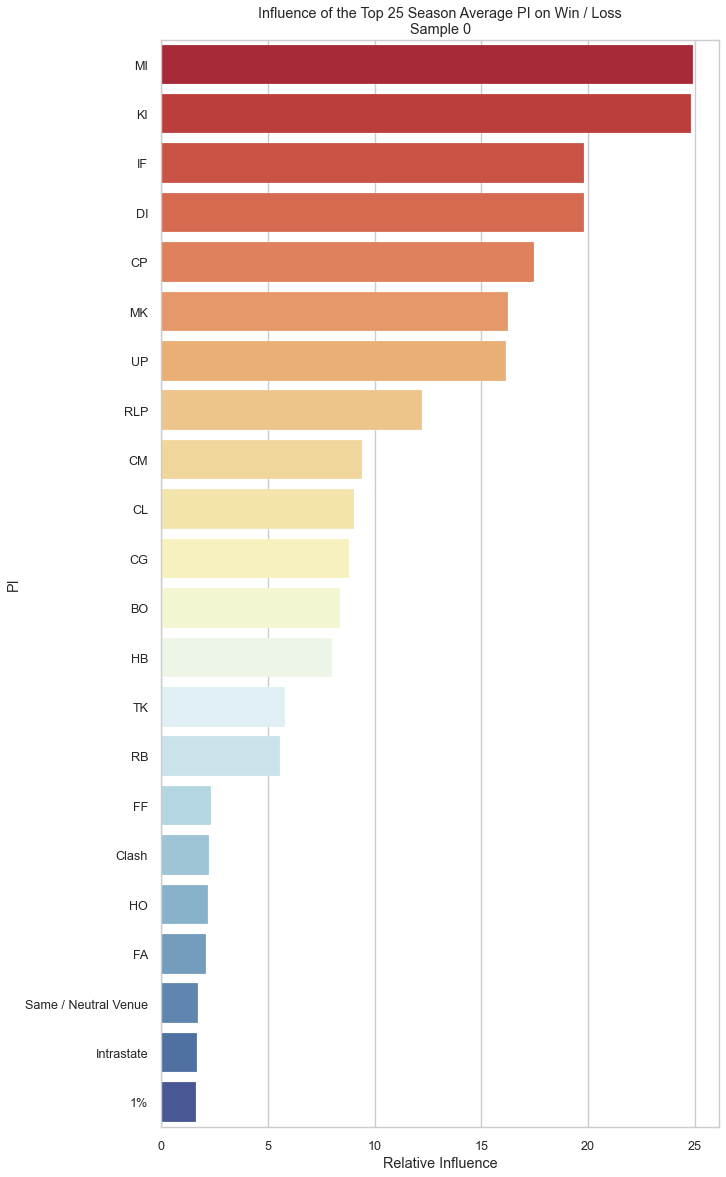

P-value for Sample 1 is:  0.02649376945545532


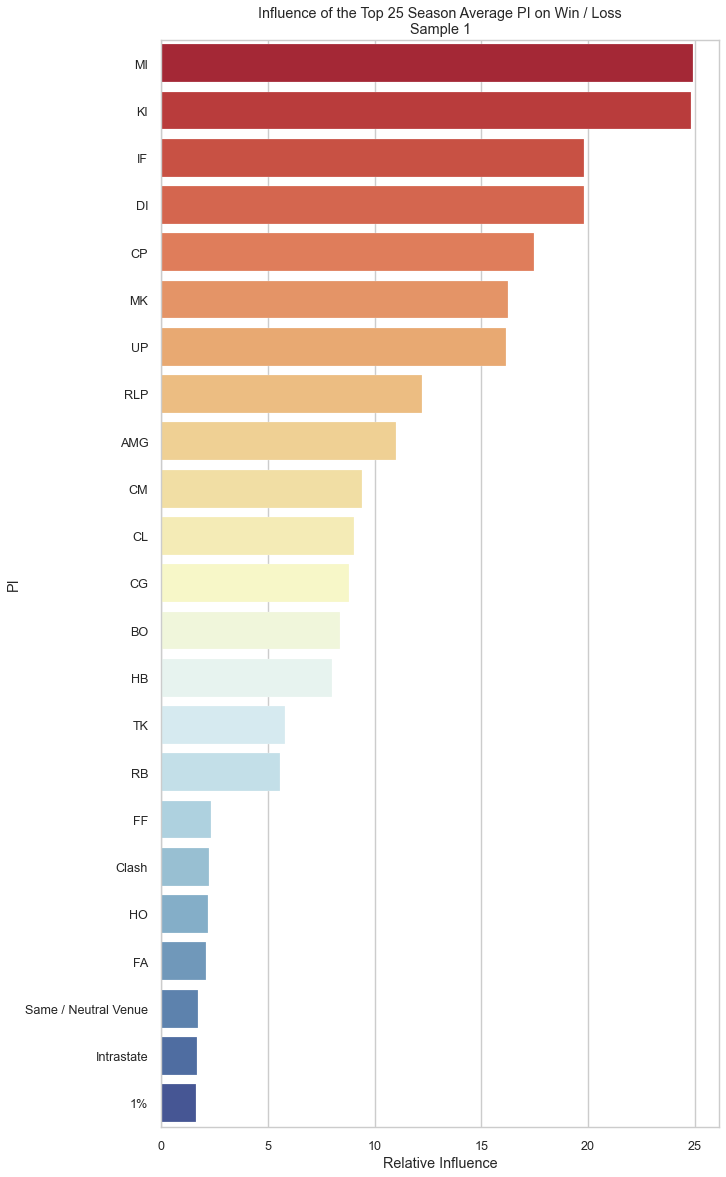

P-value for Sample 2 is:  0.02649376945545532


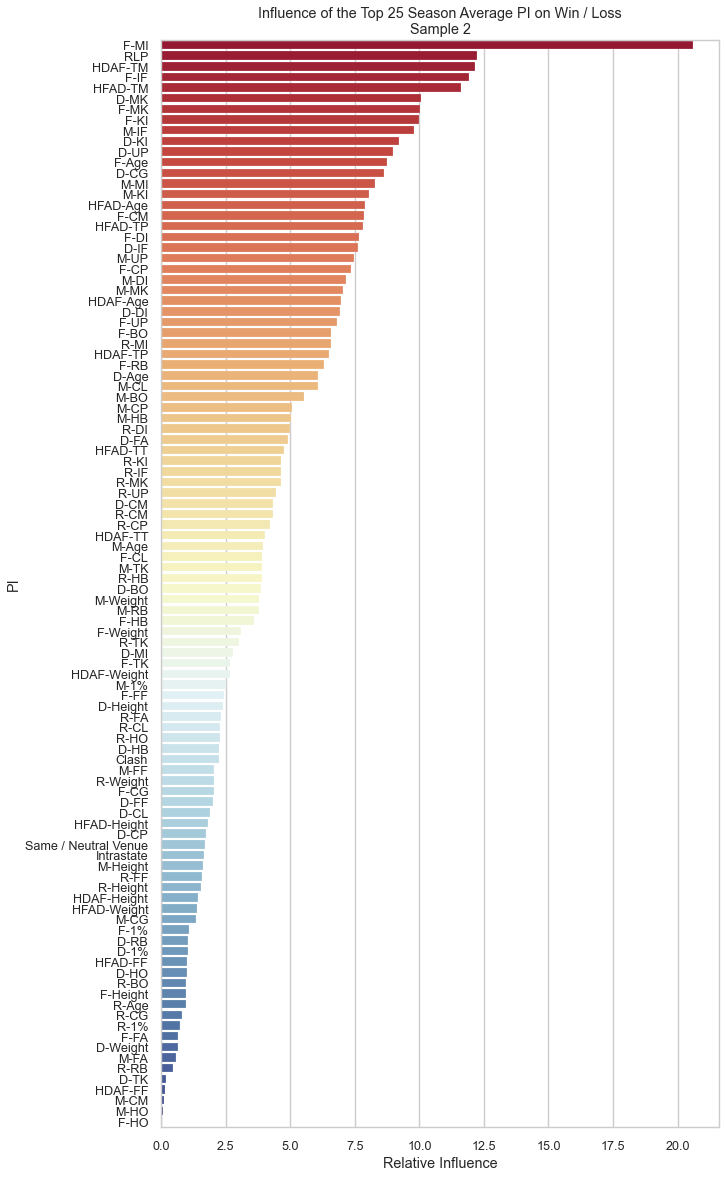

P-value for Sample 3 is:  0.02649376945545532


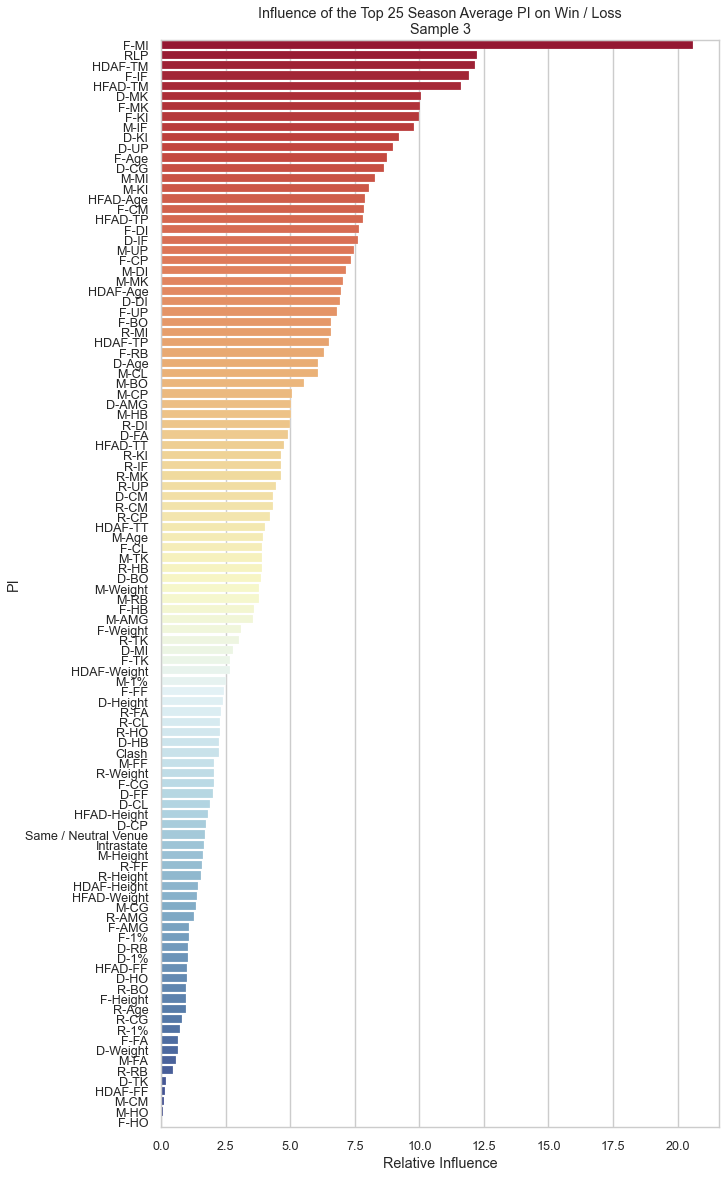

In [37]:
# m is the number of columns
scaled_dfs = [master_scaled_df0, master_scaled_df1, master_scaled_df2, master_scaled_df3]
str_dfs = ['Sample 0', 'Sample 1', 'Sample 2', 'Sample 3']

list_of_series_lists = []

for sdf, s_df in zip(scaled_dfs, str_dfs):
    number_list = sdf.select_dtypes(include = 'number').columns
    number_list = number_list[:-1]
# Home = 1, Away = 0
    hw = sdf[sdf.Winner == 1]
    aw = sdf[sdf.Winner == 0]

    # This analysis is copied from https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points

    series_list = []
    

    for m in range(len(number_list)):
        test_stat1, p_value1 = ttest_ind(hw[number_list[m]], aw[number_list[m]])
        series_list.append([number_list[m], test_stat1])

    hanet_stat = pd.DataFrame(series_list, columns = ['column_name', 'test_stat_mean'])
    hanet_stat.set_index('column_name', inplace = True)
    hanet_stat.replace([np.inf, -np.inf], np.nan, inplace = True)
    hanet_stat.dropna().abs().sort_values('test_stat_mean', ascending = False)['test_stat_mean']

    hanet_abs = hanet_stat['test_stat_mean'].abs()
    hanet_subset = hanet_abs.sort_values( ascending = False)

#     hanet_subset_1 = hanet_subset[:25]
    hanet_subset_1 = hanet_subset
    hanet_subset_1 = hanet_subset_1.reset_index()
    hanet_subset_1.rename(columns = {'column_name': 'PI', 'test_stat_mean': 'Relative Influence'}, inplace = True)
    
    print('P-value for '+s_df+' is: ',p_value1)
    plt.figure(figsize=(10,20))
    sns.barplot(x = 'Relative Influence', y = 'PI', data = hanet_subset_1, palette = 'RdYlBu').set_title('Influence of the Top 25 Season Average PI on Win / Loss\n'+s_df);
    plt.show();
    
    list_of_series_lists.append(series_list)

In [38]:
def explained_variance(xtrain_scaled_df, xtest_scaled_df):
    D_train_subset, D_test_subset = [col for col in xtrain_scaled_df if col.startswith('D-')], [col for col in xtest_scaled_df if col.startswith('D-')]
    D_train_scaled, D_test_scaled = xtrain_scaled_df[D_train_subset], xtest_scaled_df[D_test_subset]

    F_train_subset, F_test_subset = [col for col in xtrain_scaled_df if col.startswith('F-')], [col for col in xtest_scaled_df if col.startswith('F-')]
    F_train_scaled, F_test_scaled = xtrain_scaled_df[F_train_subset], xtest_scaled_df[F_test_subset]

    M_train_subset, M_test_subset = [col for col in xtrain_scaled_df if col.startswith('M-')], [col for col in xtest_scaled_df if col.startswith('M-')]
    M_train_scaled, M_test_scaled = xtrain_scaled_df[M_train_subset], xtest_scaled_df[M_test_subset]

    R_train_subset, R_test_subset = [col for col in xtrain_scaled_df if col.startswith('R-')], [col for col in xtest_scaled_df if col.startswith('R-')]
    R_train_scaled, R_test_scaled = xtrain_scaled_df[R_train_subset], xtest_scaled_df[R_test_subset]

    HDAF_train_subset, HDAF_test_subset = [col for col in xtrain_scaled_df if col.startswith('HDAF-')], [col for col in xtest_scaled_df if col.startswith('HDAF-')]
    HDAF_train_scaled, HDAF_test_scaled = xtrain_scaled_df[HDAF_train_subset], xtest_scaled_df[HDAF_test_subset]

    HFAD_train_subset, HFAD_test_subset = [col for col in xtrain_scaled_df if col.startswith('HFAD-')], [col for col in xtest_scaled_df if col.startswith('HFAD-')]
    HFAD_train_scaled, HFAD_test_scaled = xtrain_scaled_df[HFAD_train_subset], xtest_scaled_df[HFAD_test_subset]

    C_train_subset, C_test_subset = xtrain_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], xtest_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]

    pos_sub = [D_train_scaled, F_train_scaled, M_train_scaled, R_train_scaled, C_train_subset]
    pos_list = ['Defender', 'Forward', 'Midfield', 'Ruck', 'Categoricals']


    for ps, pl in zip(pos_sub, pos_list):

        range_end = ps.shape[1] + 1

        cov_mat = np.cov(ps.T)
        eigen_vals, eigen_Vecs = np.linalg.eig(cov_mat)
        # print('\nEigenvalues\n\n {}'.format(eigen_vals))

        tot = sum(eigen_vals)
        var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
        cum_var_exp = np.cumsum(var_exp)

        # Here I'm plotting the variance for the first 20 features.  I already know it's going to be quite remarkable

        plt.bar(range(1,range_end), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
        plt.step(range(1,range_end), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
        plt.ylabel('Explained variance ratio')
        plt.xlabel('Principal component index')
        plt.legend(loc = 'best')
        plt.title('Explained variance by '+pl+' feature')
        plt.tight_layout()
        plt.show()

In [39]:
# I had to do this different for df0 because it isn't broken out the same way that the rest of the DataFrames are.

# What this tells me is that df0 SHOULD perform better.  You get to 90% explained variance after just 10 features.

def explained_variance_master(master_scaled_df):
    range_end = master_scaled_df.shape[1] + 1

    cov_mat = np.cov(master_scaled_df.T)
    eigen_vals, eigen_Vecs = np.linalg.eig(cov_mat)
    # print('\nEigenvalues\n\n {}'.format(eigen_vals))

    tot = sum(eigen_vals).real
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse = True)]
    cum_var_exp = np.cumsum(var_exp).real

            # Here I'm plotting the variance for the first 20 features.  I already know it's going to be quite remarkable

    plt.bar(range(1,range_end), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
    plt.step(range(1,range_end), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc = 'best')
    plt.title('Explained variance by feature on undifferentiated sample')
    plt.tight_layout()
    plt.show()

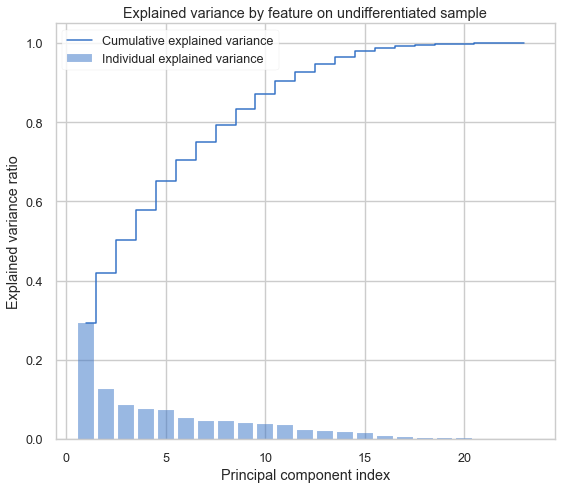

In [40]:
explained_variance_master(master_scaled_df0)

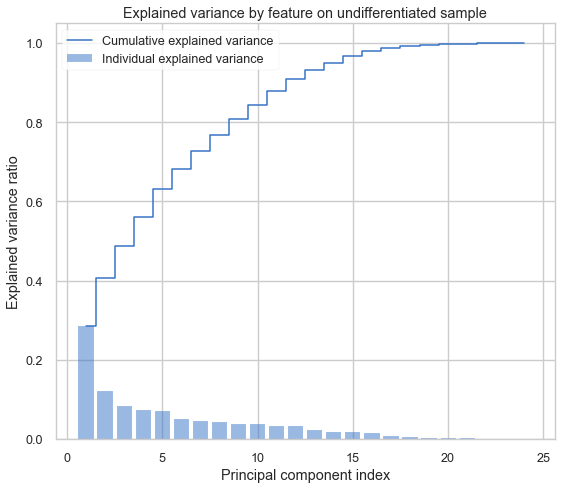

In [41]:
explained_variance_master(master_scaled_df1)

C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\Michael\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


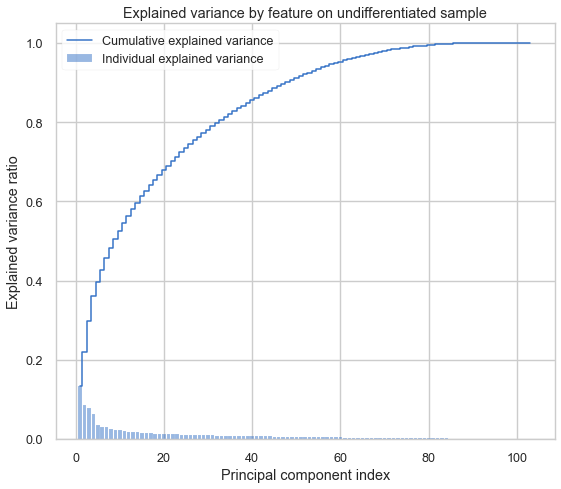

In [42]:
explained_variance_master(master_scaled_df2)

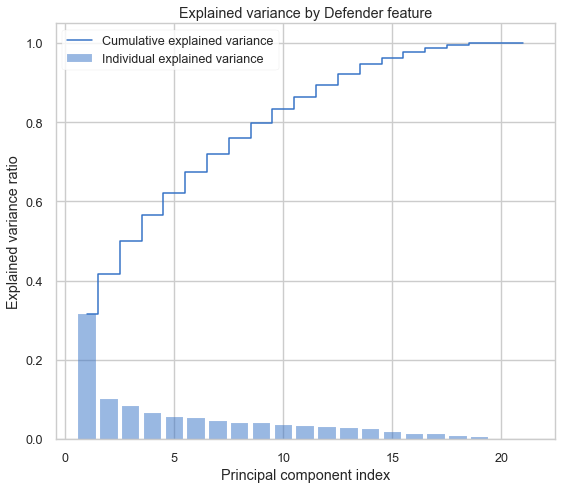

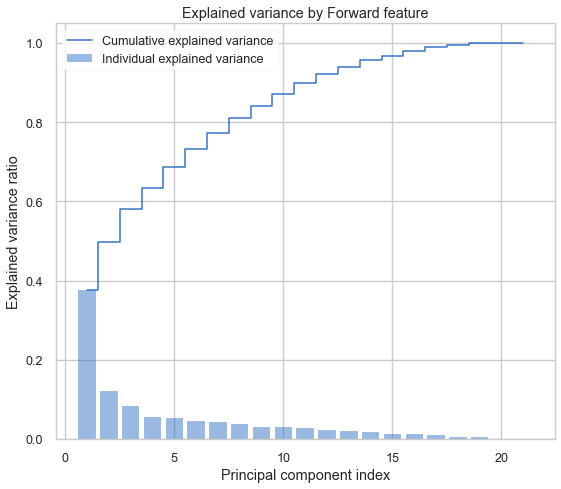

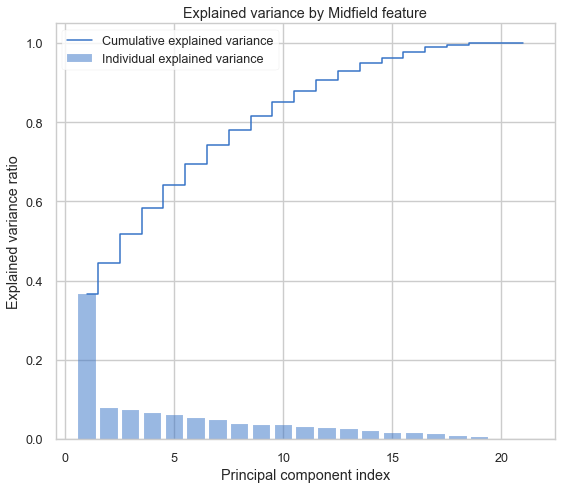

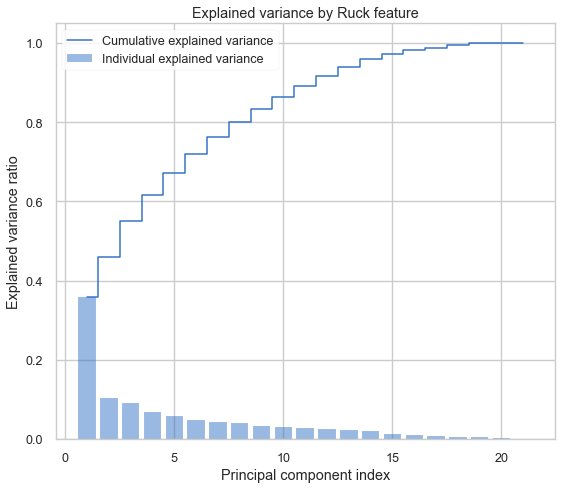

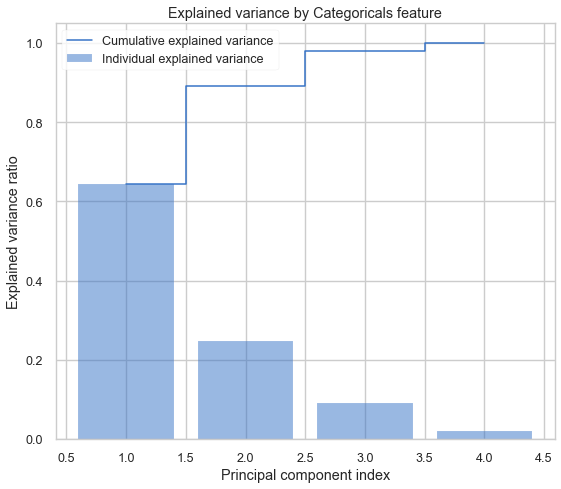

In [43]:
explained_variance(X2_train_scaled_df, X2_test_scaled_df)

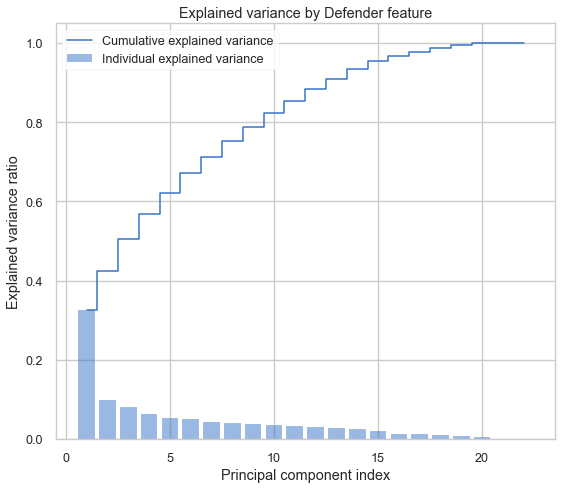

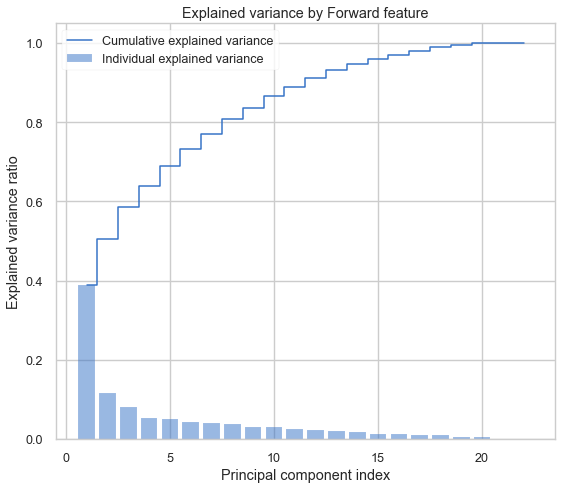

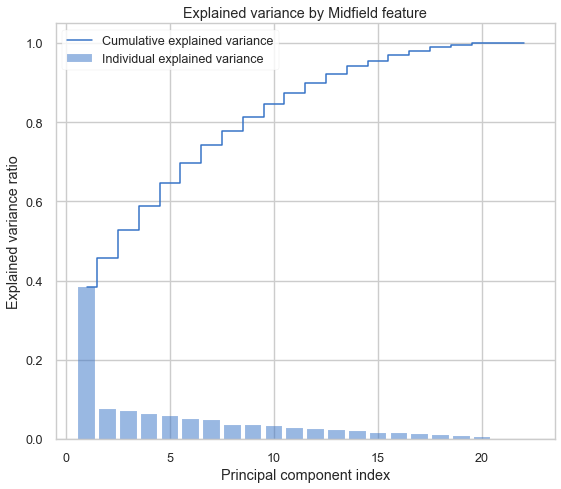

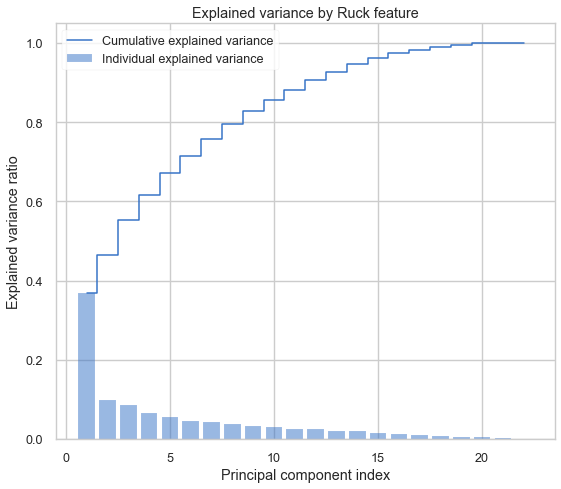

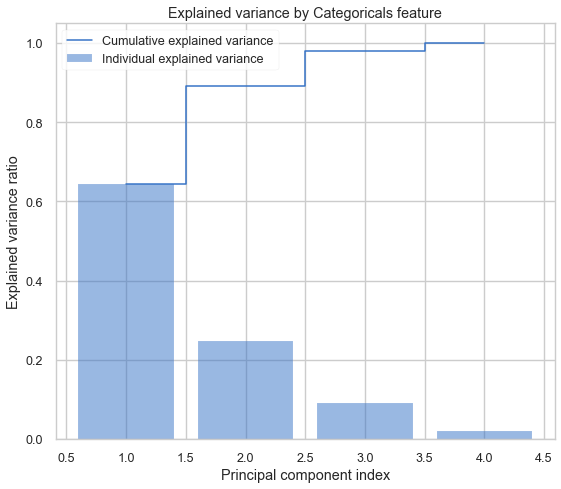

In [44]:
explained_variance(X3_train_scaled_df, X3_test_scaled_df)

# Baseline Machine Learning - Single Neuron Perceptrons

I begin the analysis here with single neuron perceptrons, using different classifiers.

In [45]:
samples = ['Sample '+str(n) for n in range(4)]
Xtrainscaleds = [X0_train_scaled, X1_train_scaled, X2_train_scaled, X3_train_scaled]
ytrains = [y0_train, y1_train, y2_train, y3_train]
Xtestscaleds = [X0_test_scaled, X1_test_scaled, X2_test_scaled, X3_test_scaled ]
ytests = [y0_test, y1_test, y2_test, y3_test]

In [46]:
# We will set a baseline with Naive Bayes, which makes no assumptions about the data.
# We'll start using all of the features.

# I can do this as a loop, I think

from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB

def naive_bayes(xtrain, ytrain, xtest, ytest, sample):

#     naive_bayes.nb_full_train_accuracy = []
#     naive_bayes.nb_full_test_accuracy = []
    
    modelG = GaussianNB()
    modelG.fit(xtrain,ytrain);
    y_hat = modelG.predict(xtrain)
    baseline_training_accuracy = accuracy_score(ytrain, y_hat)
    print('The baseline training accuracy with Naive Bayes on the complete '+sample+' is:', baseline_training_accuracy)
    naive_bayes.nb_full_train_accuracy = baseline_training_accuracy


    y_hat2 = modelG.predict(xtest)
    baseline_test_accuracy = accuracy_score(ytest, y_hat2)
    print('The baseline accuracy on the test set with Naive Bayes on the complete '+sample+' is:', baseline_test_accuracy)
    naive_bayes.nb_full_test_accuracy = baseline_test_accuracy
    print('\n')

In [47]:
nb_train_accuracies = []
nb_test_accuracies = [] 

for xtrs, ytr, xtes, yte, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, samples):
    naive_bayes(xtrs, ytr, xtes, yte, sample)
    
    nb_train_accuracies.append(naive_bayes.nb_full_train_accuracy)
    nb_test_accuracies.append(naive_bayes.nb_full_test_accuracy)

The baseline training accuracy with Naive Bayes on the complete Sample 0 is: 0.804851157662624
The baseline accuracy on the test set with Naive Bayes on the complete Sample 0 is: 0.8149779735682819


The baseline training accuracy with Naive Bayes on the complete Sample 1 is: 0.8136714443219405
The baseline accuracy on the test set with Naive Bayes on the complete Sample 1 is: 0.8237885462555066


The baseline training accuracy with Naive Bayes on the complete Sample 2 is: 0.8180815876515987
The baseline accuracy on the test set with Naive Bayes on the complete Sample 2 is: 0.8281938325991189


The baseline training accuracy with Naive Bayes on the complete Sample 3 is: 0.824696802646086
The baseline accuracy on the test set with Naive Bayes on the complete Sample 3 is: 0.8237885462555066




In [48]:
# What I'd say here is that the shorter sample is actually a little bit more accurate, but the AMG stats don't make
# that big of a difference and I would think that they should.

Here I try a Logistic Regression classifier.

First, I do a gridsearch CV to pick the best hyperparameters.

When I apply the Logistic Regression classifier to the samples, using a stratified K-fold technique to improve the accuracy.  Much of the predictive power is based on what goes into the training set - the quality (and predictive power of the training data) varies pretty substantially.  Depending on the sample I can get between 50-60% accuracy and 80-90% accuracy.

In [49]:
from sklearn.metrics import roc_curve, auc
from numpy import interp

def log_grid_graph(xtrain, ytrain, xtest, ytest, sample):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(X1_train_scaled, y1_train)
#     print('Best parameters for original reduction')
#     print(gs.best_score_)
#     print(gs.best_params_)

    pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    ## Let's try a ROC / AUC graph
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = pipe_lr.fit(xtrain[train], ytrain[train]).predict_proba(xtrain[test])
        fpr, tpr, thresholds = roc_curve(ytrain[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.title('ROC / AUC for '+sample)
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


In [50]:
def log_grid_pipeline(xtrain, ytrain, xtest, ytest, sample):
    
    logistic = LogisticRegression(solver = 'liblinear',max_iter = 200, random_state = 0)

    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty = penalty)

    
    gs = GridSearchCV(logistic, hyperparameters, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(X1_train_scaled, y1_train)
    print('Best parameters for original reduction on '+sample)
    print(gs.best_score_)
    print(gs.best_params_)

    log_grid_pipeline.pipe_lr = make_pipeline(LogisticRegression(C = gs.best_params_['C'], penalty = gs.best_params_['penalty'] , 
                                               solver = 'liblinear', random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
#     log_grid_pipeline.scores_test = []
#     log_grid_pipeline.scores_train = []

    for k, (train, test) in enumerate(kfold):
        log_grid_pipeline.pipe_lr.fit(xtrain[train], ytrain[train])
        score_train = log_grid_pipeline.pipe_lr.score(xtrain[train], ytrain[train])
        score_test = log_grid_pipeline.pipe_lr.score(xtrain[test], ytrain[test])
        log_grid_pipeline.scores_test = score_test
        log_grid_pipeline.scores_train = score_train
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))

    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(score_train), np.std(score_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(score_test), np.std(score_test)))


Best parameters for original reduction on Sample 0
0.8876190476190476
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.887, Test Acc.: 0.901
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.890
Fold:  3, Class dist.: [353 463], Train Acc.: 0.904, Test Acc.: 0.857
Fold:  4, Class dist.: [353 463], Train Acc.: 0.902, Test Acc.: 0.835
Fold:  5, Class dist.: [353 463], Train Acc.: 0.902, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.897, Test Acc.: 0.879
Fold:  7, Class dist.: [353 463], Train Acc.: 0.890, Test Acc.: 0.934
Fold:  8, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.889
Fold:  9, Class dist.: [353 464], Train Acc.: 0.891, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.911

CV Train accuracy: 0.896 +/-0.000
CV Test accuracy: 0.911 +/-0.000


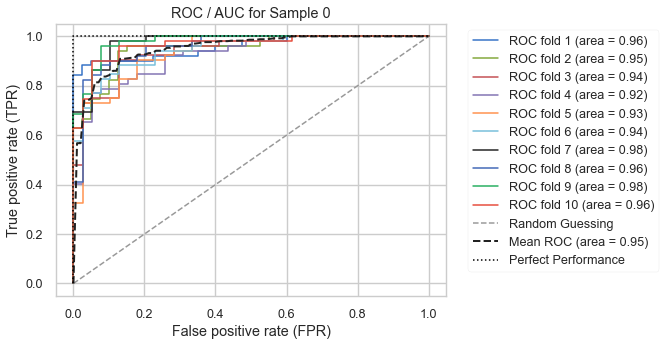

Best parameters for original reduction on Sample 1
0.8876190476190476
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.887, Test Acc.: 0.901
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.890
Fold:  3, Class dist.: [353 463], Train Acc.: 0.902, Test Acc.: 0.857
Fold:  4, Class dist.: [353 463], Train Acc.: 0.902, Test Acc.: 0.835
Fold:  5, Class dist.: [353 463], Train Acc.: 0.902, Test Acc.: 0.846
Fold:  6, Class dist.: [353 463], Train Acc.: 0.897, Test Acc.: 0.879
Fold:  7, Class dist.: [353 463], Train Acc.: 0.888, Test Acc.: 0.934
Fold:  8, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.889
Fold:  9, Class dist.: [353 464], Train Acc.: 0.891, Test Acc.: 0.933
Fold: 10, Class dist.: [353 464], Train Acc.: 0.896, Test Acc.: 0.911

CV Train accuracy: 0.896 +/-0.000
CV Test accuracy: 0.911 +/-0.000


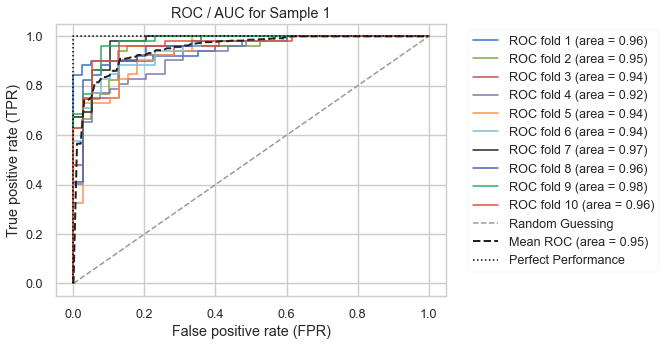

Best parameters for original reduction on Sample 2
0.8876190476190476
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.922, Test Acc.: 0.879
Fold:  2, Class dist.: [352 464], Train Acc.: 0.931, Test Acc.: 0.846
Fold:  3, Class dist.: [353 463], Train Acc.: 0.930, Test Acc.: 0.857
Fold:  4, Class dist.: [353 463], Train Acc.: 0.922, Test Acc.: 0.824
Fold:  5, Class dist.: [353 463], Train Acc.: 0.923, Test Acc.: 0.879
Fold:  6, Class dist.: [353 463], Train Acc.: 0.924, Test Acc.: 0.868
Fold:  7, Class dist.: [353 463], Train Acc.: 0.922, Test Acc.: 0.879
Fold:  8, Class dist.: [353 464], Train Acc.: 0.924, Test Acc.: 0.867
Fold:  9, Class dist.: [353 464], Train Acc.: 0.920, Test Acc.: 0.867
Fold: 10, Class dist.: [353 464], Train Acc.: 0.923, Test Acc.: 0.878

CV Train accuracy: 0.923 +/-0.000
CV Test accuracy: 0.878 +/-0.000


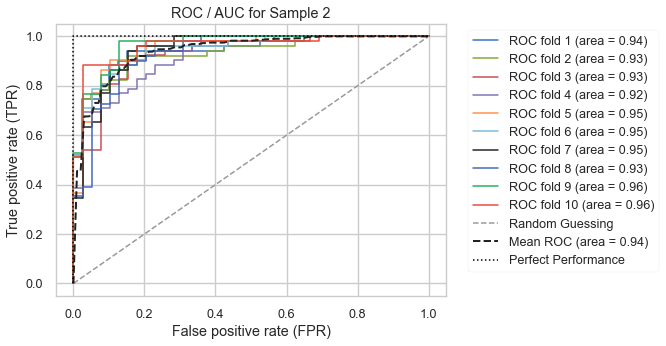

Best parameters for original reduction on Sample 3
0.8876190476190476
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.920, Test Acc.: 0.890
Fold:  2, Class dist.: [352 464], Train Acc.: 0.934, Test Acc.: 0.857
Fold:  3, Class dist.: [353 463], Train Acc.: 0.930, Test Acc.: 0.857
Fold:  4, Class dist.: [353 463], Train Acc.: 0.928, Test Acc.: 0.802
Fold:  5, Class dist.: [353 463], Train Acc.: 0.918, Test Acc.: 0.879
Fold:  6, Class dist.: [353 463], Train Acc.: 0.926, Test Acc.: 0.890
Fold:  7, Class dist.: [353 463], Train Acc.: 0.924, Test Acc.: 0.857
Fold:  8, Class dist.: [353 464], Train Acc.: 0.925, Test Acc.: 0.867
Fold:  9, Class dist.: [353 464], Train Acc.: 0.920, Test Acc.: 0.900
Fold: 10, Class dist.: [353 464], Train Acc.: 0.929, Test Acc.: 0.889

CV Train accuracy: 0.929 +/-0.000
CV Test accuracy: 0.889 +/-0.000


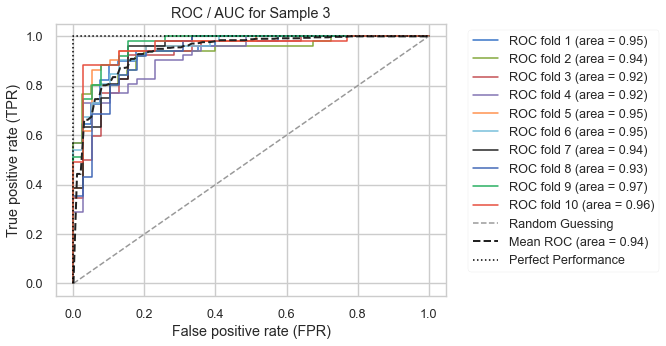

In [51]:
lr_train_accuracies = []
lr_test_accuracies = [] 

for xtrs, ytr, xtes, yte, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, samples):
    log_grid_pipeline(xtrs, ytr, xtes, yte, sample)
    log_grid_graph(xtrs, ytr, xtes, yte, sample)
    
    lr_train_accuracies.append(log_grid_pipeline.scores_train)
    lr_test_accuracies.append(log_grid_pipeline.scores_test)

In [52]:
lr_test_accuracies

[0.9111111111111111,
 0.9111111111111111,
 0.8777777777777778,
 0.8888888888888888]

Here, I follow the same process, but with a Support Vector Model classifier.

This overtrains a little bit, but I think I can control it with some lasso controls.  But honestly, I'm not terribly concerned with this much variability right now.  I'm looking for a performance baseline.

Some observations:

We're talking about marginal gains.  The POSGRU analysis adds about 3% accuracy in this logistic regression.  AMG doesn't really appear to add much value when comparing samples 2 and 3.  Is this significant?

In [53]:
def svc_grid_pipeline(xtrain, ytrain, xtest, ytest, sample):
    
    pipe_svc = make_pipeline(SVC(random_state = 0))

    param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
    param_grid = [{'svc__C': param_range, 'svc__kernel': ['linear']},
                 {'svc__C': param_range, 'svc__gamma': param_range, 'svc__kernel': ['rbf']}]

    
    gs = GridSearchCV(estimator = pipe_svc, param_grid = param_grid, scoring = 'accuracy', cv = 10, refit = True, n_jobs = -1)

    gs = gs.fit(xtrain, ytrain)
    print('The best score and parameters, and overall accuracy for '+sample+' are:\n')
    print(gs.best_score_)
    print(gs.best_params_)
    
    pipe_svc = make_pipeline(SVC(kernel = gs.best_params_['svc__kernel'],C = gs.best_params_['svc__C'], random_state = 0))

    kfold = StratifiedKFold(n_splits = 10).split(xtrain, ytrain)
    
    
    for k, (train, test) in enumerate(kfold):
        pipe_svc.fit(xtrain[train], ytrain[train])
        score_train = pipe_svc.score(xtrain[train], ytrain[train])
        score_test = pipe_svc.score(xtrain[test], ytrain[test])
        print('Fold: %2d, Class dist.: %s, Train Acc.: %.3f, Test Acc.: %.3f'%(k+1, np.bincount(ytrain[train]), score_train, score_test))

    svc_grid_pipeline.train_accuracies = np.mean(score_train)
    svc_grid_pipeline.test_accuracies = np.mean(score_test)
    
    print('\nCV Train accuracy: %.3f +/-%.3f'%(np.mean(score_train), np.std(score_train)))
    print('CV Test accuracy: %.3f +/-%.3f'%(np.mean(score_test), np.std(score_test)))
    print('\n')


In [54]:
svc_train_accuracies = []
svc_test_accuracies = []

for xtrs, ytr, xtes, yte, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, samples):
    svc_grid_pipeline(xtrs, ytr, xtes, yte, sample)
    
    svc_train_accuracies.append(svc_grid_pipeline.train_accuracies)
    svc_test_accuracies.append(svc_grid_pipeline.test_accuracies)

The best score and parameters, and overall accuracy for Sample 0 are:

0.8831623931623932
{'svc__C': 0.1, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.887, Test Acc.: 0.912
Fold:  2, Class dist.: [352 464], Train Acc.: 0.895, Test Acc.: 0.868
Fold:  3, Class dist.: [353 463], Train Acc.: 0.896, Test Acc.: 0.835
Fold:  4, Class dist.: [353 463], Train Acc.: 0.896, Test Acc.: 0.857
Fold:  5, Class dist.: [353 463], Train Acc.: 0.898, Test Acc.: 0.835
Fold:  6, Class dist.: [353 463], Train Acc.: 0.891, Test Acc.: 0.901
Fold:  7, Class dist.: [353 463], Train Acc.: 0.880, Test Acc.: 0.945
Fold:  8, Class dist.: [353 464], Train Acc.: 0.890, Test Acc.: 0.856
Fold:  9, Class dist.: [353 464], Train Acc.: 0.882, Test Acc.: 0.922
Fold: 10, Class dist.: [353 464], Train Acc.: 0.885, Test Acc.: 0.900

CV Train accuracy: 0.885 +/-0.000
CV Test accuracy: 0.900 +/-0.000


The best score and parameters, and overall accuracy for Sample 1 are:

0.8864957264957265
{'svc__C'

# Lasso Regression

In [55]:
# I'm sure I'm not doing this right.  Take another run at this tomorrow.

In [56]:
from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import Lasso


In [57]:
model_lasso = Lasso(alpha = 1)
model_lasso.fit(Xtrainscaleds[0], ytrains[0])

pred_train_lasso = model_lasso.predict(Xtrainscaleds[0])
pred_test_lasso = model_lasso.predict(Xtestscaleds[0])

In [58]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import RidgeClassifier



for n in range(4):
    model_ridge = RidgeClassifier()

    alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

    grid = dict(alpha = alpha)
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 5)
    grid_search = GridSearchCV(estimator = model_ridge, param_grid = grid, n_jobs = -1, cv = cv,
                              scoring = 'accuracy', error_score = 0)

    grid_result = grid_search.fit(Xtrainscaleds[n], ytrains[n])

    print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_ ['params']

    for mean, stdev, param in zip(means, stds, params):
        print('%f (%f) with: %r'%(mean, stdev, param))

Best: 0.870590 using {'alpha': 0.6}
0.868396 (0.029693) with: {'alpha': 0.1}
0.869125 (0.030896) with: {'alpha': 0.2}
0.869491 (0.031206) with: {'alpha': 0.3}
0.869858 (0.030994) with: {'alpha': 0.4}
0.870224 (0.031036) with: {'alpha': 0.5}
0.870590 (0.031588) with: {'alpha': 0.6}
0.870224 (0.031295) with: {'alpha': 0.7}
0.870224 (0.031295) with: {'alpha': 0.8}
0.870224 (0.031295) with: {'alpha': 0.9}
0.870220 (0.032711) with: {'alpha': 1.0}
Best: 0.868759 using {'alpha': 0.5}
0.867660 (0.031297) with: {'alpha': 0.1}
0.867660 (0.031297) with: {'alpha': 0.2}
0.868392 (0.030781) with: {'alpha': 0.3}
0.868392 (0.030781) with: {'alpha': 0.4}
0.868759 (0.031101) with: {'alpha': 0.5}
0.868759 (0.031101) with: {'alpha': 0.6}
0.868759 (0.031101) with: {'alpha': 0.7}
0.868759 (0.031101) with: {'alpha': 0.8}
0.868388 (0.031842) with: {'alpha': 0.9}
0.868388 (0.031842) with: {'alpha': 1.0}
Best: 0.861481 using {'alpha': 0.3}
0.860741 (0.033196) with: {'alpha': 0.1}
0.861477 (0.033452) with: {'alp

In [59]:
print(np.sqrt(mean_squared_error(ytrains[0], pred_train_lasso)))
print(r2_score(ytrains[0], pred_train_lasso))

print(np.sqrt(mean_squared_error(ytests[0], pred_test_lasso)))
print(r2_score(ytests[0], pred_test_lasso))

0.4953810176457265
0.0
0.495315862313954
-9.234678728375911e-07


In [60]:
from sklearn.model_selection import RepeatedKFold

cross_validation = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 5)
lasso_model = LassoCV(alphas = np.arange(0.001,1,0.2), cv = cross_validation)

In [61]:
lasso_model.fit(Xtrainscaleds[0], ytrains[0])

print('alpha: %f' % lasso_model.alpha_)

pred_train_lasso = lasso_model.predict(Xtrainscaleds[0])
pred_test_lasso = lasso_model.predict(Xtestscaleds[0])

print(np.sqrt(mean_squared_error(ytrains[0], pred_train_lasso)))
print(r2_score(ytrains[0], pred_train_lasso))

print(np.sqrt(mean_squared_error(ytests[0], pred_test_lasso)))
print(r2_score(ytests[0], pred_test_lasso))


alpha: 0.001000
0.32285064147576076
0.5752586086546654
0.32602871989880233
0.5667409471364793


In [62]:
# What this tells me is that the closer alpha (L1) is to 0, the greater the penalty, the closer the coefficients
# are driven to 0.  If the alpha is close to 1, none of the coefficients are penalized, meaning, they're all pretty
# important, but that's not what we see.  Basically, we're going back to a straight linear regression, which I know
# doesn't work particularly well.

# Indeed, the MSE on the test came down from .49 to .33.  When alpha = 1, we are definitely overfitting because we fit
# the train data 100% - there is no deviation at all.

# The r2_score came WAY up too with alpha essentially = 0.

# Decision Trees

I did a Random Forest / Decision Tree classifier just because Young, et.al. used one, but I was not enthusiastic about doing that because Random Forests are a bit of a "black box" - even blacker than the rest of machine learning, which is pretty opaque!

I gave it the same very reduced dataset that I fed the other classifiers, so that may be why it came up so short.  I was expecting a very long tree. But regardless, this was the worst performing model.

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 0),
                 param_grid = [{'max_depth': [1,2,3,4,5,6,7,None]}],
                 scoring = 'accuracy',
                 cv = 10)

max_depths = []

Xtrainscaled_dfs = [X0_train_scaled_df, X1_train_scaled_df, X2_train_scaled_df, X3_train_scaled_df]

dt_train_accuracies = []
dt_test_accuracies = []

for xtrs, ytr, xtes, yte, sample, xtrdfs in zip(Xtrainscaleds, ytrains, Xtestscaleds, 
                                                ytests, samples, Xtrainscaled_dfs):

    gs = gs.fit(xtrs, ytr)
    
    print(sample+'\n')

    print(gs.best_score_)
    print(gs.best_params_)
    max_depths.append(list(gs.best_params_.values())[0])

    train_scores = cross_val_score(gs, xtrs, ytr, scoring = 'accuracy', cv = 15)
    test_scores = cross_val_score(gs, xtes, yte, scoring = 'accuracy', cv = 15)
    
    dt_train_accuracies.append(np.mean(train_scores))
    dt_test_accuracies.append(np.mean(test_scores))

    print('CV accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(train_scores), np.std(train_scores)))
    print('CV accuracy with Decision Tree classifier: %.3f +/- %.3f'%(np.mean(test_scores), np.std(test_scores)))
    print('\n')

Sample 0

0.8081684981684981
{'max_depth': 5}
CV accuracy with Decision Tree classifier: 0.798 +/- 0.030
CV accuracy with Decision Tree classifier: 0.815 +/- 0.066


Sample 1

0.8048229548229549
{'max_depth': 5}
CV accuracy with Decision Tree classifier: 0.810 +/- 0.056
CV accuracy with Decision Tree classifier: 0.815 +/- 0.074


Sample 2

0.7143833943833945
{'max_depth': 3}
CV accuracy with Decision Tree classifier: 0.700 +/- 0.050
CV accuracy with Decision Tree classifier: 0.740 +/- 0.103


Sample 3

0.721086691086691
{'max_depth': 5}
CV accuracy with Decision Tree classifier: 0.707 +/- 0.049
CV accuracy with Decision Tree classifier: 0.745 +/- 0.104




This just doesn't do a great job.  Fewer PI (no POSGRU differentiation) performs best, but it's not particulary great comparatively.


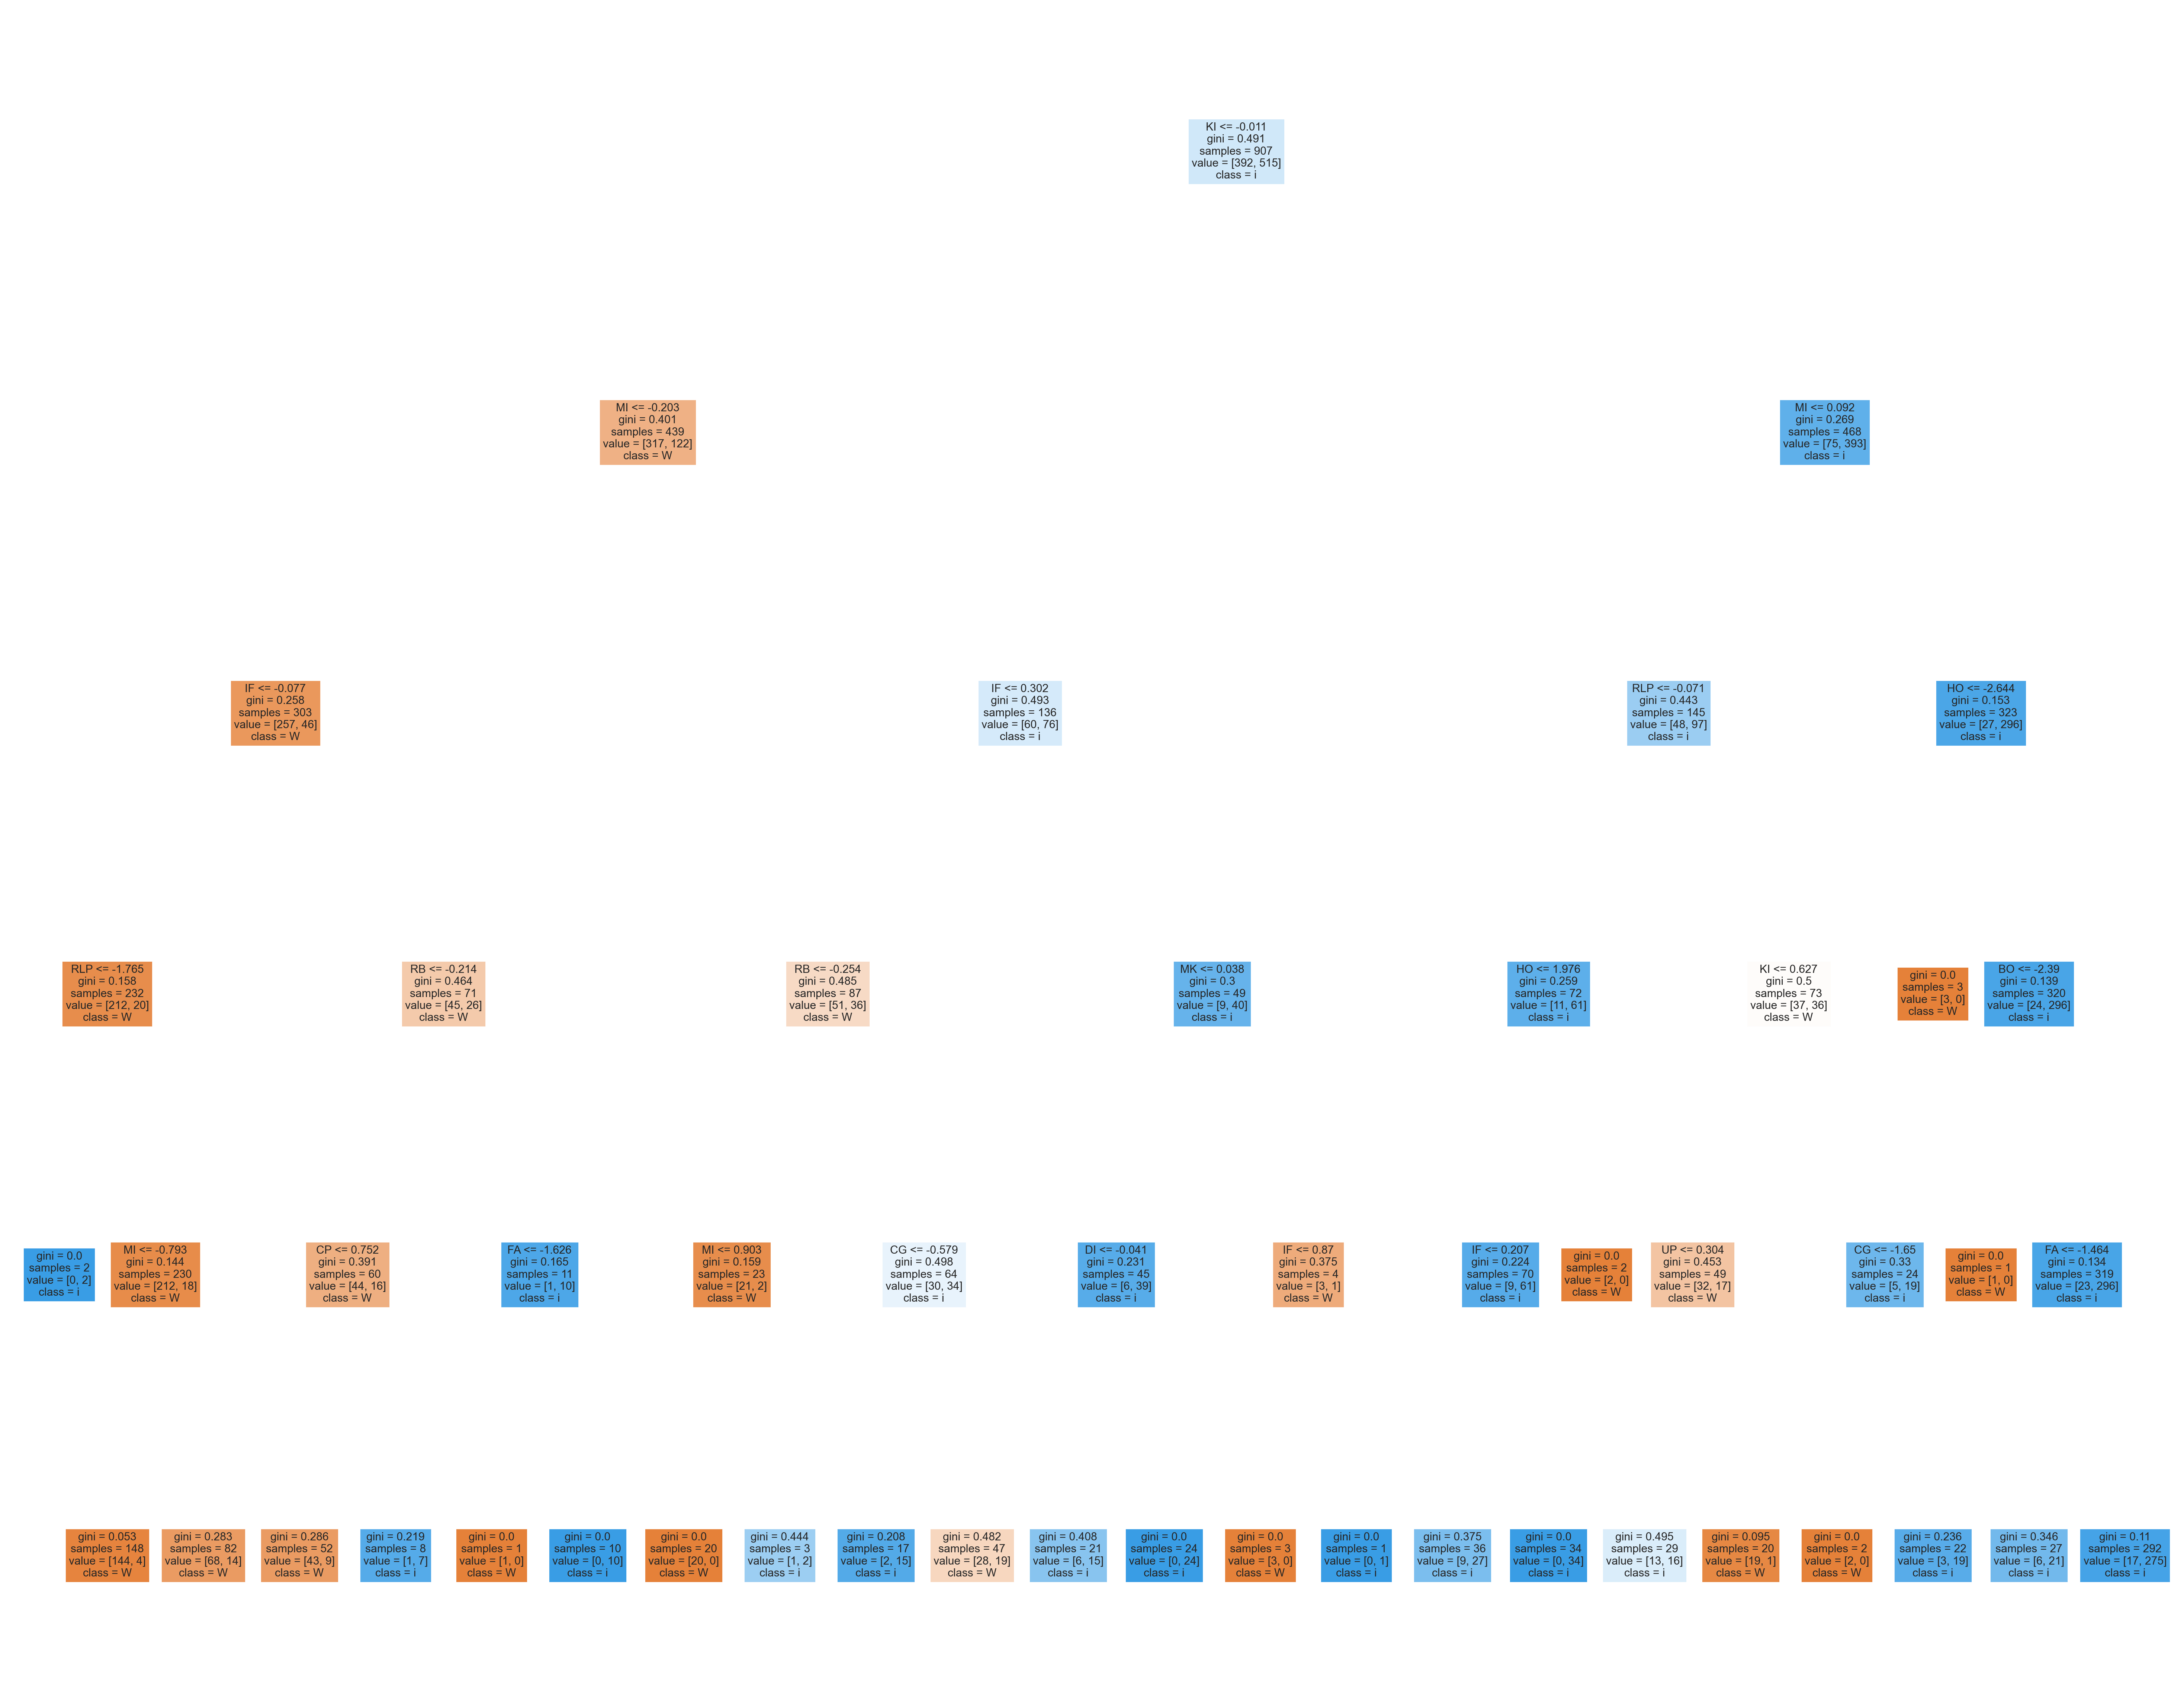

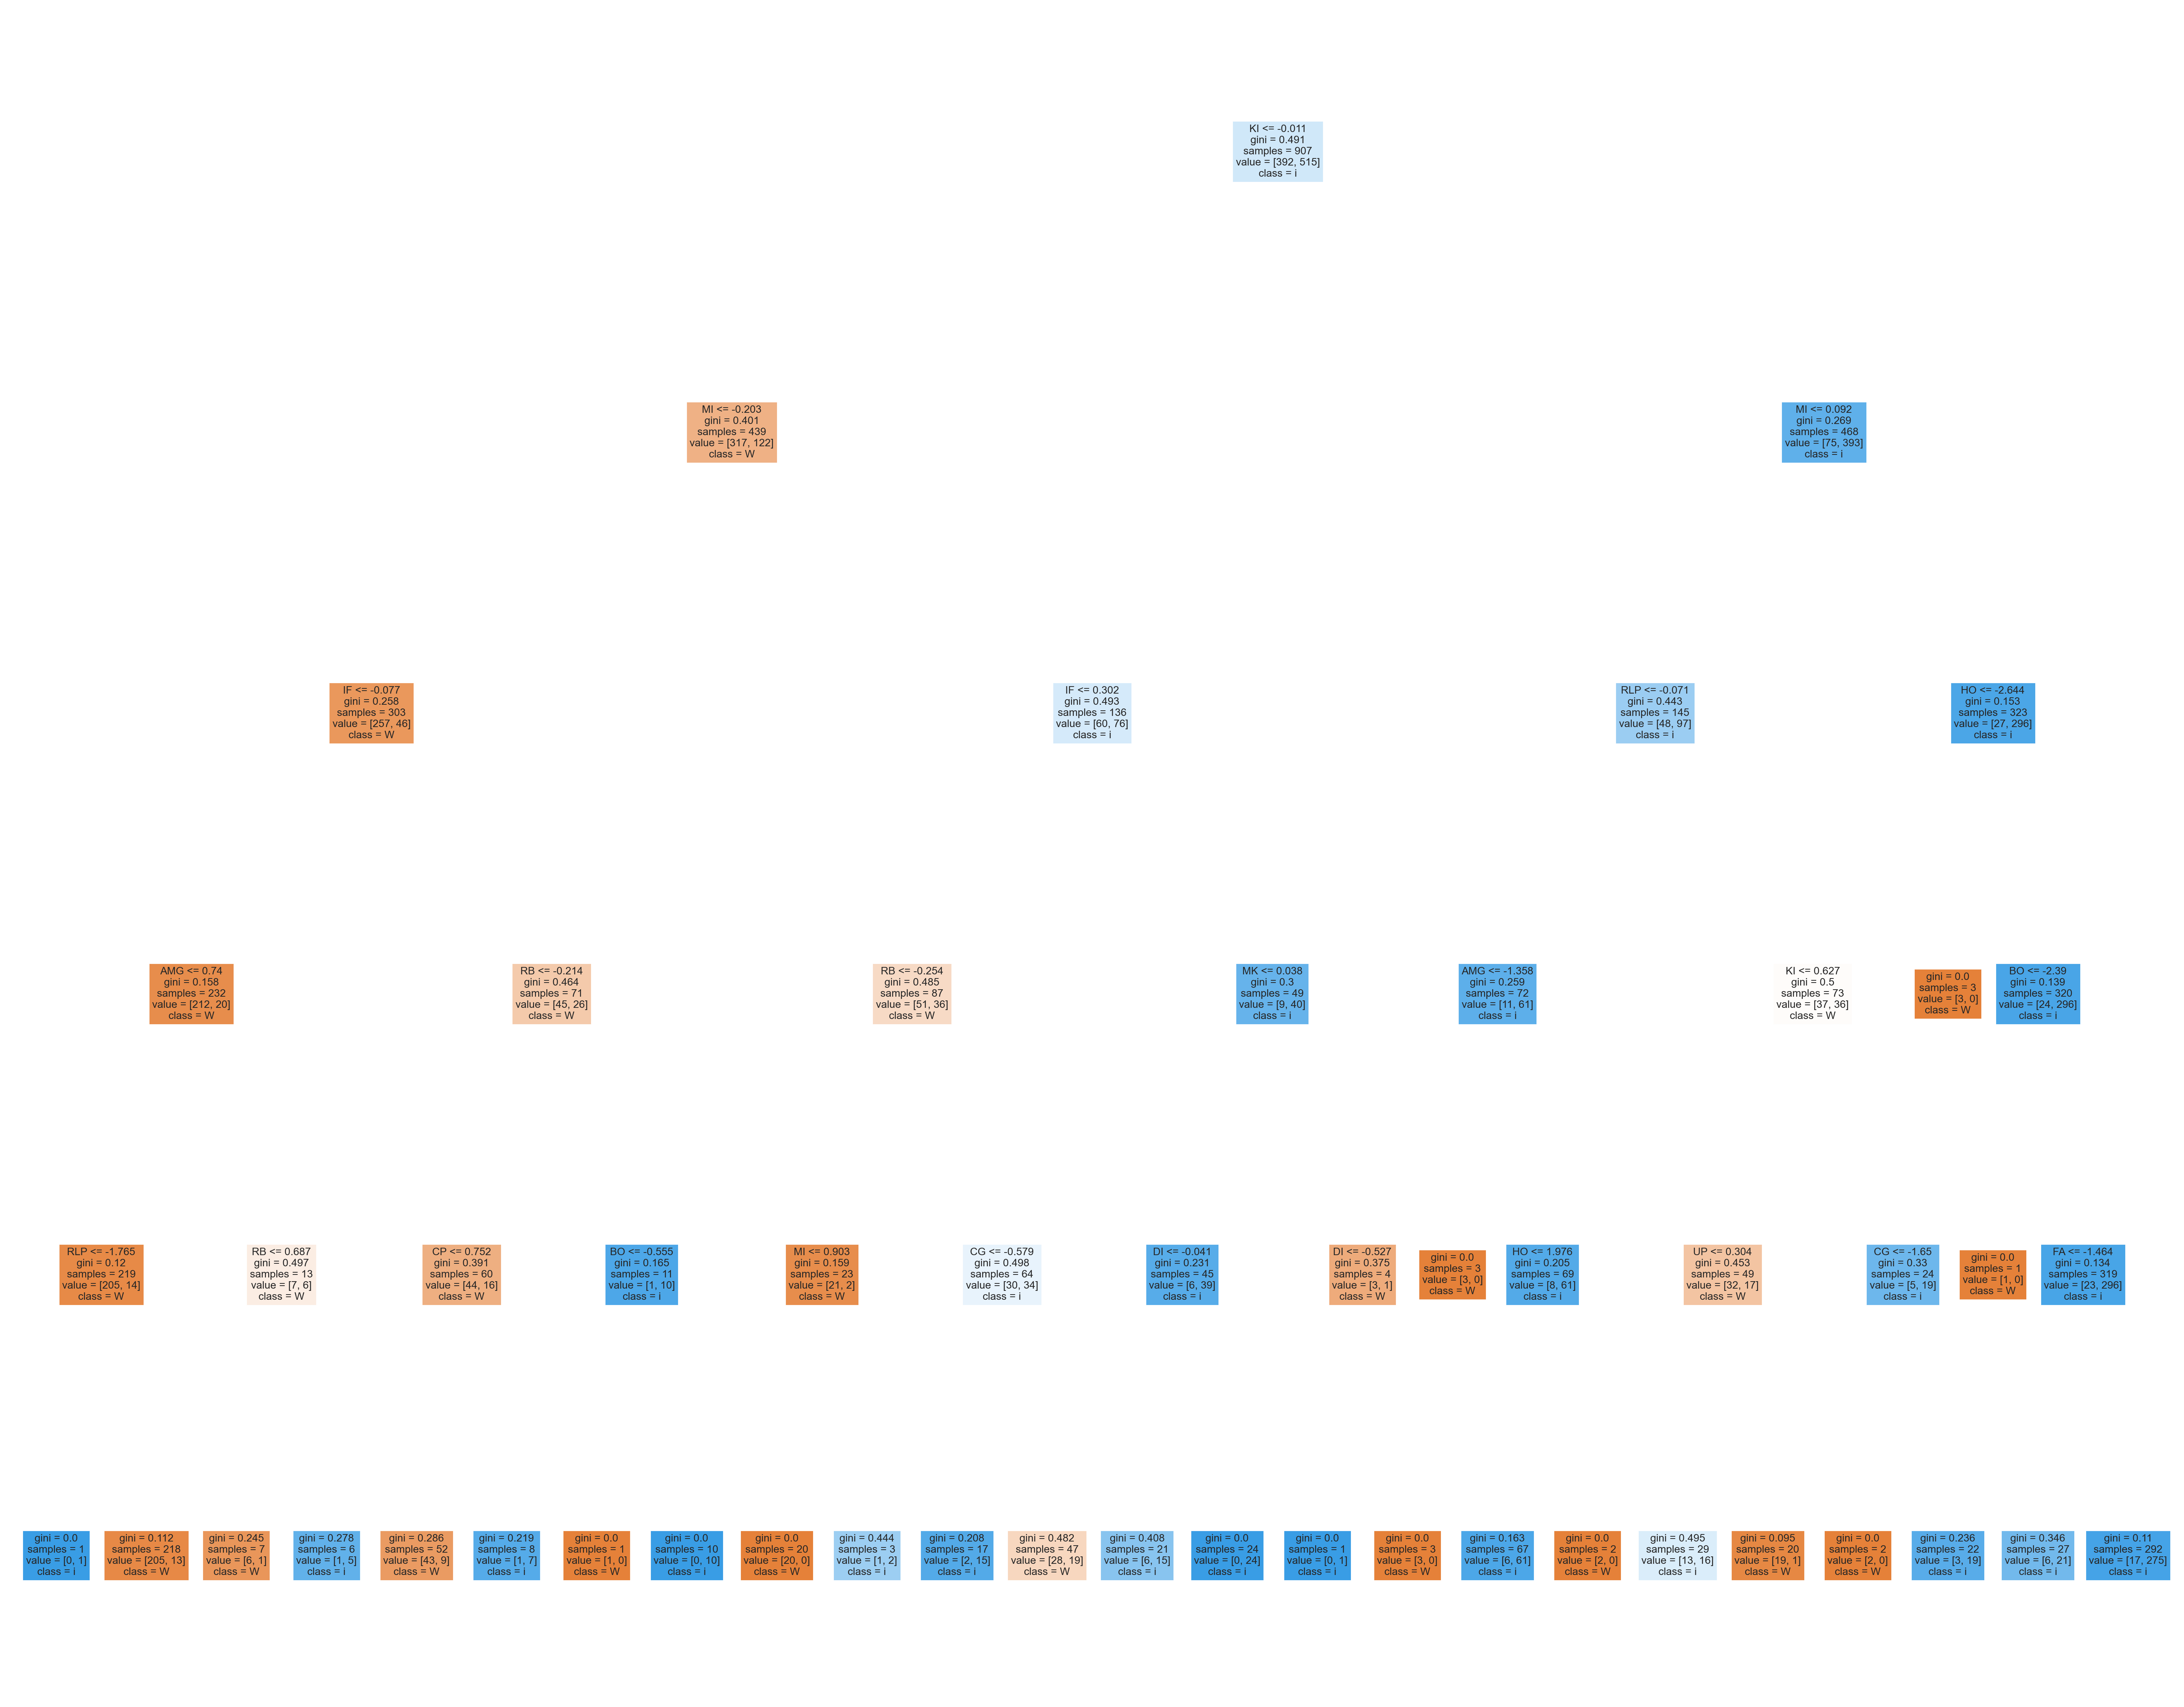

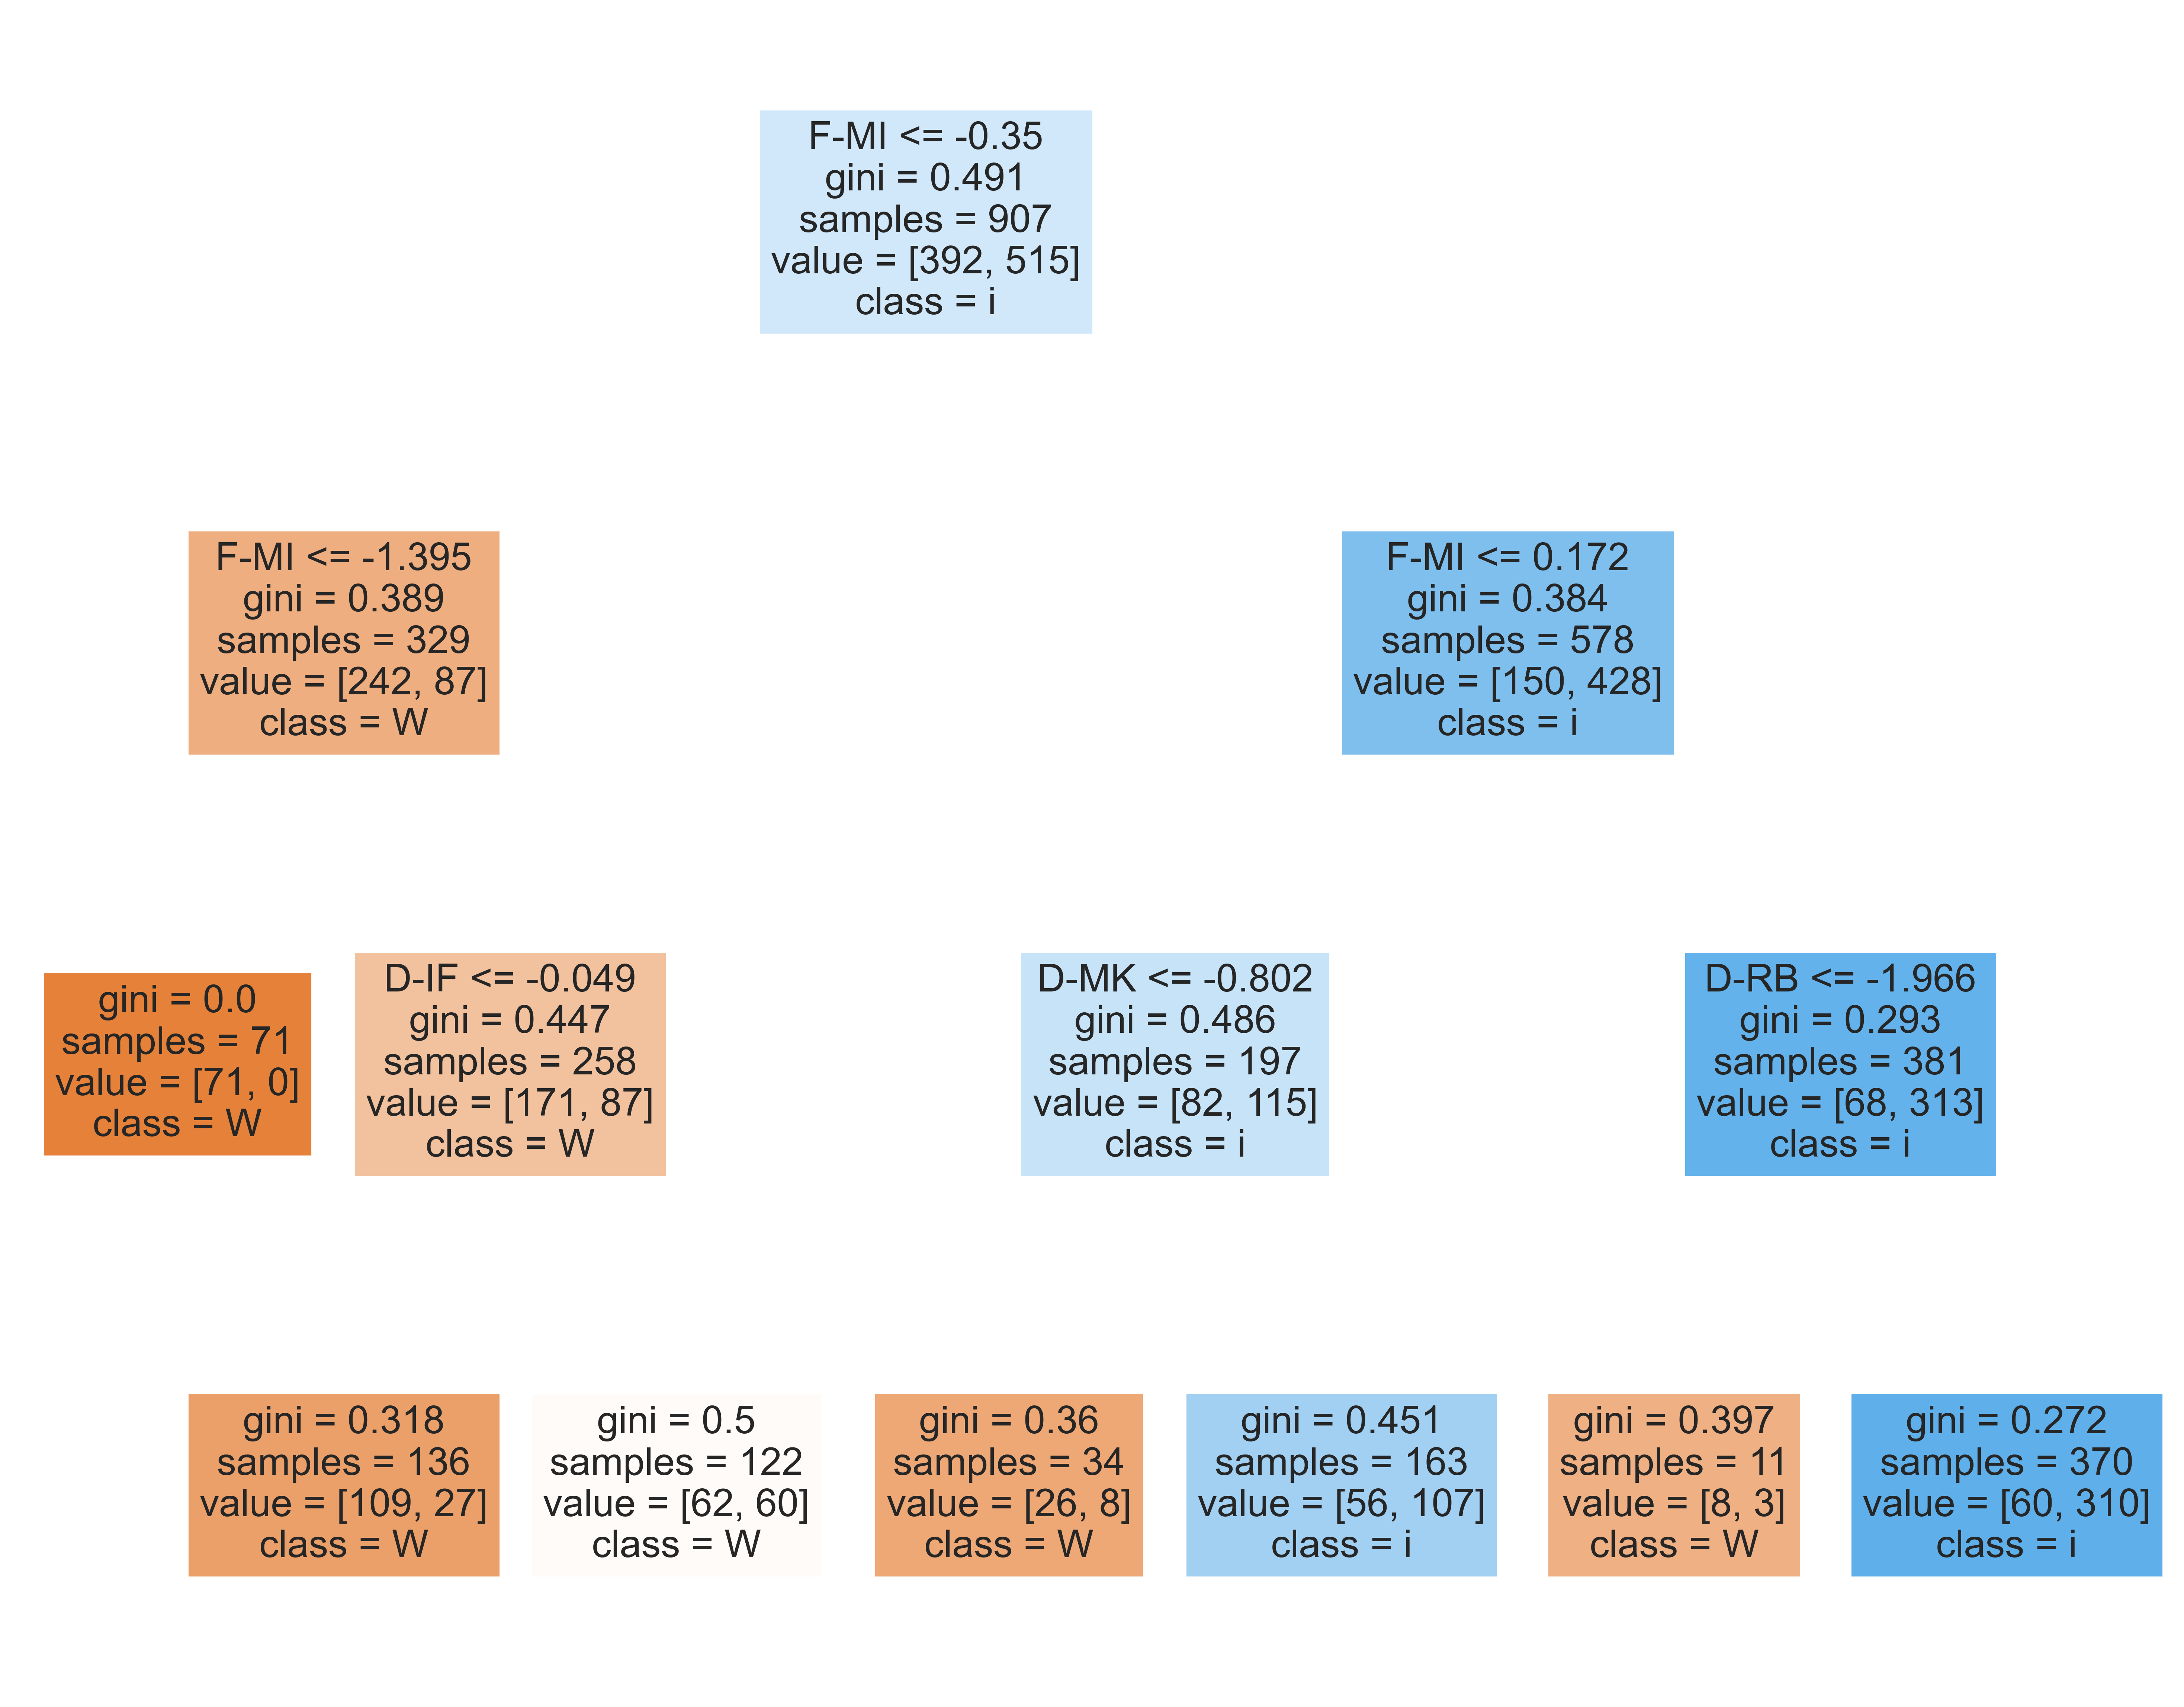

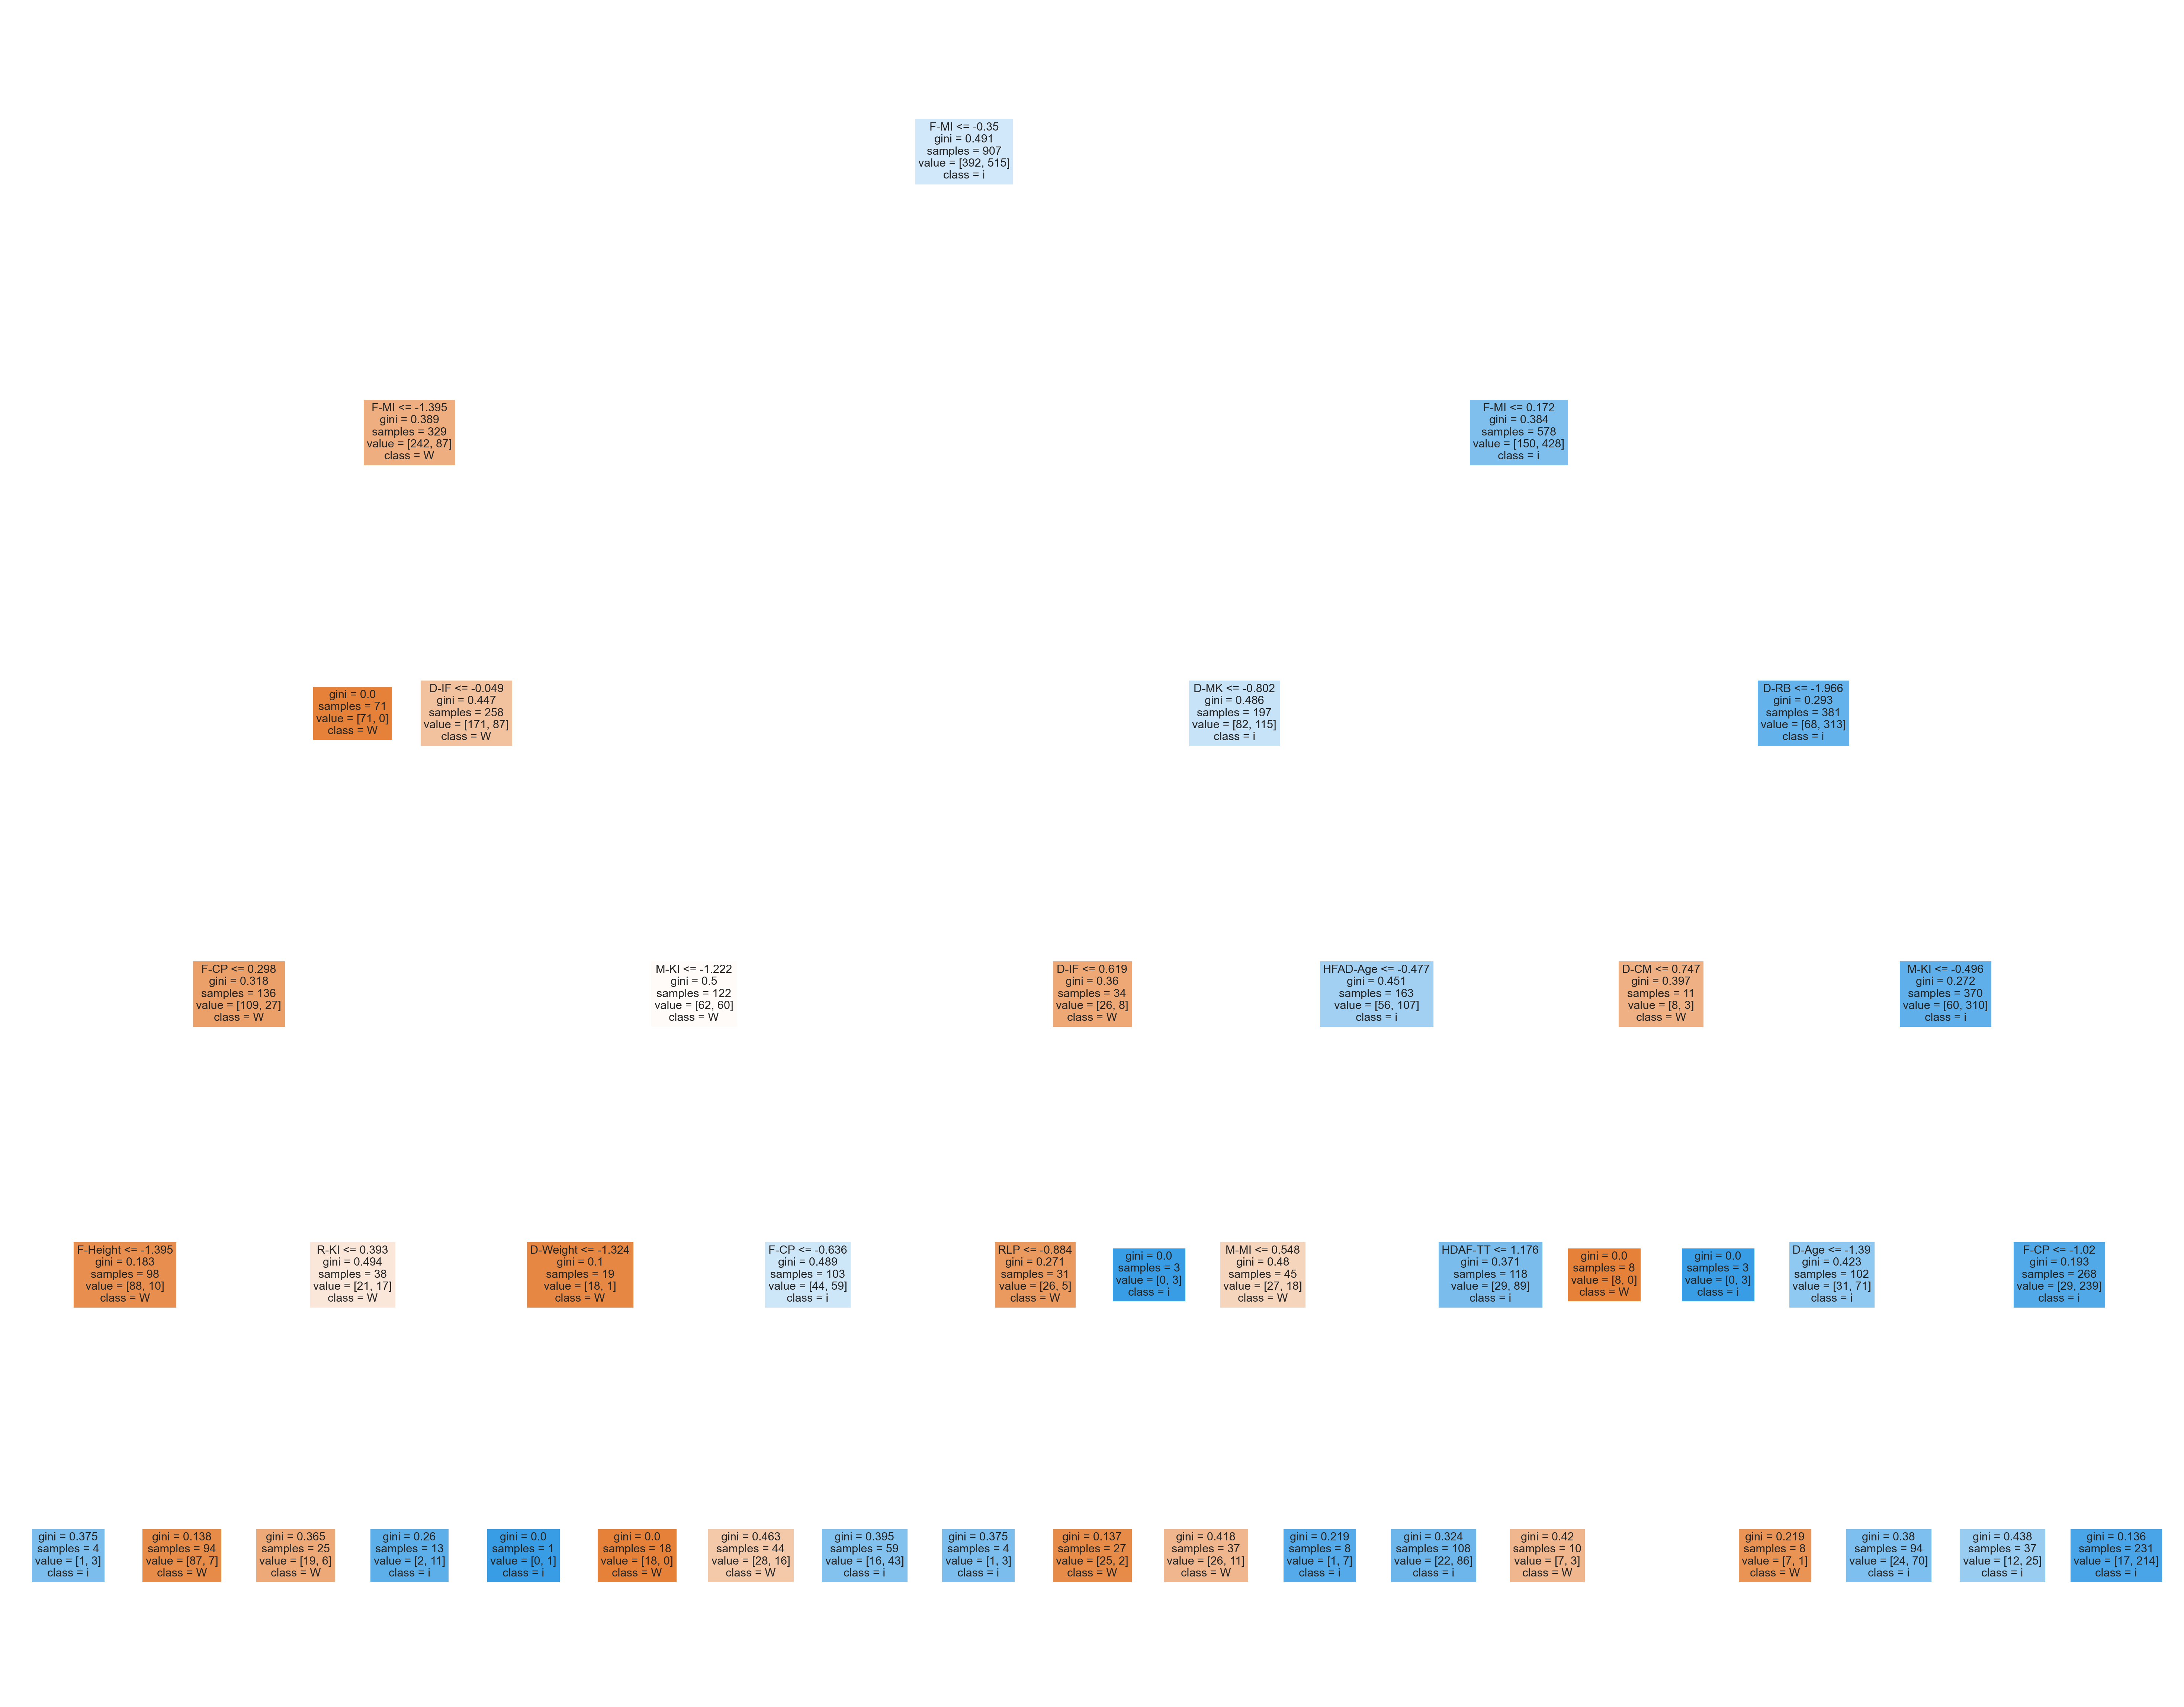

In [64]:
from sklearn import tree



for xtrs, ytr, xtes, yte, sample, xtrdfs, md in zip(Xtrainscaleds, ytrains, Xtestscaleds, 
                                                ytests, samples, Xtrainscaled_dfs, max_depths):
    clf = DecisionTreeClassifier(max_depth = md)

    clf.fit(xtrs, ytr)
    cn = xtrdfs.columns.to_list()
    fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (25,20), dpi=300)
    plt.title('Decision Tree plot for '+sample)
    tree.plot_tree(clf, feature_names = cn, class_names = 'Winner', filled = True);

    fig.savefig(sample+'.png')

In [65]:
# This may be interesting.  We'll have to see if it's useful or not.

# def explained_variance(xtrain_scaled_df, xtest_scaled_df):
#     D_train_subset, D_test_subset = [col for col in xtrain_scaled_df if col.startswith('D-')], [col for col in xtest_scaled_df if col.startswith('D-')]
#     D_train_scaled, D_test_scaled = xtrain_scaled_df[D_train_subset], xtest_scaled_df[D_test_subset]

#     F_train_subset, F_test_subset = [col for col in xtrain_scaled_df if col.startswith('F-')], [col for col in xtest_scaled_df if col.startswith('F-')]
#     F_train_scaled, F_test_scaled = xtrain_scaled_df[F_train_subset], xtest_scaled_df[F_test_subset]

#     M_train_subset, M_test_subset = [col for col in xtrain_scaled_df if col.startswith('M-')], [col for col in xtest_scaled_df if col.startswith('M-')]
#     M_train_scaled, M_test_scaled = xtrain_scaled_df[M_train_subset], xtest_scaled_df[M_test_subset]

#     R_train_subset, R_test_subset = [col for col in xtrain_scaled_df if col.startswith('R-')], [col for col in xtest_scaled_df if col.startswith('R-')]
#     R_train_scaled, R_test_scaled = xtrain_scaled_df[R_train_subset], xtest_scaled_df[R_test_subset]

#     HDAF_train_subset, HDAF_test_subset = [col for col in xtrain_scaled_df if col.startswith('HDAF-')], [col for col in xtest_scaled_df if col.startswith('HDAF-')]
#     HDAF_train_scaled, HDAF_test_scaled = xtrain_scaled_df[HDAF_train_subset], xtest_scaled_df[HDAF_test_subset]

#     HFAD_train_subset, HFAD_test_subset = [col for col in xtrain_scaled_df if col.startswith('HFAD-')], [col for col in xtest_scaled_df if col.startswith('HFAD-')]
#     HFAD_train_scaled, HFAD_test_scaled = xtrain_scaled_df[HFAD_train_subset], xtest_scaled_df[HFAD_test_subset]

#     C_train_subset, C_test_subset = xtrain_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], xtest_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]

#     pos_sub = [D_train_scaled, F_train_scaled, M_train_scaled, R_train_scaled, C_train_subset]
#     pos_list = ['Defender', 'Forward', 'Midfield', 'Ruck', 'Categoricals']


#     for ps, pl in zip(pos_sub, pos_list):

#         clf.fit(ps, xtrain_scaled_df.iloc[:,-1])
    
#         fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (3,3), dpi=300)
#         cn = pg.columns.to_list()
#         tree.plot_tree(clf, feature_names = cn, class_names = 'Winner', filled = True);
    

# #     fig.savefig('Defense_decision_tree.png')

# Random Forest Classifier

Sample 0 accuracy is:  0.8502202643171806
Sample 0 ROC_AUC value =  0.9107736117702895
   Feature  Importance
16      MI    0.144898
2       KI    0.143873
8       IF    0.089339
13      CP    0.071640
1       DI    0.065179
14      UP    0.053170
3       MK    0.051533
0      RLP    0.041530
7       RB    0.039653
10      CG    0.037586


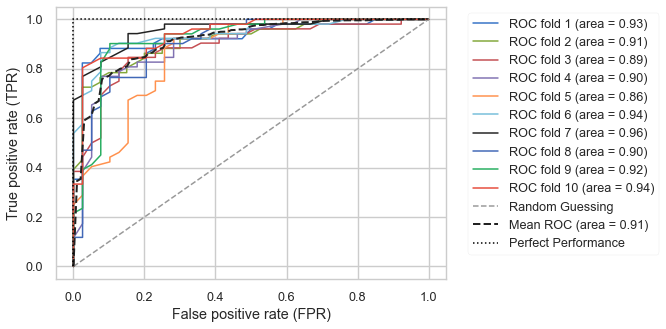

Sample 1 accuracy is:  0.8414096916299559
Sample 1 ROC_AUC value =  0.9193165638348363
   Feature  Importance
2       KI    0.173517
16      MI    0.145425
8       IF    0.077130
1       DI    0.060279
13      CP    0.055446
3       MK    0.051862
19     AMG    0.043899
14      UP    0.043558
0      RLP    0.040664
10      CG    0.038159


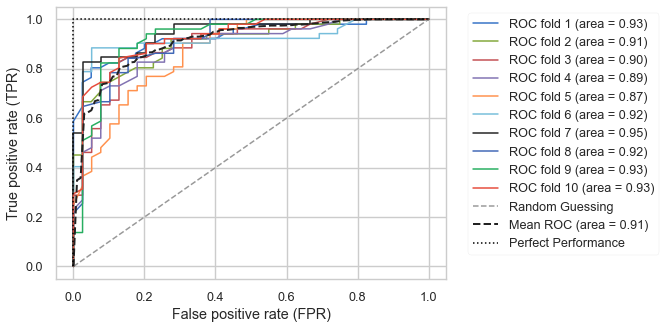

Sample 2 accuracy is:  0.8634361233480177
Sample 2 ROC_AUC value =  0.9038917892738491
    Feature  Importance
37     F-MI    0.095692
0       RLP    0.033091
29     F-IF    0.031613
85  HFAD-TM    0.029265
50     M-IF    0.024511
92  HDAF-TM    0.024134
3      D-MK    0.021486
23     F-KI    0.021072
2      D-KI    0.020894
44     M-KI    0.017842


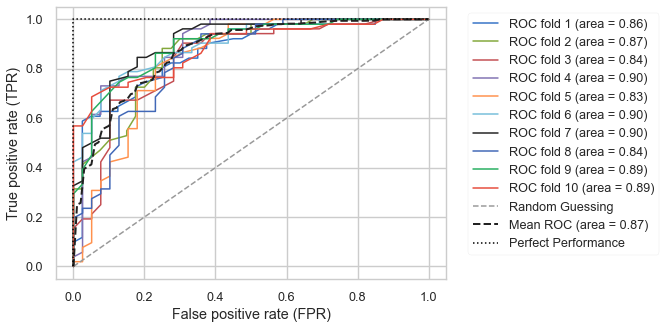

Sample 3 accuracy is:  0.8414096916299559
Sample 3 ROC_AUC value =  0.9143727258345199
    Feature  Importance
38     F-MI    0.091852
30     F-IF    0.032039
96  HDAF-TM    0.027548
0       RLP    0.024757
52     M-IF    0.024560
24     F-KI    0.020968
2      D-KI    0.020143
89  HFAD-TM    0.019916
46     M-KI    0.018970
3      D-MK    0.018405


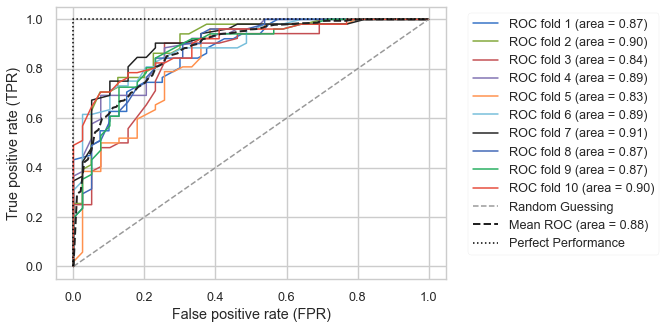

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

xtrs_df = [X0_train_scaled_df.iloc[:,:-1], X1_train_scaled_df.iloc[:,:-1], X2_train_scaled_df.iloc[:,:-1], X3_train_scaled_df.iloc[:,:-1]]
xtes_df = [X0_test_scaled_df.iloc[:,:-1], X1_test_scaled_df.iloc[:,:-1], X2_test_scaled_df.iloc[:,:-1], X3_test_scaled_df.iloc[:,:-1]]

rf_importance_dfs = []

rf_test_accuracies = []

for xtr, xte, ytr, yte, samp, xts in zip(Xtrainscaleds, Xtestscaleds, ytrains, ytests, samples, xtrs_df):

    model = RandomForestClassifier(n_estimators = 100, bootstrap = True)

    model.fit(xtr, ytr)
    predictions = model.predict(xte)
    probas = model.predict_proba(xte)[:,1]
    
    accuracy = accuracy_score(yte, predictions)
    rf_test_accuracies.append(accuracy)

    roc_value = roc_auc_score(yte, probas)

    print(samp+' accuracy is: ',accuracy)
    print(samp+' ROC_AUC value = ',roc_value)
    key_features = pd.DataFrame({'Feature': list(xts.columns),
                                'Importance': model.feature_importances_}).sort_values('Importance', ascending = False)
    print(key_features.head(10))
    rf_importance_dfs.append(key_features)
    
    kfold = StratifiedKFold(n_splits = 10).split(xtr, ytr)
    
    cv = list(kfold)
    
    fig = plt.figure(figsize = (7, 5))
    
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    app_tpr = []
    
    for i, (train, test) in enumerate(cv):
        probas = model.fit(xtr[train], ytr[train]).predict_proba(xtr[test])
        fpr, tpr, thresholds = roc_curve(ytr[test], probas[:, 1], pos_label = 1)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label = 'ROC fold %d (area = %0.2f)'%(i+1, roc_auc))
    
    plt.plot([0,1], [0,1], linestyle = '--', color = (0.6, 0.6, 0.6), label = 'Random Guessing')
    
    mean_tpr/= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    
    plt.plot(mean_fpr, mean_tpr, 'k--', label = 'Mean ROC (area = %0.2f)'%mean_auc, lw = 2)
    plt.plot([0,0,1], [0,1,1], linestyle = ':', color = 'black', label = 'Perfect Performance')
    
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False positive rate (FPR)')
    plt.ylabel('True positive rate (TPR)')
#     plt.legend(loc = 'lower right')
    plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.show()


# Create a reduced list of important features based on commonalities between TTest and Random Forest analysis

In [67]:
reduced_feature_list = []
for n in range(4):
    ttest_df_step1 = pd.DataFrame.from_records(list_of_series_lists[n],columns=['Feature', 'TTest'])
    ttest_df_step1['TTest'] = ttest_df_step1['TTest'].abs()
    ttest_df_step2 = ttest_df_step1.sort_values('TTest', ascending = False)
    
    if len(ttest_df_step1) > 25:
        
        df_1 = ttest_df_step2.head(25)
        df_2 = rf_importance_dfs[n].head(25)
    
    else:
        
        df_1 = ttest_df_step2.head(15)
        df_2 = rf_importance_dfs[n].head(15)
        
    reduced_df_1 = df_1[df_1['Feature'].isin(df_2['Feature'])]
    reduced_features = reduced_df_1['Feature'].to_list()
    
    reduced_feature_list.append(reduced_features)

In [68]:
reduced_scaled_train_dfs = []
reduced_scaled_train_arrays = []

reduced_scaled_test_dfs = []
reduced_scaled_test_arrays = []

for n in range(4):
    reduced_scaled_tr_df = xtrs_df[n][reduced_feature_list[n]]
    reduced_scaled_tr_array = reduced_scaled_tr_df.to_numpy()
    
    reduced_scaled_train_dfs.append(reduced_scaled_tr_df)
    reduced_scaled_train_arrays.append(reduced_scaled_tr_array)
    
    reduced_scaled_te_df = xtes_df[n][reduced_feature_list[n]]
    reduced_scaled_te_array = reduced_scaled_te_df.to_numpy()
    
    reduced_scaled_test_dfs.append(reduced_scaled_te_df)
    reduced_scaled_test_arrays.append(reduced_scaled_te_array)

# Re-running classifiers on reduced feature set

# Naive Bayes

In [69]:
# The reduced data sets
nb_train_accuracies_reduced = []
nb_test_accuracies_reduced = []

for xtrs, ytr, xtes, yte, sample in zip(reduced_scaled_train_arrays, ytrains, reduced_scaled_test_arrays, ytests, samples):
    naive_bayes(xtrs, ytr, xtes, yte, sample)
    
    nb_train_accuracies_reduced.append(naive_bayes.nb_full_train_accuracy)
    nb_test_accuracies_reduced.append(naive_bayes.nb_full_test_accuracy)
    

The baseline training accuracy with Naive Bayes on the complete Sample 0 is: 0.8037486218302095
The baseline accuracy on the test set with Naive Bayes on the complete Sample 0 is: 0.7973568281938326


The baseline training accuracy with Naive Bayes on the complete Sample 1 is: 0.8224917309812569
The baseline accuracy on the test set with Naive Bayes on the complete Sample 1 is: 0.8237885462555066


The baseline training accuracy with Naive Bayes on the complete Sample 2 is: 0.7839029768467475
The baseline accuracy on the test set with Naive Bayes on the complete Sample 2 is: 0.8061674008810573


The baseline training accuracy with Naive Bayes on the complete Sample 3 is: 0.7883131201764058
The baseline accuracy on the test set with Naive Bayes on the complete Sample 3 is: 0.8193832599118943




In [70]:
# but make a deep copy of each one so that I can use it for future comparison.
# as soon as I call the function on the reduced set it's going to overwrite the variables in memory.

for n in range(4):
    
    if nb_train_accuracies[n] > nb_train_accuracies_reduced[n]:
        print('The full train dataset performs better than the reduced dataset for Sample '+str(n))
    else:
        print('The reduced train dataset performs better than the full dataset for Sample '+str(n))
        
    if nb_test_accuracies[n] > nb_train_accuracies_reduced[n]:
        print('The full test dataset performs better than the reduced dataset for Sample '+str(n))
    else:
        print('The reduced test dataset performs better than the full dataset for Sample '+str(n))

The full train dataset performs better than the reduced dataset for Sample 0
The full test dataset performs better than the reduced dataset for Sample 0
The reduced train dataset performs better than the full dataset for Sample 1
The full test dataset performs better than the reduced dataset for Sample 1
The full train dataset performs better than the reduced dataset for Sample 2
The full test dataset performs better than the reduced dataset for Sample 2
The full train dataset performs better than the reduced dataset for Sample 3
The full test dataset performs better than the reduced dataset for Sample 3


In [71]:
# The original data sets

# campagnolo

nb_train_accuracies_reduced = []
nb_test_accuracies_reduced = []

for xtrs, ytr, xtes, yte, sample in zip(reduced_scaled_train_arrays, ytrains, reduced_scaled_test_arrays, ytests, samples):
    naive_bayes(xtrs, ytr, xtes, yte, sample)
    
    nb_train_accuracies_reduced.append(naive_bayes.nb_full_train_accuracy)
    nb_test_accuracies_reduced.append(naive_bayes.nb_full_test_accuracy)

The baseline training accuracy with Naive Bayes on the complete Sample 0 is: 0.8037486218302095
The baseline accuracy on the test set with Naive Bayes on the complete Sample 0 is: 0.7973568281938326


The baseline training accuracy with Naive Bayes on the complete Sample 1 is: 0.8224917309812569
The baseline accuracy on the test set with Naive Bayes on the complete Sample 1 is: 0.8237885462555066


The baseline training accuracy with Naive Bayes on the complete Sample 2 is: 0.7839029768467475
The baseline accuracy on the test set with Naive Bayes on the complete Sample 2 is: 0.8061674008810573


The baseline training accuracy with Naive Bayes on the complete Sample 3 is: 0.7883131201764058
The baseline accuracy on the test set with Naive Bayes on the complete Sample 3 is: 0.8193832599118943




Overall, with Naive Bayes there is no great improvement from reducing the feature set.  It still does pretty well, but less doesn't add up to better performance - it really has no significant effect.

# Logistic Regression

In [72]:
# The reduced data sets

lr_train_accuracies_reduced = []
lr_test_accuracies_reduced = []

for xtrs, ytr, xtes, yte, sample in zip(reduced_scaled_train_arrays, ytrains, reduced_scaled_test_arrays, ytests, samples):
    log_grid_pipeline(xtrs, ytr, xtes, yte, sample)
    
    lr_train_accuracies_reduced.append(log_grid_pipeline.scores_train)
    lr_test_accuracies_reduced.append(log_grid_pipeline.scores_test)

Best parameters for original reduction on Sample 0
0.8876190476190476
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.892, Test Acc.: 0.901
Fold:  2, Class dist.: [352 464], Train Acc.: 0.887, Test Acc.: 0.912
Fold:  3, Class dist.: [353 463], Train Acc.: 0.893, Test Acc.: 0.857
Fold:  4, Class dist.: [353 463], Train Acc.: 0.895, Test Acc.: 0.813
Fold:  5, Class dist.: [353 463], Train Acc.: 0.896, Test Acc.: 0.857
Fold:  6, Class dist.: [353 463], Train Acc.: 0.898, Test Acc.: 0.857
Fold:  7, Class dist.: [353 463], Train Acc.: 0.885, Test Acc.: 0.934
Fold:  8, Class dist.: [353 464], Train Acc.: 0.892, Test Acc.: 0.878
Fold:  9, Class dist.: [353 464], Train Acc.: 0.886, Test Acc.: 0.922
Fold: 10, Class dist.: [353 464], Train Acc.: 0.889, Test Acc.: 0.900

CV Train accuracy: 0.889 +/-0.000
CV Test accuracy: 0.900 +/-0.000
Best parameters for original reduction on Sample 1
0.8876190476190476
{'C': 1.0, 'penalty': 'l1'}
Fold:  1, Class dist.: [352 464], Tr

In [73]:
# The original data sets

for n in range(4):
    
    if lr_train_accuracies[n] > lr_train_accuracies_reduced[n]:
        print('The full train dataset performs better than the reduced dataset for Sample '+str(n))
    else:
        print('The reduced train dataset performs better than the full dataset for Sample '+str(n))
        
    if lr_test_accuracies[n] > lr_train_accuracies_reduced[n]:
        print('The full test dataset performs better than the reduced dataset for Sample '+str(n))
    else:
        print('The reduced test dataset performs better than the full dataset for Sample '+str(n))

The full train dataset performs better than the reduced dataset for Sample 0
The full test dataset performs better than the reduced dataset for Sample 0
The full train dataset performs better than the reduced dataset for Sample 1
The full test dataset performs better than the reduced dataset for Sample 1
The full train dataset performs better than the reduced dataset for Sample 2
The full test dataset performs better than the reduced dataset for Sample 2
The full train dataset performs better than the reduced dataset for Sample 3
The full test dataset performs better than the reduced dataset for Sample 3


Here again, the performance on the reduced sample, which I THOUGHT would be better, just simply isn't.

# Support Vector Machines

In [74]:
# The reduced data sets

svc_train_accuracies_reduced = []
svc_test_accuracies_reduced = []

for xtrs, ytr, xtes, yte, sample in zip(reduced_scaled_train_arrays, ytrains, reduced_scaled_test_arrays, ytests, samples):

    svc_grid_pipeline(xtrs, ytr, xtes, yte, sample)
    
    svc_train_accuracies_reduced.append(svc_grid_pipeline.train_accuracies)
    svc_test_accuracies_reduced.append(svc_grid_pipeline.test_accuracies)
    
    

The best score and parameters, and overall accuracy for Sample 0 are:

0.8853846153846154
{'svc__C': 10.0, 'svc__kernel': 'linear'}
Fold:  1, Class dist.: [352 464], Train Acc.: 0.888, Test Acc.: 0.912
Fold:  2, Class dist.: [352 464], Train Acc.: 0.892, Test Acc.: 0.901
Fold:  3, Class dist.: [353 463], Train Acc.: 0.891, Test Acc.: 0.846
Fold:  4, Class dist.: [353 463], Train Acc.: 0.896, Test Acc.: 0.824
Fold:  5, Class dist.: [353 463], Train Acc.: 0.895, Test Acc.: 0.857
Fold:  6, Class dist.: [353 463], Train Acc.: 0.893, Test Acc.: 0.868
Fold:  7, Class dist.: [353 463], Train Acc.: 0.887, Test Acc.: 0.945
Fold:  8, Class dist.: [353 464], Train Acc.: 0.894, Test Acc.: 0.878
Fold:  9, Class dist.: [353 464], Train Acc.: 0.884, Test Acc.: 0.911
Fold: 10, Class dist.: [353 464], Train Acc.: 0.887, Test Acc.: 0.911

CV Train accuracy: 0.887 +/-0.000
CV Test accuracy: 0.911 +/-0.000


The best score and parameters, and overall accuracy for Sample 1 are:

0.8478632478632478
{'svc__C

In [75]:
for n in range(4):
    
    if svc_train_accuracies[n] > svc_train_accuracies_reduced[n]:
        print('The full train dataset performs better than the reduced dataset for Sample '+str(n))
    else:
        print('The reduced train dataset performs better than the full dataset for Sample '+str(n))
        
    if svc_test_accuracies[n] > svc_train_accuracies_reduced[n]:
        print('The full test dataset performs better than the reduced dataset for Sample '+str(n))
    else:
        print('The reduced test dataset performs better than the full dataset for Sample '+str(n))

The reduced train dataset performs better than the full dataset for Sample 0
The full test dataset performs better than the reduced dataset for Sample 0
The full train dataset performs better than the reduced dataset for Sample 1
The reduced test dataset performs better than the full dataset for Sample 1
The full train dataset performs better than the reduced dataset for Sample 2
The reduced test dataset performs better than the full dataset for Sample 2
The reduced train dataset performs better than the full dataset for Sample 3
The reduced test dataset performs better than the full dataset for Sample 3


# XGboost

In [76]:
# pip install xgboost

In [77]:
# from sklearn import datasets
import xgboost as xgb

In [78]:
# It works on arrays, not DataFrames

D_trains = []
D_tests = []

for xtrs, ytr, xtes, yte, sample in zip(Xtrainscaleds, ytrains, Xtestscaleds, ytests, samples):
    
    D_train = xgb.DMatrix(xtrs, label = ytr)
    D_test = xgb.DMatrix(xtes, label = yte)
    
    D_trains.append(D_train)
    D_tests.append(D_test)

In [79]:
param = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'multi:softprob',
    'eval_metric': 'mlogloss',
    'num_class': 2}

steps = 20

In [80]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

xgboost_test_accuracies = []

for n in range(4):
    xgb_model = xgb.train(param, D_trains[n], steps)

    test_preds = xgb_model.predict(D_tests[n])
    best_test_preds = np.asarray([np.argmax(line) for line in test_preds])
    
    print('Results for : '+samples[n])
    print('Precision = {}'.format(precision_score(ytests[n], best_test_preds, average = 'macro')))
    print('Recall = {}'.format(recall_score(ytests[n], best_test_preds, average = 'macro')))
    print('Accuracy = {}'.format(accuracy_score(ytests[n], best_test_preds)))
    print('\n')
    
    xgboost_test_accuracy = accuracy_score(ytests[n], best_test_preds)
    
    xgboost_test_accuracies.append(xgboost_test_accuracy)

Results for : Sample 0
Precision = 0.8488916256157635
Recall = 0.836141433317513
Accuracy = 0.8458149779735683


Results for : Sample 1
Precision = 0.8619604316546763
Recall = 0.8502214839424141
Accuracy = 0.8590308370044053


Results for : Sample 2
Precision = 0.835620285668432
Recall = 0.8308416389811739
Accuracy = 0.8370044052863436


Results for : Sample 3
Precision = 0.8251387787470261
Recall = 0.8243157728207562
Accuracy = 0.8281938325991189




In [81]:
xgboost_test_accuracies

[0.8458149779735683,
 0.8590308370044053,
 0.8370044052863436,
 0.8281938325991189]

In [82]:
# Pre-grid search

from xgboost import XGBClassifier

XGB_test_accuracies = []

for n in range(4):
#     xgb_model = xgb.train(param, D_trains[n], steps)

    XGB_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
    XGB_model.fit(Xtrainscaleds[n], ytrains[n])
    
    predictions = XGB_model.predict(Xtestscaleds[n])
    accuracy = accuracy_score(ytests[n], predictions)
    print('Test Accuracy: %.2f%%'%(accuracy))
    XGB_test_accuracies.append(accuracy)
    


Test Accuracy: 0.85%
Test Accuracy: 0.85%
Test Accuracy: 0.82%
Test Accuracy: 0.83%


In [83]:
# Grid Search

# from xgboost import XGBClassifier

# xgboost_test_accuracies_grid_search = []

# for n in range(4):
# #     xgb_model = xgb.train(param, D_trains[n], steps)

#     XGB_model = XGBClassifier(use_label_encoder = False, eval_metric = 'logloss')
#     n_estimators = range(50, 400, 50)
#     param_grid = dict(n_estimators = n_estimators)
#     kfold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 7)
#     grid_search = GridSearchCV(XGB_model, param_grid, scoring = 'neg_log_loss', n_jobs = -1, cv = kfold)
    
# #     grid_result = grid_search.fit(Xtrainscaleds[n], ytrains[n])
# #     grid_predictions = grid_search.fit(Xtestscaleds[n])
# #     grid_accuracy = accuracy_score(ytests[n], grid_predictions)
    
# #     print('Grid Test Accuracy: %.2ff%%'%(grid_accuracy))
    
#     # summarize results
#     print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_score']
#     stds = grid_result.cv_results_['std_test_score']
#     params = grid_result.cv_results_['params']
    
#     for mean, stdev, param in zip(means, stds, params):
#         print('%f (%f) with: %r'%(mean, stdev, param))
            
#     plt.errorbar(n_estimators, means, yerr=stds)
#     plt.title('XGBoost n_estimators vs. Log Loss')
#     plt.xlabel('n_estimators')
#     plt.ylabel('Log Loss')
#     plt.show()

    

# Multilayer Perceptron

In my early frustration with TensorFlow I wanted to establish a baseline with the NeuralNet MLP that we had built in 602.  There is back propagation in this model, but it's not as complicated as TF.

In [84]:
from urllib.request import urlretrieve

url = 'https://raw.githubusercontent.com/rasbt/python-machine-learning-book-3rd-edition/master/ch12/neuralnet.py'
urlretrieve(url, 'neuralnet.py')

from neuralnet import NeuralNetMLP

In [85]:
# len(Xtrainscaled_dfs[0].columns)
len(Xtrainscaleds[3][0])

106

Here, the hyperparameters are very clear and visible.  We can't do a grid search with this classifier, so I manipulated these hyperparameters a little bit manually, trying, unsuccessfully, to reduce loss.

I did create a validation subset inside of the training data.

In [86]:
nn = NeuralNetMLP(n_hidden = 10,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [87]:
def neural_network(xtrain, xtest, ytrain, ytest, sample):
    
    nn.fit(X_train = xtrain, y_train = ytrain, X_valid = xtest, y_valid = ytest)
    
    plt.plot(range(nn.epochs), nn.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Neural Network Classifier Cost for '+ sample)
    plt.show()
    
    plt.plot(range(nn.epochs), nn.eval_['train_acc'], label = 'training')
    plt.plot(range(nn.epochs), nn.eval_['valid_acc'], label = 'validation', linestyle = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer for'+ sample)
    plt.legend(loc = 'lower right')
    neural_network.train_accuracy = nn.eval_['train_acc'][-1]
    neural_network.test_accuracy = nn.eval_['valid_acc'][-1]
    plt.show()

In [88]:
nn2 = NeuralNetMLP(n_hidden = 75,
                 l2 = 0.01,
                 epochs = 200,
                 eta = 0.002,
                 minibatch_size = 50,
                 shuffle = True,
                 seed = 1)

In [89]:
def neural_network2(xtrain, xtest, ytrain, ytest, sample):
    
    nn2.fit(X_train = xtrain, y_train = ytrain, X_valid = xtest, y_valid = ytest)
    
    plt.plot(range(nn2.epochs), nn2.eval_['cost'])
    plt.ylabel('Cost')
    plt.xlabel('Epochs')
    plt.title('Neural Network Classifier Cost for '+ sample)
    plt.show()
    
    plt.plot(range(nn2.epochs), nn2.eval_['train_acc'], label = 'training')
    plt.plot(range(nn2.epochs), nn2.eval_['valid_acc'], label = 'validation', linestyle = '--')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.title('Training Accuracy v Validation Accuracy\nwith Neural Network classifer for'+ sample)
    plt.legend(loc = 'lower right')
    neural_network2.train_accuracy = nn2.eval_['train_acc'][-1]
    neural_network2.test_accuracy = nn2.eval_['valid_acc'][-1]
    plt.show()

200/200 | Cost: 449.10 | Train/Valid Acc.: 89.42%/88.11%  

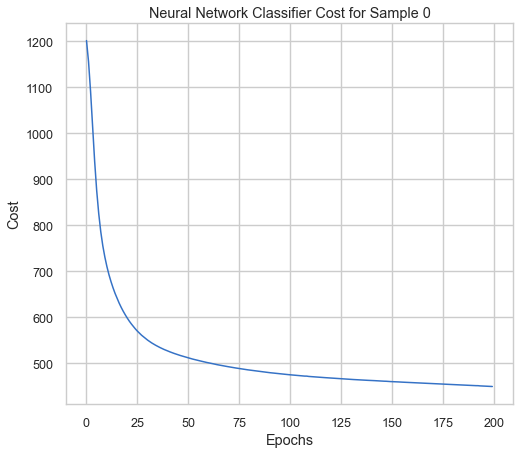

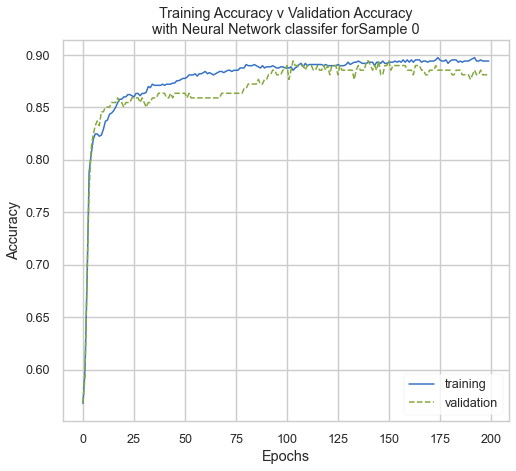

200/200 | Cost: 433.97 | Train/Valid Acc.: 89.75%/88.99%  

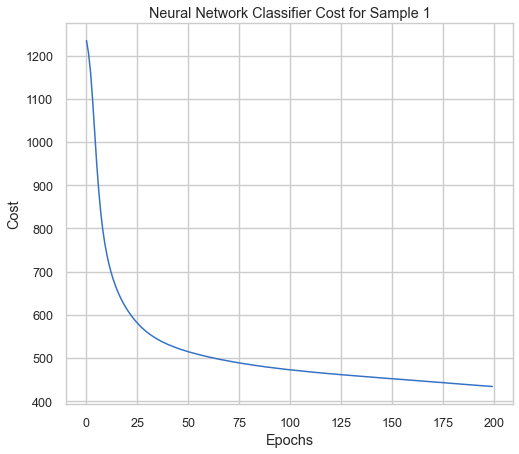

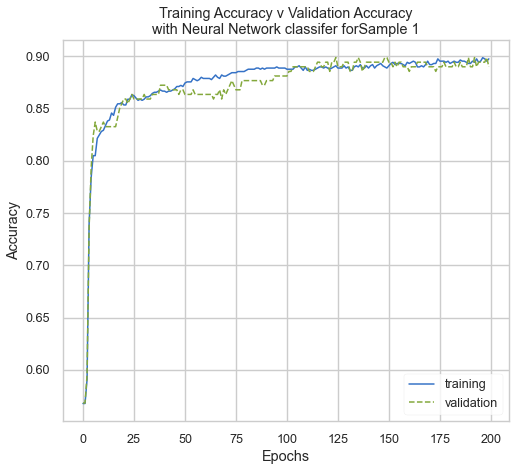

200/200 | Cost: 84.48 | Train/Valid Acc.: 99.89%/87.67%   

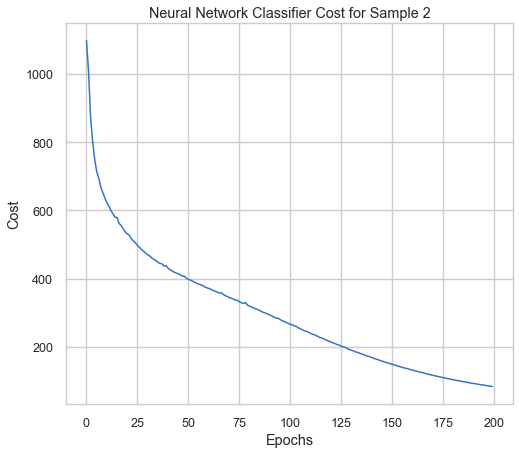

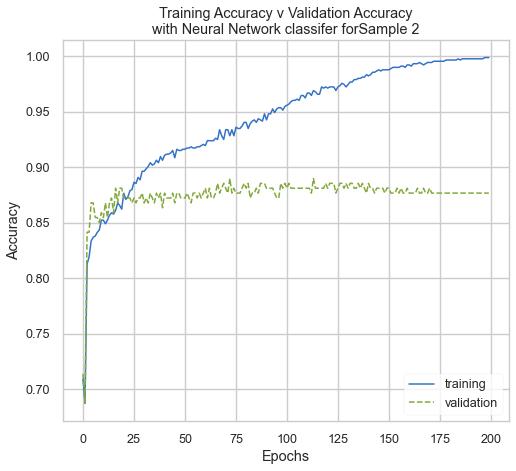

200/200 | Cost: 79.91 | Train/Valid Acc.: 99.89%/89.43%   

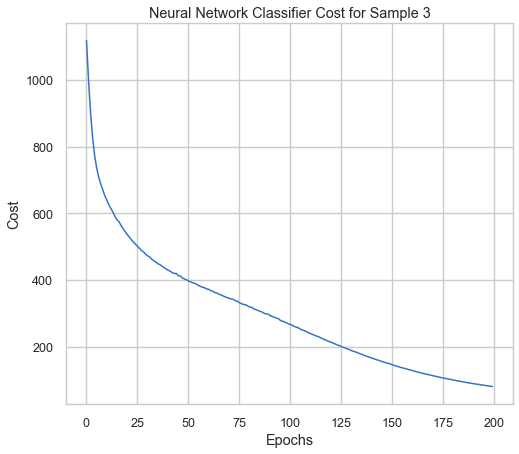

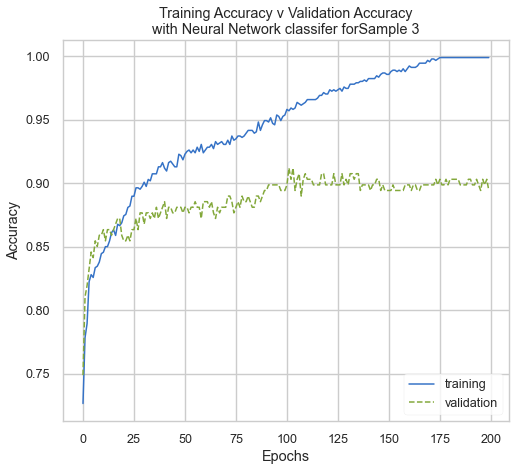

In [90]:
nn_train_accuracies = []
nn_test_accuracies = []



for n in range(4):
    
    if n < 2:
        neural_network(Xtrainscaleds[n], Xtestscaleds[n], ytrains[n], ytests[n], samples[n])
        
        nn_train_accuracies.append(neural_network.train_accuracy)
        nn_test_accuracies.append(neural_network.test_accuracy)
    else:
        neural_network2(Xtrainscaleds[n], Xtestscaleds[n], ytrains[n], ytests[n], samples[n])
        
        nn_train_accuracies.append(neural_network2.train_accuracy)
        nn_test_accuracies.append(neural_network2.test_accuracy)

    

In [91]:
# I am SERIOUSLY, SERIOUSLY, SERIOUSLY overtraining on the training data, but the baseline does a pretty good job.
# It sets the bench pretty high.

nn_test_accuracies

[0.8810572687224669,
 0.8898678414096917,
 0.8766519823788547,
 0.8942731277533039]

We definitely find a steady minimum for cost, but it seems so very high.

The class does not have a way to report on validation cost that I can see in the code.

OK, so observations here with the NN we built in class.  

This does exactly the same, about 86% on the validation set, and the cost is fairly low.  Again, validation probably needs to be reset to be the x_test set; it's just nomenclature. I don't have a separate test, just validation.

I am definitely getting better, but it's not perfect.  I'm still treating the dataframe as one big thing.

I'm definitely overtraining!

# TensorFlow setup

Everything that I've done so far was on my initial, "regular dataset".  I cut it up and put it back together, a bunch of times, but at least I have everything normalized the way I want with the  fit.

But, let's scrap that and start fresh with TensorFlow on my smallest dataframe possible, whatever we wind up with.

Essentially, I am using a TensorFlow tutorial (https://www.tensorflow.org/tutorials/keras/regression) to start fresh with a new, un-normalized dataframe.  In these next few cells I am following that TensorFlow example to work through the TensorFlow neural network model.  Of course, I have a classification problem, not a regression problem, so the tutorial was mostly useful in the setup process.

# This is where I start my TF with my data

In [92]:
# I want to go back to my Xn_train_scaled_df.  So I have put the target back on, so now I have to undo it a bit.

# This is critical.  I can't have the target in my X!


# What I want to do here is go back to the original unscaled dataframe and create a train / validation / test split.
# Then I want to fit_transform the train and just transform BOTH the validation and train samples.
# I want to use the validation set and then predict on the test set.

# X0, X1, X2, and X3
# y0, y1, y2, and y3 are my baselines

# Here I changed Home and Away to 1 and 0

tf_han_df0 = copy.deepcopy(han_df0)
tf_han_df1 = copy.deepcopy(han_df1)
tf_han_df2 = copy.deepcopy(han_df2)
tf_han_df3 = copy.deepcopy(han_df3)

le = LabelEncoder()
tf_han_df0['Winner'] = le.fit_transform(tf_han_df0['Winner'])
tf_han_df1['Winner'] = le.fit_transform(tf_han_df1['Winner'])
tf_han_df2['Winner'] = le.fit_transform(tf_han_df2['Winner'])
tf_han_df3['Winner'] = le.fit_transform(tf_han_df3['Winner'])

le.transform(['Home', 'Away'])


# y0_train = X0_train_scaled_df.pop('Winner')
# y1_train = X1_train_scaled_df.pop('Winner')
# y2_train = X2_train_scaled_df.pop('Winner')
# y3_train = X3_train_scaled_df.pop('Winner')

# y0_test = X0_test_scaled_df.pop('Winner')
# y1_test = X1_test_scaled_df.pop('Winner')
# y2_test = X2_test_scaled_df.pop('Winner')
# y3_test = X3_test_scaled_df.pop('Winner')

array([1, 0], dtype=int64)

In [93]:
tf_han_df3

Home         Away  Season   Game   Round   D-DI  D-KI  D-MK  \
594            Carlton     Richmond    2015  Game1  round1  -43.0 -13.0  -3.0   
595          Melbourne   Gold Coast    2015  Game2  round1  -32.0 -24.0  -9.0   
596             Sydney     Essendon    2015  Game3  round1   -1.0  -6.0  -7.0   
597           Brisbane  Collingwood    2015  Game4  round1  -22.0   1.0   9.0   
598   Western Bulldogs   West Coast    2015  Game5  round1   23.0  11.0  -2.0   
...                ...          ...     ...    ...     ...    ...   ...   ...   
1731   North Melbourne     Adelaide    2020  Game5  round9   37.0  40.0  23.0   
1732         St. Kilda       Sydney    2020  Game6  round9   43.0  33.0  37.0   
1733        West Coast      Geelong    2020  Game7  round9  -69.0 -55.0 -33.0   
1734        Gold Coast          GWS    2020  Game8  round9 -109.0 -86.0 -52.0   
1735         Fremantle  Collingwood    2020  Game9  round9   10.0   5.0   9.0   

      D-HB       D-HO  ...  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  \
594  -30.0   5.000000  ...      1.0    -2.050000    -1.950000  0.850000   
595   -8.0   3.000000  ...      6.0     2.071429     7.928571  4.142857   
596    5.0  -1.000000  ...    -18.0     2.017857     1.428571  0.767857   
597  -23.0  -1.000000  ...      2.0     5.714286    -1.857143 -1.285714   
598   12.0   0.000000  ...      0.0    -2.690476    -0.452381  3.714286   
...    ...        ...  ...      ...          ...          ...       ...   
1731   1.0  12.000000  ...      5.0     4.232143     6.375000  4.553571   
1732   8.0 -12.000000  ...     16.0     4.208333     3.527778  0.722222   
1733 -14.0  -2.333333  ...    -23.0     2.250000    -5.375000 -0.750000   
1734 -23.0  -1.000000  ...     -4.0     2.500000     1.000000  1.333333   
1735   4.0   0.000000  ...      4.0     3.291667    -0.833333 -1.916667   

      Intrastate  Same / Neutral Venue  Clash  RLP  Net Score  Winner  
594            0                     0      0    5        -27       0  
595            1                     0      0    5         26       1  
596            1                     0      0   -6         12       1  
597            1                     0      0    4        -12       0  
598            1                     0      0    5         10       1  
...          ...                   ...    ...  ...        ...     ...  
1731           1                     1      0   -1         69       1  
1732           1                     1      0  -10         53       1  
1733           1                     0      0    2          9       1  
1734           1                     0      0   -2        -26       0  
1735           1                     0      0    8         12       1  

[1134 rows x 113 columns]

In [94]:
tf_dfs = [tf_han_df0, tf_han_df1, tf_han_df2, tf_han_df3]
tf_dfs_strings = ['tf_han_df0', 'tf_han_df1', 'tf_han_df2', 'tf_han_df3']

In [95]:
for df in tf_dfs:
    df.drop(columns = ['Home', 'Away', 'Season', 'Game', 'Round', 'Net Score'], inplace = True)
    col0 = df.pop('RLP')
    df.insert(0, col0.name, col0)


In [96]:
# This is unscaled
tf_han_df3



RLP   D-DI  D-KI  D-MK  D-HB       D-HO  D-TK  D-RB  D-IF  D-CL  ...  \
594     5  -43.0 -13.0  -3.0 -30.0   5.000000  -9.0 -13.0  -7.0   1.0  ...   
595     5  -32.0 -24.0  -9.0  -8.0   3.000000  -1.0 -10.0  -8.0  -7.0  ...   
596    -6   -1.0  -6.0  -7.0   5.0  -1.000000  -1.0  -9.0  10.0   1.0  ...   
597     4  -22.0   1.0   9.0 -23.0  -1.000000 -24.0   2.0  -7.0  -3.0  ...   
598     5   23.0  11.0  -2.0  12.0   0.000000   5.0  -7.0   5.0   6.0  ...   
...   ...    ...   ...   ...   ...        ...   ...   ...   ...   ...  ...   
1731   -1   37.0  40.0  23.0   1.0  12.000000  -2.0  -6.0  -4.0  -5.0  ...   
1732  -10   43.0  33.0  37.0   8.0 -12.000000  23.0  -1.0  10.0   4.0  ...   
1733    2  -69.0 -55.0 -33.0 -14.0  -2.333333  -7.0 -11.0  -9.0  -3.0  ...   
1734   -2 -109.0 -86.0 -52.0 -23.0  -1.000000   8.0 -22.0 -13.0  -3.0  ...   
1735    8   10.0   5.0   9.0   4.0   0.000000  -2.0  13.0 -12.0   0.0  ...   

      HDAF-TP  HDAF-FF  HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  \
594      64.0      8.0      1.0    -2.050000    -1.950000  0.850000   
595      73.0      5.0      6.0     2.071429     7.928571  4.142857   
596      15.0     -4.0    -18.0     2.017857     1.428571  0.767857   
597      -7.0     -6.0      2.0     5.714286    -1.857143 -1.285714   
598      56.0      6.0      0.0    -2.690476    -0.452381  3.714286   
...       ...      ...      ...          ...          ...       ...   
1731     43.0     -8.0      5.0     4.232143     6.375000  4.553571   
1732     47.0      0.0     16.0     4.208333     3.527778  0.722222   
1733    -31.0      1.0    -23.0     2.250000    -5.375000 -0.750000   
1734      6.0      3.0     -4.0     2.500000     1.000000  1.333333   
1735      7.0      4.0      4.0     3.291667    -0.833333 -1.916667   

      Intrastate  Same / Neutral Venue  Clash  Winner  
594            0                     0      0       0  
595            1                     0      0       1  
596            1                     0      0       1  
597            1                     0      0       0  
598            1                     0      0       1  
...          ...                   ...    ...     ...  
1731           1                     1      0       1  
1732           1                     1      0       1  
1733           1                     0      0       1  
1734           1                     0      0       0  
1735           1                     0      0       1  

[1134 rows x 107 columns]

In [97]:
# So, the question here is, what is the value of the validation set?  What exactly is it providing me?
# Why am I doing it?

# Originally it was td for both train sets

# Taking Ergun's advice, I've changed my test / validation to .1 and .11 in the else section

original = 1

for td, tds in zip(tf_dfs, tf_dfs_strings):
    
    if original == 0:
    
        if tds == 'tf_han_df0':
            train0, test0 = train_test_split(td, test_size=0.2)
            train0, val0 = train_test_split(td, test_size=0.2)

            print('For '+tds+' there are:',len(train0), 'train examples')
            print('For '+tds+' there are:',len(val0), 'validation examples')
            print('For '+tds+' there are:',len(test0), 'test examples')

        elif tds == 'tf_han_df1':
            train1, test1 = train_test_split(td, test_size=0.2)
            train1, val1 = train_test_split(td, test_size=0.2)

            print('For '+tds+' there are:',len(train1), 'train examples')
            print('For '+tds+' there are:',len(val1), 'validation examples')
            print('For '+tds+' there are:',len(test1), 'test examples')

        elif tds == 'tf_han_df2':
            train2, test2 = train_test_split(td, test_size=0.2)
            train2, val2 = train_test_split(td, test_size=0.2)

            print('For '+tds+' there are:',len(train2), 'train examples')
            print('For '+tds+' there are:',len(val2), 'validation examples')
            print('For '+tds+' there are:',len(test2), 'test examples')

        elif tds == 'tf_han_df3':
            train3, test3 = train_test_split(td, test_size=0.2)
            train3, val3 = train_test_split(td, test_size=0.2)        

            print('For '+tds+' there are:',len(train3), 'train examples')
            print('For '+tds+' there are:',len(val3), 'validation examples')
            print('For '+tds+' there are:',len(test3), 'test examples')
    
    if original ==1:
        
        if tds == 'tf_han_df0':
            train0, test0 = train_test_split(td, test_size=0.1)
            train0, val0 = train_test_split(train0, test_size=0.11)

            print('For '+tds+' there are:',len(train0), 'train examples')
            print('For '+tds+' there are:',len(val0), 'validation examples')
            print('For '+tds+' there are:',len(test0), 'test examples')

        elif tds == 'tf_han_df1':
            train1, test1 = train_test_split(td, test_size=0.1)
            train1, val1 = train_test_split(train1, test_size=0.11)

            print('For '+tds+' there are:',len(train1), 'train examples')
            print('For '+tds+' there are:',len(val1), 'validation examples')
            print('For '+tds+' there are:',len(test1), 'test examples')

        elif tds == 'tf_han_df2':
            train2, test2 = train_test_split(td, test_size=0.1)
            train2, val2 = train_test_split(train2, test_size=0.11)

            print('For '+tds+' there are:',len(train2), 'train examples')
            print('For '+tds+' there are:',len(val2), 'validation examples')
            print('For '+tds+' there are:',len(test2), 'test examples')

        elif tds == 'tf_han_df3':
            train3, test3 = train_test_split(td, test_size=0.1)
            train3, val3 = train_test_split(train3, test_size=0.11)        

            print('For '+tds+' there are:',len(train3), 'train examples')
            print('For '+tds+' there are:',len(val3), 'validation examples')
            print('For '+tds+' there are:',len(test3), 'test examples')


For tf_han_df0 there are: 907 train examples
For tf_han_df0 there are: 113 validation examples
For tf_han_df0 there are: 114 test examples
For tf_han_df1 there are: 907 train examples
For tf_han_df1 there are: 113 validation examples
For tf_han_df1 there are: 114 test examples
For tf_han_df2 there are: 907 train examples
For tf_han_df2 there are: 113 validation examples
For tf_han_df2 there are: 114 test examples
For tf_han_df3 there are: 907 train examples
For tf_han_df3 there are: 113 validation examples
For tf_han_df3 there are: 114 test examples


In [98]:
tf_train_strings = ['train0', 'train1', 'train2', 'train3']
tf_trains = [train0, train1, train2, train3]
tf_tests = [test0, test1, test2, test3]
tf_vals = [val0, val1, val2, val3]

In [99]:
train0

RLP    DI    KI    MK    HB    HO    TK    RB    IF    CL  ...    CP  \
1658    4 -23.0 -65.0 -61.0  41.0 -12.0  16.0 -14.0   6.0  -1.0  ...  -6.0   
1657   -3 -55.0  -7.0 -48.0 -51.0  27.0   5.0 -10.0  20.0  14.0  ...  12.0   
975    12  59.0  57.0  48.0   2.0   3.0  19.0   4.0  -3.0   7.0  ...   5.0   
1530    6  -3.0   0.0 -16.0  -3.0  54.0   6.0   3.0   0.0   7.0  ...  15.0   
1635  -10  -9.0 -11.0   4.0  -2.0   8.0 -10.0  -3.0   8.0 -25.0  ...  -5.0   
...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
1048   15 -89.0 -56.0 -32.0 -33.0   8.0   9.0   5.0 -18.0  -9.0  ... -42.0   
1483    8  58.0  37.0  26.0  21.0  -6.0   2.0 -18.0  21.0  -5.0  ...  19.0   
1140    2 -27.0 -44.0 -43.0  17.0  12.0 -31.0   8.0 -16.0  18.0  ...  14.0   
1683   10   4.0 -17.0  -9.0  17.0 -43.0 -19.0  12.0 -12.0   8.0  ... -16.0   
1672  -11  15.0  31.0  34.0 -12.0   5.0   5.0   1.0  -2.0   0.0  ...  -1.0   

        UP    CM    MI    1%    BO  Intrastate  Same / Neutral Venue  Clash  \
1658 -11.0   4.0  -6.0 -22.0   7.0           0                     1      1   
1657 -66.0  -6.0  -3.0 -21.0   4.0           1                     1      0   
975   51.0   0.0  11.0 -16.0   5.0           1                     0      0   
1530 -22.0   5.0   3.0  -2.0   1.0           0                     0      0   
1635 -15.0   1.0   3.0 -16.0  10.0           1                     1      0   
...    ...   ...   ...   ...   ...         ...                   ...    ...   
1048 -63.0  -7.0 -22.0   5.0 -13.0           1                     0      0   
1483  48.0   1.0   5.0  15.0   8.0           1                     0      0   
1140 -34.0 -11.0  -6.0   9.0  -5.0           0                     1      1   
1683  10.0  -5.0  -2.0  21.0  -1.0           1                     0      0   
1672  22.0  -2.0  -2.0 -19.0  -2.0           1                     0      0   

      Winner  
1658       0  
1657       1  
975        1  
1530       1  
1635       1  
...      ...  
1048       0  
1483       1  
1140       0  
1683       1  
1672       0  

[907 rows x 23 columns]

In [100]:
for train_string, trains, tests, vals in zip(tf_train_strings, tf_trains, tf_tests, tf_vals):
    columns = list(trains.columns)

    keeper_columns = columns[:-4]

    keeper_data = trains[keeper_columns]

    ct = ColumnTransformer([('somename', StandardScaler(), keeper_columns)], remainder = 'passthrough')

# # Here all of my data is scaled and transformed
    
    if train_string == 'train0':
        tf_train0_scaled = ct.fit_transform(trains[columns])
        tf_val0_scaled = ct.fit_transform(vals[columns])
        tf_test0_scaled = ct.fit_transform(tests[columns])
        
        scaled_columns = tf_han_df0.columns.to_list()
        tf_train0_scaled_df = pd.DataFrame(data = tf_train0_scaled, columns = scaled_columns)
        tf_test0_scaled_df = pd.DataFrame(data = tf_test0_scaled, columns = scaled_columns)
        tf_val0_scaled_df = pd.DataFrame(data = tf_val0_scaled, columns = scaled_columns)
        
        tf_y0_train = tf_train0_scaled_df.pop('Winner')
        tf_y0_test = tf_test0_scaled_df.pop('Winner')
        tf_y0_val = tf_val0_scaled_df.pop('Winner')
    
    elif train_string == 'train1':
        tf_train1_scaled = ct.fit_transform(trains[columns])
        tf_val1_scaled = ct.fit_transform(vals[columns])
        tf_test1_scaled = ct.fit_transform(tests[columns])
        
        scaled_columns = tf_han_df1.columns.to_list()
        tf_train1_scaled_df = pd.DataFrame(data = tf_train1_scaled, columns = scaled_columns)
        tf_test1_scaled_df = pd.DataFrame(data = tf_test1_scaled, columns = scaled_columns)
        tf_val1_scaled_df = pd.DataFrame(data = tf_val1_scaled, columns = scaled_columns)
        
        tf_y1_train = tf_train1_scaled_df.pop('Winner')
        tf_y1_test = tf_test1_scaled_df.pop('Winner')
        tf_y1_val = tf_val1_scaled_df.pop('Winner')
        
    elif train_string == 'train2':
        tf_train2_scaled = ct.fit_transform(trains[columns])
        tf_val2_scaled = ct.fit_transform(vals[columns])
        tf_test2_scaled = ct.fit_transform(tests[columns])
        
        scaled_columns = tf_han_df2.columns.to_list()
        tf_train2_scaled_df = pd.DataFrame(data = tf_train2_scaled, columns = scaled_columns)
        tf_test2_scaled_df = pd.DataFrame(data = tf_test2_scaled, columns = scaled_columns)
        tf_val2_scaled_df = pd.DataFrame(data = tf_val2_scaled, columns = scaled_columns)
        
        tf_y2_train = tf_train2_scaled_df.pop('Winner')
        tf_y2_test = tf_test2_scaled_df.pop('Winner')
        tf_y2_val = tf_val2_scaled_df.pop('Winner')
    
    elif train_string == 'train3':
        tf_train3_scaled = ct.fit_transform(trains[columns])
        tf_val3_scaled = ct.fit_transform(vals[columns])
        tf_test3_scaled = ct.fit_transform(tests[columns])
        
        scaled_columns = tf_han_df3.columns.to_list()
        tf_train3_scaled_df = pd.DataFrame(data = tf_train3_scaled, columns = scaled_columns)
        tf_test3_scaled_df = pd.DataFrame(data = tf_test3_scaled, columns = scaled_columns)
        tf_val3_scaled_df = pd.DataFrame(data = tf_val3_scaled, columns = scaled_columns)
        
        tf_y3_train = tf_train3_scaled_df.pop('Winner')
        tf_y3_test = tf_test3_scaled_df.pop('Winner')
        tf_y3_val = tf_val3_scaled_df.pop('Winner')

In [101]:
# Now, at this point, I've put the scaled dataframes back together: train, val, and test.

tf_train3_scaled_df

RLP      D-DI      D-KI      D-MK      D-HB      D-HO      D-TK  \
0   -1.832629 -0.639124  0.001404 -0.311039 -1.241765  0.028292  0.328856   
1   -0.188113 -0.130160  0.078593  0.527416 -0.348936 -0.694344  0.756793   
2   -0.188113  0.015258 -0.037190 -0.311039  0.073984  0.028292 -1.382894   
3   -2.106715  0.499985  0.734697  0.695107 -0.019998  0.028292 -0.206066   
4   -0.599242  1.275549  1.159234  0.695107  1.060795  1.292906  0.542825   
..        ...       ...       ...       ...       ...       ...       ...   
902  0.497102 -0.614887 -0.037190  0.415622 -1.147783 -0.152367 -2.559722   
903 -1.695586  1.178603  0.348753  0.303828  1.859643 -0.152367 -0.420035   
904  0.771188 -0.202869 -0.230162 -1.540772 -0.113980  0.028292 -0.099081   
905  0.634145 -1.608578 -0.770483 -0.478730 -2.181586  0.028292 -0.420035   
906 -0.599242  0.815058  0.927668  0.639210  0.449912 -0.513685 -0.740988   

         D-RB      D-IF      D-CL  ...   HDAF-TM   HDAF-TP   HDAF-FF  \
0    0.194622  0.045080 -1.417024  ... -1.812282 -0.937983  0.001896   
1    0.406152 -1.034454 -0.220524  ...  1.563356  0.282351 -1.963668   
2   -0.757263  0.314963 -1.616441  ... -0.197847 -0.649540  0.738983   
3    0.088857  1.394497  0.975977  ...  1.123055  0.947988  1.721765   
4   -0.439968  1.394497  0.178310  ... -0.002158 -0.072655  0.247592   
..        ...       ...       ...  ...       ...       ...       ...   
902  0.300387 -1.034454 -0.619357  ... -0.833837 -0.338910 -1.226581   
903  0.300387  1.124614 -0.220524  ... -0.687070  0.371103  0.738983   
904 -0.757263  0.314963 -0.419940  ... -0.784914  1.236431  0.738983   
905 -0.439968  0.180022 -0.619357  ... -0.051080 -0.738292 -1.717972   
906 -1.391853  2.608973 -0.021107  ...  0.878444  0.237976 -1.226581   

      HDAF-TT  HDAF-Height  HDAF-Weight  HDAF-Age  Intrastate  \
0   -1.428350     0.312040    -0.664254 -0.268729         1.0   
1   -0.251269     0.067825     1.344659  0.112675         0.0   
2   -0.794537     2.166188     2.125171  0.512546         1.0   
3   -0.160724     0.805164     0.665416  0.440882         1.0   
4   -1.609440     1.328972     1.068021  0.518167         1.0   
..        ...          ...          ...       ...         ...   
902  0.473089     1.317075    -1.082974 -1.031535         1.0   
903 -1.518895    -0.098898     1.838653  0.757046         1.0   
904  1.106901    -1.331709    -1.032163 -1.927633         1.0   
905  0.654178    -0.200810     0.030632 -0.735245         1.0   
906 -0.613448     0.147665     0.134371 -1.013469         0.0   

     Same / Neutral Venue  Clash  
0                     0.0    0.0  
1                     0.0    0.0  
2                     0.0    0.0  
3                     0.0    0.0  
4                     0.0    0.0  
..                    ...    ...  
902                   0.0    0.0  
903                   0.0    0.0  
904                   0.0    0.0  
905                   0.0    0.0  
906                   1.0    1.0  

[907 rows x 106 columns]

In [102]:
# So with this I have all of my Xn_train and Xn_test set up without the target.
# The targets are set up as yn_test / yn_train

# The ORIGINAL TensorFlow model

Tuning the TensorFlow model was arduous.  A machine that is nothing but pivot points can't do any work: something has to remain fixed to anchor the machine.  So, for me, working with TensorFlow was daunting.

Actually, the tedious dimensionality reduction process was born from my first attempt at putting the entire dataframe into TensorFlow, hoping that it would work "magic" and produce an awesome result, but it didn't.

So, I built a simple model, and then used grid search to tune the model for the best possible performance.  The main gridsearch is shown in the next section.  It took about a 1/2 day to run, so I wouldn't recommend it (I have it commented out), but this model is the result of the hyperparameter tuning that I did.

In [103]:
# After talking with Ergun, he made a couple of recommendations.

# 1.) Change things one at a time to see the effect.  Make sure that you record what you're replacing to see if it
# performs better or worse (like an optometrist)

# 2.) In general, the first layer should have just a FEW fewer inputs than your feature set.  I have 5 on 129 features!

# 3.) Run a grid search to optimize the parameters, so I'll fool around with that.  I don't think that will be
# particularly easy though.

# 4.) Add a concatenation layer.  But, I can't do that in a sequential model, I have to do that like I did in my
# concat model with a functional model.  It's not terrible - I have examples.

# So what I really want to do is try to optimize this thing and wring everything that I can out of it.
# Grid search?  Don't know, but I think I DEFINITELY want to do a kfold.  I have to look at batching - just review 
# my notes.

In [104]:
# So at this point, I've just recreated my data following the example from the tensorflow page.

train_xs = [tf_train0_scaled_df, tf_train1_scaled_df, tf_train2_scaled_df, tf_train3_scaled_df]
test_xs = [tf_test0_scaled_df, tf_test1_scaled_df, tf_test2_scaled_df, tf_test3_scaled_df]
val_xs = [tf_val0_scaled_df, tf_val1_scaled_df, tf_val2_scaled_df, tf_val3_scaled_df]
train_ys = [tf_y0_train, tf_y1_train, tf_y2_train, tf_y3_train]
test_ys = [tf_y0_test, tf_y1_test, tf_y2_test, tf_y3_test]
val_ys = [tf_y0_val, tf_y1_val, tf_y2_val, tf_y3_val]

In [105]:
for t in train_xs:
    print(len(t.columns))

22
23
102
106


In [106]:
# Original: Dense layers: 5, 10, 5; activation: 'tanh' for all of them, 'optimizer' = Adam, lr = .002
# Ergun suggests MANY more input layers to start, and then working down

# Look for PRELU for activation?  But I can't find that.  I can find elu though


def build_model(train_scaled_df):

### I added this to deal with different feature lengths
    length = len(train_scaled_df.columns)
    layer1 = length - 4
    layer2 = layer1 / 2
    if layer2 < 40:
        layer3 = 5
    else:
        layer3 = round(layer2 / 2)
        layer4 = round(layer3 / 2)
        layer5 = 5
    
    model = tf.keras.Sequential([
            tf.keras.layers.Dense(layer1, activation = 'tanh', input_shape = [length]),
            tf.keras.layers.Dropout(rate = 0.2),
            tf.keras.layers.Dense(layer2, activation = 'tanh'),
            tf.keras.layers.Dropout(rate = 0.2),
            tf.keras.layers.Dense(layer3, activation = 'tanh'),
            tf.keras.layers.Dense(1)
        ])
# Doing this with more layers performs worse
    
#     if length < 40:
    
#         model = tf.keras.Sequential([
#             tf.keras.layers.Dense(layer1, activation = 'tanh', input_shape = [length]),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(layer2, activation = 'tanh'),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(layer3, activation = 'tanh'),
#             tf.keras.layers.Dense(1)
#         ])
    
#     else:
#         model = tf.keras.Sequential([
#             tf.keras.layers.Dense(layer1, activation = 'tanh', input_shape = [length]),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(layer2, activation = 'tanh'),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(layer3, activation = 'tanh'),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(layer4, activation = 'tanh'),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(layer5, activation = 'tanh'),
#             tf.keras.layers.Dropout(rate = 0.2),
#             tf.keras.layers.Dense(1)
#         ])
    
    optimizer = tf.keras.optimizers.Adam(lr = .001) # originally .002
    
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [107]:
def tf_complete(integer, sample):
    
    model = build_model(train_xs[integer])
    
    model.summary()
        
    EPOCHS = 400

    history = model.fit(train_xs[integer], train_ys[integer], batch_size = 35,
                        epochs=EPOCHS, validation_data = (val_xs[integer], val_ys[integer]), 
                        shuffle = True, verbose=0)
    print('Results for '+sample)
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    
    hist = history.history
    fig = plt.figure(figsize = (12,5))
    ax = fig.add_subplot(1,2,1)
    ax.plot(hist['loss'], lw = 3, label = 'Training Loss')
    ax.plot(hist['val_loss'], lw = 2, label = 'Test Loss')
    ax.set_title('Training Loss', size = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.legend(loc = 0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    ax = fig.add_subplot(1,2,2)
    ax.plot(hist['accuracy'], lw = 3, label = 'Training Accuracy')
    ax.plot(hist['val_accuracy'], lw = 2, label = 'Validation Accuracy')
    ax.set_title('Training Accuracy', size = 15)
    ax.set_xlabel('Epoch', size = 15)
    ax.legend(loc = 0)
    ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
    plt.show()
    

    tf_complete.results_tr = model.evaluate(train_xs[integer], train_ys[integer], verbose = 2)
    tf_complete.results_va = model.evaluate(val_xs[integer], val_ys[integer], verbose = 2)
    tf_complete.results_te = model.evaluate(test_xs[integer], test_ys[integer], verbose = 2)
    print('Train loss: {:.4f} Train Acc: {:.4f}'.format(*tf_complete.results_tr))
    print('Validation loss: {:.4f} Validation Acc: {:.4f}'.format(*tf_complete.results_va))
    
    print("Evaluate on test data")
    print('Test loss: {:.4f} Test Acc: {:.4f}'.format(*tf_complete.results_te))
    results = model.evaluate(test_xs[integer], test_ys[integer], batch_size=28)
    print("test loss, test acc:", results)
    
    
    
    # Generate predictions (probabilities -- the output of the last layer)
    # on new data using `predict`
#     print("Generate predictions for 3 samples")
#     predictions = model.predict(test_xs[integer][:3])
#     print(predictions)
#     print("predictions shape:", predictions.shape)

    
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title('Test and Validation Accuracy & Loss')
    plt.show();
    
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 18)                414       
_________________________________________________________________
dropout (Dropout)            (None, 18)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 9)                 171       
_________________________________________________________________
dropout_1 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 641
Trainable params: 641
Non-trainable params: 0
__________________________________________________________

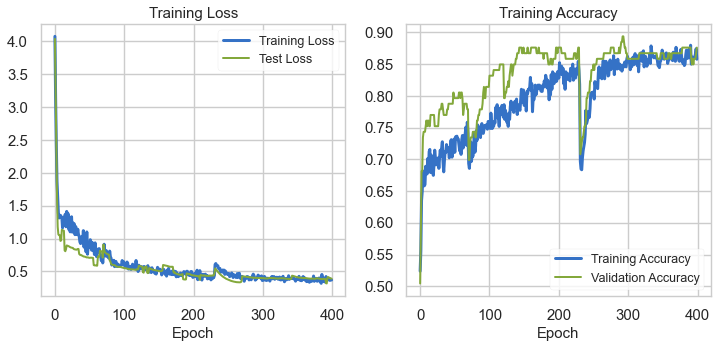

29/29 - 0s - loss: 0.2960 - accuracy: 0.8853
4/4 - 0s - loss: 0.3898 - accuracy: 0.8761
4/4 - 0s - loss: 0.2649 - accuracy: 0.8860
Train loss: 0.2960 Train Acc: 0.8853
Validation loss: 0.3898 Validation Acc: 0.8761
Evaluate on test data
Test loss: 0.2649 Test Acc: 0.8860
5/5 [==============================] - 0s 1ms/step - loss: 0.2649 - accuracy: 0.8860
test loss, test acc: [0.26493749022483826, 0.8859649300575256]


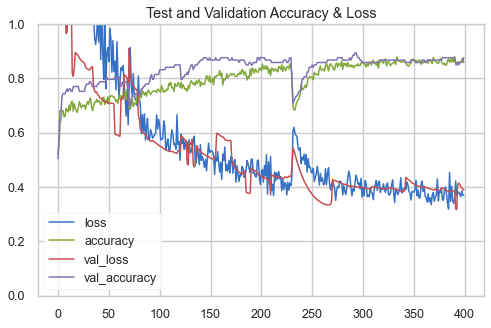

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 19)                456       
_________________________________________________________________
dropout_2 (Dropout)          (None, 19)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 180       
_________________________________________________________________
dropout_3 (Dropout)          (None, 9)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 50        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 692
Trainable params: 692
Non-trainable params: 0
________________________________________________________

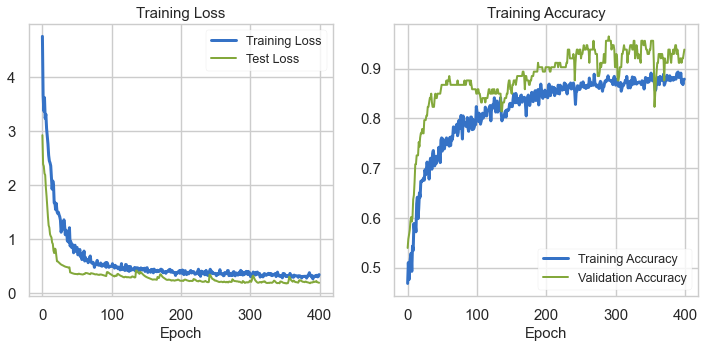

29/29 - 0s - loss: 0.2668 - accuracy: 0.8908
4/4 - 0s - loss: 0.1869 - accuracy: 0.9381
4/4 - 0s - loss: 0.3933 - accuracy: 0.8684
Train loss: 0.2668 Train Acc: 0.8908
Validation loss: 0.1869 Validation Acc: 0.9381
Evaluate on test data
Test loss: 0.3933 Test Acc: 0.8684
5/5 [==============================] - 0s 2ms/step - loss: 0.3933 - accuracy: 0.8684
test loss, test acc: [0.3932623565196991, 0.8684210777282715]


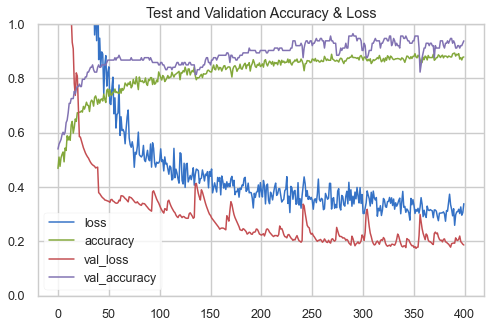

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 98)                10094     
_________________________________________________________________
dropout_4 (Dropout)          (None, 98)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 49)                4851      
_________________________________________________________________
dropout_5 (Dropout)          (None, 49)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 24)                1200      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 25        
Total params: 16,170
Trainable params: 16,170
Non-trainable params: 0
__________________________________________________

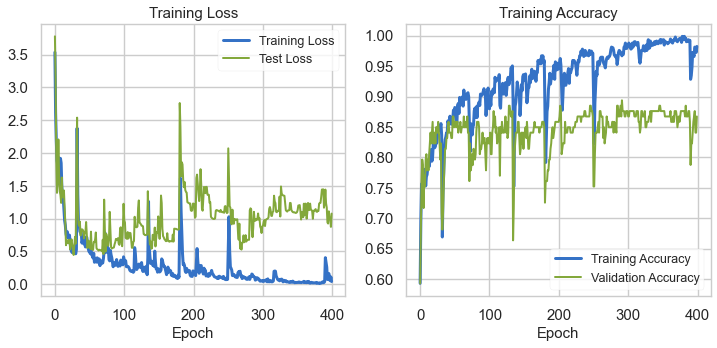

29/29 - 0s - loss: 0.0074 - accuracy: 0.9978
4/4 - 0s - loss: 1.0772 - accuracy: 0.8673
4/4 - 0s - loss: 0.9672 - accuracy: 0.8772
Train loss: 0.0074 Train Acc: 0.9978
Validation loss: 1.0772 Validation Acc: 0.8673
Evaluate on test data
Test loss: 0.9672 Test Acc: 0.8772
5/5 [==============================] - 0s 2ms/step - loss: 0.9672 - accuracy: 0.8772
test loss, test acc: [0.9672257900238037, 0.8771929740905762]


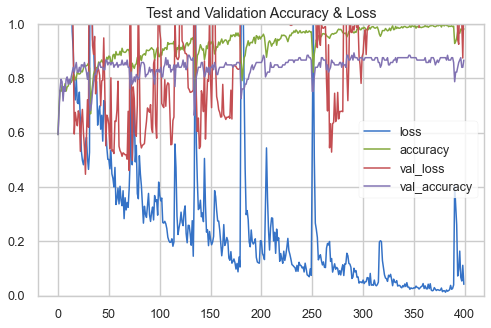

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 102)               10914     
_________________________________________________________________
dropout_6 (Dropout)          (None, 102)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 51)                5253      
_________________________________________________________________
dropout_7 (Dropout)          (None, 51)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 26)                1352      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 27        
Total params: 17,546
Trainable params: 17,546
Non-trainable params: 0
__________________________________________________

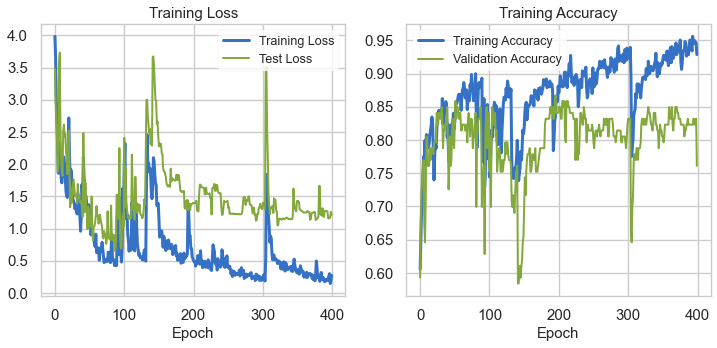

29/29 - 0s - loss: 0.4162 - accuracy: 0.9085
4/4 - 0s - loss: 1.2149 - accuracy: 0.7611
4/4 - 0s - loss: 1.8974 - accuracy: 0.7807
Train loss: 0.4162 Train Acc: 0.9085
Validation loss: 1.2149 Validation Acc: 0.7611
Evaluate on test data
Test loss: 1.8974 Test Acc: 0.7807
5/5 [==============================] - 0s 2ms/step - loss: 1.8974 - accuracy: 0.7807
test loss, test acc: [1.897430658340454, 0.780701756477356]


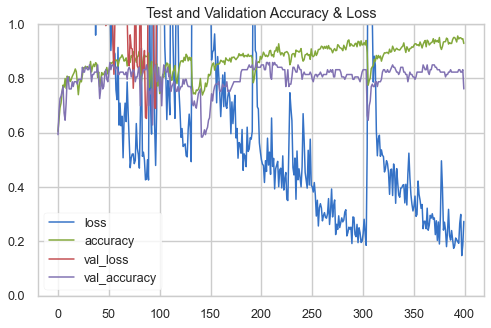

In [108]:
tf_results_train_accuracy = []
tf_results_validation_accuracy = []
tf_results_test_accuracy = []


for n, sample in zip(range(4), samples):
    tf_complete(n, sample)
    
    tf_results_train_accuracy.append(tf_complete.results_tr[1])
    tf_results_validation_accuracy.append(tf_complete.results_va[1])
    tf_results_test_accuracy.append(tf_complete.results_te[1])

In [109]:
# Here I want to evaluate on the test data

# Evaluate the model on the test data using `evaluate`
# print("Evaluate on test data")
# results = model.evaluate(tf_test0_scaled_df, tf_y0_test, batch_size=28)
# print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
# print("Generate predictions for 3 samples")
# predictions = model.predict(x_test[:3])
# print("predictions shape:", predictions.shape)

# tf_test0_scaled_df[:3]

# tf_y0_test[:3]

tf_results_test_accuracy

[0.8859649300575256, 0.8684210777282715, 0.8771929740905762, 0.780701756477356]

# Recap to this point / Results by Classifier

In [110]:
test_results = pd.DataFrame([nb_test_accuracies, lr_test_accuracies, svc_test_accuracies, dt_test_accuracies,
                            rf_test_accuracies, XGB_test_accuracies, nn_test_accuracies, tf_results_test_accuracy])

test_results['Classifier'] = ['Naive Bayes', 'Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost',
                             'Neural Network', 'TensorFlow Base']

test_results.set_index('Classifier', inplace = True)

test_results

0         1         2         3
Classifier                                                 
Naive Bayes          0.814978  0.823789  0.828194  0.823789
Logistic Regression  0.911111  0.911111  0.877778  0.888889
SVC                  0.900000  0.844444  0.822222  0.866667
Decision Tree        0.814722  0.814722  0.740278  0.744722
Random Forest        0.850220  0.841410  0.863436  0.841410
XGBoost              0.845815  0.850220  0.823789  0.828194
Neural Network       0.881057  0.889868  0.876652  0.894273
TensorFlow Base      0.885965  0.868421  0.877193  0.780702

In [111]:
# Original numbers

original_results = {'Naive Bayes': [0.846377, 0.802899, 0.823789, 0.828194],
                    'Logistic Regression': [0.898551, 0.876812, 0.888889, 0.877778],
                    'SVC': [0.905797, 0.869565, 0.866667, 0.833333],
                    'Decision Tree': [0.791304, 0.756522, 0.744722, 0.740278],
                    'Random Forest': [0.860870, 0.820290, 0.837004, 0.823789],
                    'XG Boost': [0.857971, 0.814493, 0.828194, 0.837004],
                    'Neural Netowrk': [0.886957, 0.863768, 0.881057, 0.889868],
                    'TensorFlow Base': [0.898551, 0.968116, 0.938326, 0.955947]}

originals_df = pd.DataFrame.from_dict(original_results, orient = 'index')

originals_df

second_results = {'Naive Bayes': [0.846377, 0.802899, 0.823789, 0.828194],
                  'Logistic Regression': [0.898551, 0.876812, 0.888889, 0.877778],
                  'SVC': [0.905797, 0.869565, 0.866667, 0.833333],
                  'Decision Tree': [0.791304, 0.756522, 0.744722, 0.740278],
                  'Random Forest': [0.860870, 0.820290, 0.837004, 0.823789],
                  'XG Boost': [0.857971, 0.814493, 0.828194, 0.837004],
                  'Neural Netowrk': [0.886957, 0.863768, 0.881057, 0.889868],
                  'TensorFlow Base': [0.924638, 0.968116, 0.973568, 0.907489]}

second_df = pd.DataFrame.from_dict(second_results, orient = 'index')

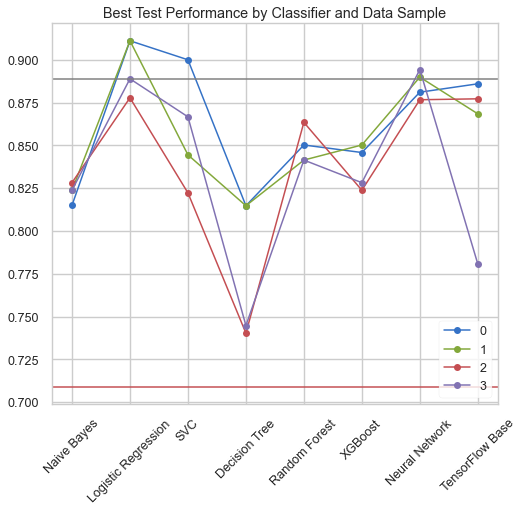

In [112]:
plt.plot(test_results, marker = 'o')
plt.xticks(rotation = 45)
plt.axhline(y=0.709, color='r', linestyle='-')
plt.axhline(y=0.889, color='gray', linestyle='-')
plt.legend((test_results.columns), loc = 'lower right')
plt.title('Best Test Performance by Classifier and Data Sample');

# TF Keras from MachineLearning Mastery

In [135]:
# sonar = pandas.read_csv('sonar.csv', header = None)
# dataset = sonar.values

# X = dataset[:,0:60].astype(float)
# y = dataset[:,60]

In [136]:
# encoder = LabelEncoder()
# encoder.fit(y)
# encoded_y = encoder.transform(y)

In [137]:
len(X3_train_scaled[0])

106

In [138]:
len(Xtrainscaleds[3][0])

106

In [139]:
tf_tuning_baseline = []

for n in range(4):
    
    def create_tf_baseline():
        length = len(Xtrainscaleds[n][0])

        # create model
        model = Sequential()
        model.add(Dense(length, input_dim = length, activation = 'tanh'))
        model.add(Dense(1, activation = 'sigmoid'))

        #compile model
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        return model
    
    estimator = KerasClassifier(build_fn = create_tf_baseline, epochs = 100, batch_size = 5, verbose = 0)
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)
    results = cross_val_score(estimator, Xtrainscaleds[n], ytrains[n], cv = kfold)
    print('Baseline accuracy for '+samples[n]+': %2f%% (%.2f%%)'%(results.mean()*100, results.std()*100))
    
    tf_tuning_baseline.append(results.mean())

Baseline accuracy for Sample 0: 85.328450% (4.04%)
Baseline accuracy for Sample 1: 84.343102% (2.08%)
Baseline accuracy for Sample 2: 85.780220% (2.74%)
Baseline accuracy for Sample 3: 86.105006% (4.36%)


In [140]:
tf_tuning_baseline

[0.8532844960689545, 0.84343101978302, 0.8578022003173829, 0.8610500633716583]

# Tuning Layers and Number of Neurons in the Model

Start with a smaller network.  By having my first layer be 1/2 of the input layer we are forcing feature extraction right up front; the network has to pick the PI that are most relevant.  This will be very interesting.  It might be better than any other kind of regularization or drop out that I have tried elsewhere.

In [141]:
tf_tuning_smaller_tanh = []

for n in range(4):
    
    def create_smaller():
        
        length = len(Xtrainscaleds[n][0])
        
        #create model
        model = Sequential()
        model.add(Dense(length//2, input_dim = length, activation = 'tanh'))
        model.add(Dense(1, activation = 'sigmoid'))

        #compile model
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        return model

    estimator = KerasClassifier(build_fn = create_smaller, epochs = 100, batch_size = 5, verbose = 0)
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)
    results = cross_val_score(estimator, Xtrainscaleds[n], ytrains[n], cv = kfold)
    print('Baseline accuracy for '+samples[n]+': %2f%% (%.2f%%)'%(results.mean()*100, results.std()*100))
    
    tf_tuning_smaller_tanh.append(results.mean())

Baseline accuracy for Sample 0: 86.113553% (3.07%)
Baseline accuracy for Sample 1: 86.433456% (3.43%)
Baseline accuracy for Sample 2: 85.560440% (6.01%)
Baseline accuracy for Sample 3: 85.667889% (3.15%)


In [142]:
# Now the same thing, but with ReLu for activation

tf_tuning_smaller_relu = []

for n in range(4):
    
    def create_smaller():
        
        length = len(Xtrainscaleds[n][0])
        
        #create model
        model = Sequential()
        model.add(Dense(length//2, input_dim = length, activation = 'relu'))
        model.add(Dense(1, activation = 'sigmoid'))

        #compile model
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

        return model

    estimator = KerasClassifier(build_fn = create_smaller, epochs = 100, batch_size = 5, verbose = 0)
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)
    results = cross_val_score(estimator, Xtrainscaleds[n], ytrains[n], cv = kfold)
    print('Baseline accuracy for '+samples[n]+': %2f%% (%.2f%%)'%(results.mean()*100, results.std()*100))
    
    tf_tuning_smaller_relu.append(results.mean())

Baseline accuracy for Sample 0: 85.881563% (3.74%)
Baseline accuracy for Sample 1: 85.004885% (2.97%)
Baseline accuracy for Sample 2: 83.794873% (2.74%)
Baseline accuracy for Sample 3: 84.018316% (3.68%)


In [143]:
# So, it's about the same.  It's a little bit better on X1, but it has a higher std.

In [144]:
tf_tuning_deeper = []

for n in range(4):

    def create_larger():
        
        length = len(Xtrainscaleds[n][0])
        
        #create model
        model = Sequential()
        model.add(Dense(length, input_dim = length, activation = 'tanh'))
        model.add(Dense(length // 2, activation = 'tanh'))
        model.add(Dense(1, activation = 'sigmoid'))

        #compile model
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

        return model

    estimator = KerasClassifier(build_fn = create_larger, epochs = 100, batch_size = 5, verbose = 0)
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)
    results = cross_val_score(estimator, Xtrainscaleds[n], ytrains[n], cv = kfold)
    print('Baseline accuracy for '+samples[n]+': %2f%% (%.2f%%)'%(results.mean()*100, results.std()*100))
    
    tf_tuning_deeper.append(results.mean())

Baseline accuracy for Sample 0: 83.459097% (3.01%)
Baseline accuracy for Sample 1: 82.905983% (4.87%)
Baseline accuracy for Sample 2: 85.550672% (4.38%)
Baseline accuracy for Sample 3: 85.343102% (2.85%)


In [145]:
# So with this one I reduced the first layer just a little bit and then halved the second layer before dumping
# to my decision.

# More layers is not necessarily better.

In [146]:
# So, let's try using two layers, but halving again and again

tf_tuning_smaller_deeper = []

for n in range(4):

    def create_hybrid():
        
        length = len(Xtrainscaleds[n][0])
        
        #create model
        model = Sequential()
        model.add(Dense(length // 2, input_dim = length, activation = 'tanh'))
        model.add(Dense((length // 2)//2, activation = 'tanh'))
        model.add(Dense(1, activation = 'sigmoid'))

        #compile model
        model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = 'accuracy')

        return model

    estimator = KerasClassifier(build_fn = create_hybrid, epochs = 100, batch_size = 5, verbose = 0)
    kfold = StratifiedKFold(n_splits = 10, shuffle = True)
    results = cross_val_score(estimator, Xtrainscaleds[n], ytrains[n], cv = kfold)
    print('Baseline accuracy for '+samples[n]+': %2f%% (%.2f%%)'%(results.mean()*100, results.std()*100))
    
    tf_tuning_smaller_deeper.append(results.mean())

Baseline accuracy for Sample 0: 84.566545% (3.02%)
Baseline accuracy for Sample 1: 84.357754% (4.20%)
Baseline accuracy for Sample 2: 85.449329% (2.80%)
Baseline accuracy for Sample 3: 84.238096% (2.12%)


Now we're going to to run some grid searches to see if we can improve the performance on the default.

For Sample 0, the best accuracy is .877629 with batch_size = 10, epochs = 50, optimizer = RMSprop
when I run SGD, the best accuracy is 0.852265 using {'learn_rate': 0.2, 'momentum': 0.9}
For Sample 1, the best accuracy is .877633 with batch_Size = 40, epochs = 100, optimizer = RMSprop
when I run SGD, the best accuracy is 0.854498 using {'learn_rate': 0.3, 'momentum': 0.4}
For Sample 2, the best accuracy is .858895 with batch_size = 10, epochs = 100, optimizer = Nadam
when I run SGD, the best accuracy is 0.815899 using {'learn_rate': 0.2, 'momentum': 0.2}
For Sample 3, the best accuracy is .861102 with batch_size = 40, epochs = 100, optimizer = Adam
when I run SGD, the best accuracy is 0.814817 using {'learn_rate': 0.3, 'momentum': 0.2}

# Detailed Grid Search

In [147]:
# Here I'm looking at learning rate and momentum.  I'm not sure if this ONLY works with SGD or not.

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MaxNorm

tf_tuned = []
tf_tuned_neurons = []

for n in range(4):

    def create_tf_baseline(neurons = 1):
        length = len(Xtrainscaleds[n][0])
        weight_constraints = [5, 1, 3, 1]
        dropouts = [0.9, 0.2, 0.0, 0.3]
        optimizers = ['RMSprop', 'Nadam', 'Adam', 'RMSprop']
        initializers = ['normal', 'uniform', 'normal', 'normal']
        activation_methods = ['tanh', 'softsign', 'linear', 'tanh']
        # create model
        model = Sequential()
        model.add(Dense(neurons, input_dim = length, kernel_initializer = initializers[n], 
                        activation = activation_methods[n], kernel_constraint = MaxNorm(weight_constraints[n])))
        model.add(Dropout(dropouts[n]))
        model.add(Dense(1, kernel_initializer = initializers[n], activation = 'sigmoid'))

        #compile model
#         optimizer = SGD(lr = learn_rate, momentum = momentum)
        model.compile(loss = 'binary_crossentropy', optimizer = optimizers[n], metrics = ['accuracy'])

        return model
    # create model

    epoch_list = [100, 50, 100, 100]
    batch_size_list = [40, 20, 10, 60]
    
    model = KerasClassifier(build_fn = create_tf_baseline, epochs = epoch_list[n], 
                            batch_size = batch_size_list[n], verbose = 0)
    
    # define grid search parameters
    # batch_size = [10, 20, 40, 60, 80, 100]
    # epochs = [10, 50, 100]
    # optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    # learn_rate= [0.001, 0.01, 0.1, 0.2, 0.3] # THESE WORK
    # momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9] # THESE WORK
    # init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    # activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    # weight_constraint = [1, 2, 3, 4, 5]
    #dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    if n < 2:
        neurons = [2, 5, 8, 11, 14, 17, 20]
    else:
        neurons = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    
    
    param_grid = dict(neurons = neurons)
    
    grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = -1, cv = 3)
    grid_result = grid.fit(Xtrainscaleds[n], ytrains[n])

    # summarize the results
    print('Best for '+samples[n]+': %f using %s' %(grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']

    for mean, stdev, param in zip(means, stds, params):
        print('%f (%f) with: %r'% (mean, stdev, param))
        
    tf_tuned.append(grid_result.best_score_)
    tf_tuned_neurons.append(grid_result.best_params_)


Best for Sample 0: 0.862206 using {'neurons': 20}
0.834627 (0.009235) with: {'neurons': 2}
0.853368 (0.003907) with: {'neurons': 5}
0.861095 (0.009521) with: {'neurons': 8}
0.856694 (0.016276) with: {'neurons': 11}
0.856687 (0.011016) with: {'neurons': 14}
0.855587 (0.012530) with: {'neurons': 17}
0.862206 (0.014644) with: {'neurons': 20}
Best for Sample 1: 0.874336 using {'neurons': 17}
0.855591 (0.017374) with: {'neurons': 2}
0.859995 (0.011021) with: {'neurons': 5}
0.862202 (0.012540) with: {'neurons': 8}
0.867721 (0.016204) with: {'neurons': 11}
0.873232 (0.015613) with: {'neurons': 14}
0.874336 (0.016215) with: {'neurons': 17}
0.874332 (0.014842) with: {'neurons': 20}
Best for Sample 2: 0.858876 using {'neurons': 90}
0.857783 (0.009579) with: {'neurons': 10}
0.858873 (0.003236) with: {'neurons': 20}
0.852265 (0.003954) with: {'neurons': 30}
0.856680 (0.008082) with: {'neurons': 40}
0.854461 (0.002898) with: {'neurons': 50}
0.856665 (0.004296) with: {'neurons': 60}
0.853361 (0.0068

In [148]:
tf_tuned

[0.8622057636578878, 0.8743361035982767, 0.8588762879371643, 0.868813713391622]

In [149]:
test_results_2 = pd.DataFrame([nb_test_accuracies, lr_test_accuracies, svc_test_accuracies, dt_test_accuracies,
                            rf_test_accuracies, XGB_test_accuracies, nn_test_accuracies, tf_results_test_accuracy,
                            tf_tuning_baseline, tf_tuning_smaller_tanh, tf_tuning_smaller_relu, tf_tuning_deeper,
                            tf_tuning_smaller_deeper, tf_tuned])

test_results_2['Classifier'] = ['Naive Bayes', 'Logistic Regression', 'SVC', 'Decision Tree', 'Random Forest', 'XGBoost',
                             'Neural Network', 'TensorFlow Base', 'TF Base', 'TF Small Tanh', 'TF Small Relu','TF Deep', 
                                'TF Small Deep', 'TF Tuned']

test_results_2.set_index('Classifier', inplace = True)

test_results_2

0         1         2         3
Classifier                                                 
Naive Bayes          0.814978  0.823789  0.828194  0.823789
Logistic Regression  0.911111  0.911111  0.877778  0.888889
SVC                  0.900000  0.844444  0.822222  0.866667
Decision Tree        0.814722  0.814722  0.740278  0.744722
Random Forest        0.850220  0.841410  0.863436  0.841410
XGBoost              0.845815  0.850220  0.823789  0.828194
Neural Network       0.881057  0.889868  0.876652  0.894273
TensorFlow Base      0.885965  0.868421  0.877193  0.780702
TF Base              0.853284  0.843431  0.857802  0.861050
TF Small Tanh        0.861136  0.864335  0.855604  0.856679
TF Small Relu        0.858816  0.850049  0.837949  0.840183
TF Deep              0.834591  0.829060  0.855507  0.853431
TF Small Deep        0.845665  0.843578  0.854493  0.842381
TF Tuned             0.862206  0.874336  0.858876  0.868814

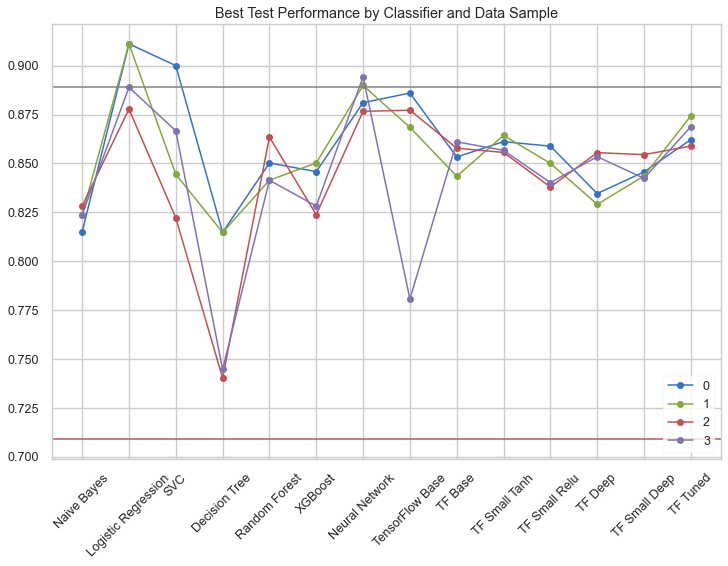

In [150]:
plt.figure(figsize=(12,8))
plt.plot(test_results_2, marker = 'o')
plt.xticks(rotation = 45)
plt.axhline(y=0.709, color='r', linestyle='-')
plt.axhline(y=0.889, color='gray', linestyle='-')
plt.legend((test_results_2.columns), loc = 'lower right')
plt.title('Best Test Performance by Classifier and Data Sample');

# New Section

What I want to do here now is to start working my TensorFlow model on the POSGRU subsets before knitting them together for one final run to make a prediction.

Let's start by looking at running this model on each POSGRU subset first.  Then we can take a look at how to take the outputs and knit them back together into a final prediction based on win / loss.

In [151]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [152]:
D1_train_subset, D1_test_subset = [col for col in X2_train_scaled_df if col.startswith('D-')], [col for col in X2_test_scaled_df if col.startswith('D-')]
F1_train_subset, F1_test_subset = [col for col in X2_train_scaled_df if col.startswith('F-')], [col for col in X2_test_scaled_df if col.startswith('F-')]
M1_train_subset, M1_test_subset = [col for col in X2_train_scaled_df if col.startswith('M-')], [col for col in X2_test_scaled_df if col.startswith('M-')]
R1_train_subset, R1_test_subset = [col for col in X2_train_scaled_df if col.startswith('R-')], [col for col in X2_test_scaled_df if col.startswith('R-')]
HDAF1_train_subset, HDAF1_test_subset = [col for col in X2_train_scaled_df if col.startswith('HDAF-')], [col for col in X2_test_scaled_df if col.startswith('HDAF-')]
HFAD1_train_subset, HFAD1_test_subset = [col for col in X2_train_scaled_df if col.startswith('HFAD-')], [col for col in X2_test_scaled_df if col.startswith('HFAD-')]


# D1_train_scaled, D1_test_scaled = X1_train_scaled_df[D1_train_subset], X1_test_scaled_df[D1_test_subset]
D2_train_scaled, D2_test_scaled = X2_train_scaled_df[D1_train_subset], X2_test_scaled_df[D1_test_subset]
D3_train_scaled, D3_test_scaled = X3_train_scaled_df[D1_train_subset], X3_test_scaled_df[D1_test_subset]

# F1_train_scaled, F1_test_scaled = X1_train_scaled_df[F1_train_subset], X1_test_scaled_df[F1_test_subset]
F2_train_scaled, F2_test_scaled = X2_train_scaled_df[F1_train_subset], X2_test_scaled_df[F1_test_subset]
F3_train_scaled, F3_test_scaled = X3_train_scaled_df[F1_train_subset], X3_test_scaled_df[F1_test_subset]

# M1_train_scaled, M1_test_scaled = X1_train_scaled_df[M1_train_subset], X1_test_scaled_df[M1_test_subset]
M2_train_scaled, M2_test_scaled = X2_train_scaled_df[M1_train_subset], X2_test_scaled_df[M1_test_subset]
M3_train_scaled, M3_test_scaled = X3_train_scaled_df[M1_train_subset], X3_test_scaled_df[M1_test_subset]

# R1_train_scaled, R1_test_scaled = X1_train_scaled_df[R1_train_subset], X1_test_scaled_df[R1_test_subset]
R2_train_scaled, R2_test_scaled = X2_train_scaled_df[R1_train_subset], X2_test_scaled_df[R1_test_subset]
R3_train_scaled, R3_test_scaled = X3_train_scaled_df[R1_train_subset], X3_test_scaled_df[R1_test_subset]

# HDAF1_train_scaled, HDAF1_test_scaled = X1_train_scaled_df[HDAF1_train_subset], X1_test_scaled_df[HDAF1_test_subset]
HDAF2_train_scaled, HDAF2_test_scaled = X2_train_scaled_df[HDAF1_train_subset], X2_test_scaled_df[HDAF1_test_subset]
HDAF3_train_scaled, HDAF3_test_scaled = X3_train_scaled_df[HDAF1_train_subset], X3_test_scaled_df[HDAF1_test_subset]

# HFAD1_train_scaled, HFAD1_test_scaled = X1_train_scaled_df[HFAD1_train_subset], X1_test_scaled_df[HFAD1_test_subset]
HFAD2_train_scaled, HFAD2_test_scaled = X2_train_scaled_df[HFAD1_train_subset], X2_test_scaled_df[HFAD1_test_subset]
HFAD3_train_scaled, HFAD3_test_scaled = X3_train_scaled_df[HFAD1_train_subset], X3_test_scaled_df[HFAD1_test_subset]


# C1_train, C1_test = X1_train_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], X1_test_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]
C2_train, C2_test = X2_train_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], X2_test_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]
C3_train, C3_test = X3_train_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']], X3_test_scaled_df[['Intrastate', 'Same / Neutral Venue', 'Clash', 'RLP']]

In [153]:
# So, let's try and build this model for the X1_train_scaled set.  Once I do that, I can run it through all of them.

# Here, let me set up my groups, just for future reference, the same way I referenced them above, by index.
# But, this time I have one fewer - only three, starting with 1.

# ones_tr = [D1_train_scaled, F1_train_scaled, M1_train_scaled, R1_train_scaled]
# ones_te = [D1_test_scaled, F1_test_scaled, M1_test_scaled, R1_test_scaled]

twos_tr = [D2_train_scaled, F2_train_scaled, M2_train_scaled, R2_train_scaled, C2_train]
twos_te = [D2_test_scaled, F2_test_scaled, M2_test_scaled, R2_test_scaled, C2_test]

threes_tr = [D3_train_scaled, F3_train_scaled, M3_train_scaled, R3_train_scaled, C3_train]
threes_te = [D3_test_scaled, F3_test_scaled, M3_test_scaled, R3_test_scaled, C3_test]



In [154]:
D1_train_subset

['D-DI',
 'D-KI',
 'D-MK',
 'D-HB',
 'D-HO',
 'D-TK',
 'D-RB',
 'D-IF',
 'D-CL',
 'D-CG',
 'D-FF',
 'D-FA',
 'D-CP',
 'D-UP',
 'D-CM',
 'D-MI',
 'D-1%',
 'D-BO',
 'D-Height',
 'D-Weight',
 'D-Age']

In [155]:
# OK, so my most complex attempt failed at the concat level.  Let's see if a simpler model will work, then we can build
# back up.

In [156]:
# So, my original model with a function and sequential is different from this model, which is all defined.

# I'll have to see if I can do it as a sequential model

In [157]:
n1 = 20
n2 = 10
n3 = 5

# Inputs

input_D = tf.keras.layers.Input(shape = len(D2_train_scaled.columns), name = 'Defenders')
input_F = tf.keras.layers.Input(shape = len(F2_train_scaled.columns), name = 'Forwards')
input_M = tf.keras.layers.Input(shape = len(M2_train_scaled.columns), name = 'Midfielders')
input_R = tf.keras.layers.Input(shape = len(R2_train_scaled.columns), name = 'Rucks')
input_C = tf.keras.layers.Input(shape = len(C2_train.columns), name = 'Categoricals')

# Hidden Layers

## Defenders

defenders = tf.keras.layers.Dense(n1, activation = 'tanh')(input_D)
d_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(defenders)
d_step1 = tf.keras.layers.Dense(n2, activation = 'tanh')(d_regularization1)
d_regularization2 = tf.keras.layers.Dropout(rate = 0.2)(d_step1)
d_step2 = tf.keras.layers.Dense(n3, activation = 'tanh')(d_regularization2)


## Forwards

forwards = tf.keras.layers.Dense(n1, activation = 'tanh')(input_F)
f_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(forwards)
f_step1 = tf.keras.layers.Dense(n2, activation = 'tanh')(f_regularization1)
f_regularization2 = tf.keras.layers.Dropout(rate = 0.2)(f_step1)
f_step2 = tf.keras.layers.Dense(n3, activation = 'tanh')(f_regularization2)


## Midfielders

midfielders = tf.keras.layers.Dense(n1, activation = 'tanh')(input_M)
m_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(midfielders)
m_step1 = tf.keras.layers.Dense(n2, activation = 'tanh')(m_regularization1)
m_regularization2 =  tf.keras.layers.Dropout(rate = 0.2)(m_step1)
m_step2 = tf.keras.layers.Dense(n3, activation = 'tanh')(m_regularization2)


## Rucks

rucks = tf.keras.layers.Dense(n1, activation = 'tanh')(input_R)
r_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(rucks)
r_step1 = tf.keras.layers.Dense(n2, activation = 'tanh')(r_regularization1)
r_regularization2 = tf.keras.layers.Dropout(rate = 0.2)(r_step1)
r_step2 = tf.keras.layers.Dense(n3, activation = 'tanh')(r_regularization2)


## Categoricals

categoricals = tf.keras.layers.Dense(n1, activation = 'tanh')(input_C)
c_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(categoricals)
c_step1 = tf.keras.layers.Dense(n2, activation = 'tanh')(c_regularization1)
c_regularization2 = tf.keras.layers.Dropout(rate = 0.2)(c_step1)
c_step2 = tf.keras.layers.Dense(n3, activation = 'tanh')(c_regularization2)


# End Hidden Layers

# Concat Layer

concat = tf.keras.layers.concatenate([d_step2, f_step2, m_step2, r_step2, c_step2])
    
# Output
    
output = tf.keras.layers.Dense(1, name = 'Output')(concat)
    
complex_model = tf.keras.Model(inputs = [input_D, input_F, input_M, input_R, input_C], outputs = [output])

In [158]:
complex_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Defenders (InputLayer)          [(None, 21)]         0                                            
__________________________________________________________________________________________________
Forwards (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
Midfielders (InputLayer)        [(None, 21)]         0                                            
__________________________________________________________________________________________________
Rucks (InputLayer)              [(None, 21)]         0                                            
______________________________________________________________________________________________

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Defenders (InputLayer)          [(None, 21)]         0                                            
__________________________________________________________________________________________________
Forwards (InputLayer)           [(None, 21)]         0                                            
__________________________________________________________________________________________________
Midfielders (InputLayer)        [(None, 21)]         0                                            
__________________________________________________________________________________________________
Rucks (InputLayer)              [(None, 21)]         0                                            
____________________________________________________________________________________________

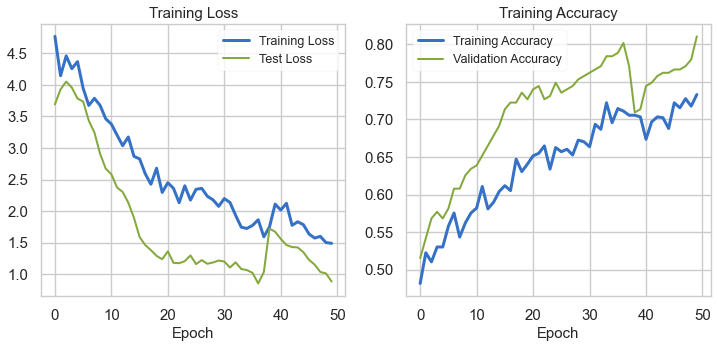

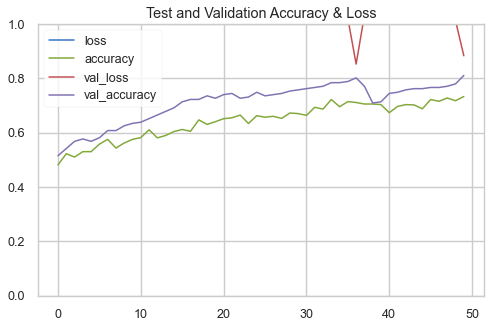

In [159]:
# def tf_complete(integer, sample):
    
#     model = build_model(train_xs[integer])
    
#     model.summary()
        
#     EPOCHS = 400

#     history = model.fit(train_xs[integer], train_ys[integer], batch_size = 35,
#                         epochs=EPOCHS, validation_data = (val_xs[integer], val_ys[integer]), 
#                         shuffle = True, verbose=0)
#     print('Results for '+sample)


complex_model = tf.keras.Model(inputs = [input_D, input_F, input_M, input_R, input_C], outputs = [output])

optimizer = tf.keras.optimizers.Adam(lr = .002)
complex_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

complex_model.summary()

EPOCHS = 400

history =  complex_model.fit((D2_train_scaled, F2_train_scaled, M2_train_scaled, R2_train_scaled, C2_train ), y2_train, epochs = 50,
                            validation_data = ((D2_test_scaled, F2_test_scaled, M2_test_scaled, R2_test_scaled, C2_test), y2_test),
                            verbose = 0)

print('Results for '+sample)
    
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

hist = history.history
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'], lw = 3, label = 'Training Loss')
ax.plot(hist['val_loss'], lw = 2, label = 'Test Loss')
ax.set_title('Training Loss', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.legend(loc = 0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'], lw = 3, label = 'Training Accuracy')
ax.plot(hist['val_accuracy'], lw = 2, label = 'Validation Accuracy')
ax.set_title('Training Accuracy', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.legend(loc = 0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()


# results_tr = complex_model.evaluate(train_xs[integer], train_ys[integer], verbose = 2)
# results_va = complex_model.evaluate(val_xs[integer], val_ys[integer], verbose = 2)
# print('Train loss: {:.4f} Train Acc: {:.4f}'.format(*results_tr))
# print('Validation loss: {:.4f} Validation Acc: {:.4f}'.format(*results_va))

# print("Evaluate on test data")
# results = model.evaluate(test_xs[integer], test_ys[integer], batch_size=28)
# print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
#     print("Generate predictions for 3 samples")
#     predictions = model.predict(test_xs[integer][:3])
#     print(predictions)
#     print("predictions shape:", predictions.shape)


pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Test and Validation Accuracy & Loss')
plt.show();
    
    

# Here is a simple concatenation layer that feeds the aggregate back in

In [160]:
length1 = len(train_xs[0].columns)
layer1 = length1 - 4
layer2 = layer1 / 2
if layer2 < 40:
    layer3 = 5
else:
    layer3 = 25

In [161]:
input_PG = tf.keras.layers.Input(shape = length1, name = 'PosGru')
input_NPG = tf.keras.layers.Input(shape = len(train_xs[2].columns), name = 'No PosGru')

In [162]:
PG = tf.keras.layers.Dense(layer1, activation = 'tanh')(input_PG)
pg_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(PG)
pg_step1 = tf.keras.layers.Dense(layer2, activation = 'tanh')(pg_regularization1)
pg_regularization2 = tf.keras.layers.Dropout(rate = 0.2)(pg_step1)
pg_step2 = tf.keras.layers.Dense(layer3, activation = 'tanh')(pg_regularization2)

NPG = tf.keras.layers.Dense(len(train_xs[0].columns), activation = 'tanh')(input_NPG)
npg_regularization1 = tf.keras.layers.Dropout(rate = 0.2)(NPG)
npg_step2 = tf.keras.layers.Dense(5, activation = 'tanh')(npg_regularization1)
                            

# Concat Layer

concat = tf.keras.layers.concatenate([pg_step2, npg_step2])
    
# Output
    
output = tf.keras.layers.Dense(1, name = 'Output')(concat)
    
concat_model = tf.keras.Model(inputs = [input_PG, input_NPG], outputs = [output])
                                  

NameError: name 'npg_step1' is not defined

In [ ]:
train_xs[0]

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr = .002)
concat_model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

concat_model.summary()

EPOCHS = 400

history =  concat_model.fit((train_xs[1], train_xs[0]), y1_train, epochs = 50,
                            validation_data = ((val_xs[1], val_xs[0]), y1_test),
                            verbose = 0)

print('Results for '+sample)
    
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

hist = history.history
fig = plt.figure(figsize = (12,5))
ax = fig.add_subplot(1,2,1)
ax.plot(hist['loss'], lw = 3, label = 'Training Loss')
ax.plot(hist['val_loss'], lw = 2, label = 'Test Loss')
ax.set_title('Training Loss', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.legend(loc = 0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
ax = fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'], lw = 3, label = 'Training Accuracy')
ax.plot(hist['val_accuracy'], lw = 2, label = 'Validation Accuracy')
ax.set_title('Training Accuracy', size = 15)
ax.set_xlabel('Epoch', size = 15)
ax.legend(loc = 0)
ax.tick_params(axis = 'both', which = 'major', labelsize = 15)
plt.show()


# results_tr = complex_model.evaluate(train_xs[integer], train_ys[integer], verbose = 2)
# results_va = complex_model.evaluate(val_xs[integer], val_ys[integer], verbose = 2)
# print('Train loss: {:.4f} Train Acc: {:.4f}'.format(*results_tr))
# print('Validation loss: {:.4f} Validation Acc: {:.4f}'.format(*results_va))

# print("Evaluate on test data")
# results = model.evaluate(test_xs[integer], test_ys[integer], batch_size=28)
# print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
#     print("Generate predictions for 3 samples")
#     predictions = model.predict(test_xs[integer][:3])
#     print(predictions)
#     print("predictions shape:", predictions.shape)


pd.DataFrame(history.history).plot(figsize = (8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.title('Test and Validation Accuracy & Loss')
plt.show();
    
    

In [ ]:
# So, one thing I'm thinking here is...how many games are played at the SAME venue, where there
# is essentially no home-field advantage?  This is true for WA, SA - 4 games / year, but
# much more true for VIC teams.  Really, in VIC, you could claim that there is no home field
# advantage for anybody.  Geelong plays many home games at the MCG and that's not their home
# field!

# How would this entire thing look if I were to change the definition of H / A based on which
# team had the higher ladder position instead of "home" field, regardless of the location of
# the game?  Would it change anything?

# Here I could see where I might want to create a 5 game trend WITHIN a season to address
# momentum, such as it is.  And, I SHOULD be able to account for a 5 game rolling average margin.

# If I'm building this on a game by game basis moving forward, I would know the scores of the 
# previous week's games, then I'd make predictions based on who is in the 22 for the next week.

# But, since I'm doing a simple subtraction of the two dataframes, I have to make that call about
# which team is "REALLY" the home team much earlier than I am.  Let's think about how to do that.

In [ ]:
# So, I introduced Goals and Behinds into the analysis and it really didn't make anything "better"

# A couple of questions.  How can I introduce variability into these PI based on one of the
# categoricals?  I'm looking for a way to separate along that 0,0 line.

# Something like, if relative ladder position is <5 and interstate is 1, and the trend is flat or
# positive, you get a 10% bump in your PI.  If it's >10 the lower side gets a 10% deduction in
# its normalized PI.

# Maybe there's a way to randomize or add up some of those plusses and minuses.

# Let's isolate and LOOK at clash games, or interstate games and see if we perform better on
# any subset.

# Summary / Conclusion

As I worked through this project, implementing things that we learned in class for that week, I had to do a lot of rework, and through that process, I learned a lot about what does work and what doesn't.

The main thing I learned is that Neural Networks do not perform magic: they are tools that you have to use properly and appropriately.  More features by themselves aren't necessarily good things, especially if they are highly correlated.  But then, even if you strip everything that you can out of your model and get to a set of what seem to be very relevant features, there is still no guarantee that your model will perform well.

Every step in this process requires a lot of thought and hard work.

Overall, the models all performed about the same - mid 70s, but the TensorFlow model seemed to exhibit the most overtraining, despite two dropout layers for regularization.

I am passionate about the subject (both footy and Data Science).  I started this project in 601, and the difference in what I was able to accomplish between December and May is amazing to me.  As a result of this project I learned things that we didn't do in class - F-score and Recursive Feature Elimination, in addition to Explained Variance and SBS, as feature reduction tools.

Mostly though, it was very interesting to work on a project that has no pre-cooked answers.  Every example that we worked on in class HAS a right answer, even if there are multiple ways to achieve it, but with this project, the ultimate answer is an unknown.

The easiest way to learn is by laughing at the mistakes of others; the second- best way to learn is by doing it yourself.  I chose the second path here, and while I don't have a clear, final "answer", I think that I have demonstrated logic in my very verbose approach (I would hide most of this cleaning like they do on the Medium web site.  It's too tedious.), and I think that I have a foundation for future research if I can find someone to work with in the future.

My final results for the train / test split were:

* Logistic Regression: 72.8% / 72.6%
* SVC: 72.7% / 72.8%
* NN: 72.75% / 72.33%
* TensorFlow: 73.6% / 69.40% (essentially the same on the validation set)

I was able to match and get close to some of the results from my references with Logistic Regression, SVM, and the class-built NN, but TensorFlow performed much worse.  To say that was a disappointment would be an understatement.  But, there are so many moving parts to TensorFlow that I am sure that is a result of my inexperience.

But, I came within .5% of my target, even if I was not able to advance the research on this subject.  Overall I'm satisfied with what I learned.

# References

**Primary References:**

Fahey-Gilmour, J., Dawson, B., Peeling, P., Heasman, J., & Rogalski B.; "Multifactorial analysis of factors influencing elite Australian football match outcomes: a machine learning approach"; International Journal of Computer Science in Sport, Volume 18, Issue 3, 2019

Young, Christopher M.; Luo, Wei; Gastin, Paul; Tran, Jacqueline; Dwyer, Dan B.; "The Relationship between Match Performance Indicators and Outcome in Australian Football"; 'Journal of Science and Medicine in Sport' (2018); https://doi.org/10.1016/j.jsams.2018.09.235

Raschka, Sebastian. Python Machine Learning: Machine Learning and Deep Learning with Python, scikit-learn, and TensorFlow 2, 3rd Edition . Packt Publishing. Kindle Edition.

Muller, Andreas C., Guido, Sarah; (2017). "Introduction to Machine Learning with Python, A Guide for Data Scientists"; O'Reilly

**Code Help / Tutorials:**

 https://www.tensorflow.org/tutorials/keras/regression For help in getting the dataframe into a form and format that was usable by TensorFlow.

  https://www.kaggle.com/aaronl87/predicting-winner-and-afl-fantasy-points For looking at ranked feature importance.

  https://towardsdatascience.com/dont-overfit-how-to-prevent-overfitting-in-your-deep-learning-models-63274e552323 For F-score and Recursive Feature Elimination

  https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/ For gridsearch of Keras hyperparameters.  Jason Brownlee's work was very helpful.  I originally did many more of his hyperparameter tuning steps on the original dataset, but ultimately, chose to focus more on the quality of inputs, rather than trying to make TensorFlow clean up highly correlated input features.  I think that, as I learn more, his work will be more useful.






# Data Forecasting in Python

In [ ]:
# Here is the BetFair Detour.  Some of this is useful - it establishes rolling averages, which I like.
# I had actually done that before, but didn't quite know how to operationalize it.

In [260]:
# master_seasonPI_df.head()

pred_home = copy.deepcopy(home_list)
pred_away = copy.deepcopy(away_list)

pred_home.drop(columns = ['Venue', 'Home Field-H', 'Home State'], inplace = True)
pred_away.drop(columns = ['Home Field-A', 'Away State'], inplace = True)
pred_home.insert(4, 'H/A', 'H')
pred_away.insert(4, 'H/A', 'A')

pred_home = pred_home.reset_index()
pred_away = pred_away.reset_index()

pred_home.rename(columns = {'Home Score': 'Score', 'LP-H': 'LP', 'Home': 'Team', 'index': 'Game_ID'}, inplace = True)
pred_away.rename(columns = {'Away Score': 'Score', 'LP-A': 'LP', 'Away': 'Team', 'index': 'Game_ID'}, inplace = True)

pred_ha_tuple = (pred_home, pred_away)
pred_ha_concat = pd.concat(pred_ha_tuple, ignore_index = True)

In [261]:
# Let's see what happens if I try to create this exponential moving average (EMA)

def create_exp_weighted_avgs(df, span):
    
    ema_features = df[['Game_ID', 'Team']].copy()
        
    feature_names = df.iloc[:, 6:].columns
    
    for feature_name in feature_names:
        feature_ema = (df.groupby(['Team'])[feature_name].transform(lambda row: (row.ewm(span = span).mean().shift(1))))
        
        ema_features[feature_name] = feature_ema
        
    return ema_features
    

In [262]:
features_rolling_averages = create_exp_weighted_avgs(pred_ha_concat, span=10)
features_rolling_averages

Game_ID         Team      Score         LP        D-DI        D-KI  \
0           0          GWS        NaN        NaN         NaN         NaN   
1           1     Richmond        NaN        NaN         NaN         NaN   
2           2     Hawthorn        NaN        NaN         NaN         NaN   
3           3    Melbourne        NaN        NaN         NaN         NaN   
4           4   Gold Coast        NaN        NaN         NaN         NaN   
...       ...          ...        ...        ...         ...         ...   
3467     1731     Adelaide  55.889621  13.764886  137.838819   85.312339   
3468     1732       Sydney  51.028247  13.487881  103.773947   62.403573   
3469     1733      Geelong  68.724372   4.242332  152.318418   99.159944   
3470     1734          GWS  51.886819   7.558878  159.029419  104.351200   
3471     1735  Collingwood  62.823582   4.818023  100.196943   61.935264   

           D-MK       D-HB      D-GL      D-BH  ...       R-UP      R-CM  \
0           NaN        NaN       NaN       NaN  ...        NaN       NaN   
1           NaN        NaN       NaN       NaN  ...        NaN       NaN   
2           NaN        NaN       NaN       NaN  ...        NaN       NaN   
3           NaN        NaN       NaN       NaN  ...        NaN       NaN   
4           NaN        NaN       NaN       NaN  ...        NaN       NaN   
...         ...        ...       ...       ...  ...        ...       ...   
3467  37.844339  51.456158  0.842279  0.637891  ...  10.910711  2.851987   
3468  24.927095  41.554395  0.102505  0.327524  ...   2.998025  0.405267   
3469  45.368325  52.722959  0.873842  0.926633  ...   2.931099  0.379016   
3470  52.935602  54.847479  1.972820  1.360799  ...   2.962706  0.538116   
3471  24.342517  38.319250  0.374238  0.349343  ...  15.175678  2.621678   

          R-MI      R-1%      R-BO       R-AMG      R-GA    R-Height  \
0          NaN       NaN       NaN         NaN       NaN         NaN   
1          NaN       NaN       NaN         NaN       NaN         NaN   
2          NaN       NaN       NaN         NaN       NaN         NaN   
3          NaN       NaN       NaN         NaN       NaN         NaN   
4          NaN       NaN       NaN         NaN       NaN         NaN   
...        ...       ...       ...         ...       ...         ...   
3467  0.590860  2.799847  0.000137  177.751736  0.085615  200.870693   
3468  0.167757  1.949918  0.019998   77.503549  0.030058  194.740195   
3469  0.276988  2.045650  0.011128   79.996117  0.131150  193.829889   
3470  0.240991  4.754593  0.000503   61.584413  0.014328  199.876361   
3471  0.776102  8.117189  0.197297  256.777141  0.299828  201.437047   

        R-Weight      R-Age  
0            NaN        NaN  
1            NaN        NaN  
2            NaN        NaN  
3            NaN        NaN  
4            NaN        NaN  
...          ...        ...  
3467   96.888824  25.055245  
3468   90.032351  27.919688  
3469   91.903712  27.941592  
3470  104.550036  32.821826  
3471  100.445261  27.046809  

[3472 rows x 104 columns]

# Form between teams

In [263]:
fbt_home = copy.deepcopy(home_list)
fbt_away = copy.deepcopy(away_list)

In [264]:
match_results_home = fbt_home[['Home', 'Home Score']]
match_results_away = fbt_away[['Away', 'Away Score']]

df = pd.merge(df2, df1, how='left')

match_results1 = pd.merge(match_results_home, match_results_away, how = 'left', left_index = True, right_index = True)
match_results2 = pd.merge(match_results_away, match_results_home, how = 'left', left_index = True, right_index = True)

match_results1['Margin'] = match_results1['Home Score'] - match_results1['Away Score']
match_results2['Margin'] = match_results2['Away Score'] - match_results2['Home Score']

match_results1.rename(columns = {'Home': 'Team', 'Away': 'Opponent'}, inplace = True)
mra = match_results1[['Team', 'Opponent', 'Margin']]

match_results2.rename(columns = {'Away': 'Team', 'Home': 'Opponent'}, inplace = True)
mrb = match_results2[['Team', 'Opponent', 'Margin']]

mr_concat_tuple = (mra, mrb)
mr_concat = pd.concat(mr_concat_tuple, ignore_index = True)

In [265]:
form_btwn_teams = mr_concat.copy()

form_btwn_teams['form_margin_between_teams'] = (mr_concat.groupby(['Team', 'Opponent'])['Margin']\
                                                .transform(lambda row: row.rolling(5).mean().shift().fillna(0)))

form_btwn_teams['form_past_5_btwn_teams'] = \
(mr_concat.assign(win = lambda df: df.apply(lambda row: 1 if row.Margin > 0 else 0, axis='columns'))
              .groupby(['Team', 'Opponent'])['win']
              .transform(lambda row: row.rolling(5).mean().shift() * 5)
              .fillna(0))

In [266]:
form_btwn_teams

Team         Opponent  Margin  form_margin_between_teams  \
0             GWS           Sydney     -63                        0.0   
1        Richmond          Carlton     -44                        0.0   
2        Hawthorn      Collingwood      22                        0.0   
3       Melbourne         Brisbane     -41                        0.0   
4      Gold Coast         Adelaide     -69                        0.0   
...           ...              ...     ...                        ...   
3467     Adelaide  North Melbourne     -69                      -17.4   
3468       Sydney        St. Kilda     -53                       60.8   
3469      Geelong       West Coast      -9                       -4.6   
3470          GWS       Gold Coast      26                       -5.6   
3471  Collingwood        Fremantle     -12                       -1.8   

      form_past_5_btwn_teams  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
...                      ...  
3467                     1.0  
3468                     5.0  
3469                     1.0  
3470                     3.0  
3471                     2.0  

[3472 rows x 5 columns]

In [267]:
# It bothers me that I did this only to throw away the duplicate datat in the next step, so I'm going to try it with
# the hanc.  Now everything is in the correct order.  Order isn't terribly important for ML, but it is important
# for ELO and some of these processes. You have to show performance throughout the season.

# Other times, it's just wins and losses based on PI.

hanc = copy.deepcopy(home_away_net_complete)

hanc.replace({'round1': 'round01', 'round2': 'round02', 'round3': 'round03', 'round4': 'round04',
             'round5': 'round05', 'round6': 'round06', 'round7': 'round07', 'round8': 'round08',
             'round9': 'round09'}, inplace = True)

hanc.sort_values(by = ['Season', 'Round'], inplace = True)
hanc = hanc.reset_index()
hanc.rename(columns = {'index': 'Game_ID'}, inplace = True)

In [268]:
form_btwn_teams_2 = hanc[['Home', 'Away', 'Season', 'Game', 'Round', 'Net Score']].copy()

form_btwn_teams_2['Form_Margin_Btwn_Teams'] = (hanc.groupby(['Home', 'Away'])['Net Score'].transform(lambda row: row.rolling(5).mean().shift()).fillna(0))


form_btwn_teams_2['Form_Past_5_Btwn_Teams'] = \
(hanc.assign(Win=lambda df: df.apply(lambda row: 1 if row['Net Score'] > 0 else 0, axis='columns'))
              .groupby(['Home', 'Away'])['Win']
              .transform(lambda row: row.rolling(5).mean().shift() * 5)
              .fillna(0))

In [269]:
form_btwn_teams_2 = form_btwn_teams_2.reset_index()
form_btwn_teams_2.rename(columns = {'index': 'Game_ID'}, inplace = True)

form_btwn_teams_2

Game_ID         Home              Away  Season   Game    Round  \
0           0          GWS            Sydney    2012  Game1  round01   
1           1     Richmond           Carlton    2012  Game2  round01   
2           2     Hawthorn       Collingwood    2012  Game3  round01   
3           3    Melbourne          Brisbane    2012  Game4  round01   
4           4   Gold Coast          Adelaide    2012  Game5  round01   
...       ...          ...               ...     ...    ...      ...   
1720     1720     Brisbane           Carlton    2020  Game5  round18   
1721     1721     Hawthorn        Gold Coast    2020  Game6  round18   
1722     1722       Sydney           Geelong    2020  Game7  round18   
1723     1723    Fremantle  Western Bulldogs    2020  Game8  round18   
1724     1724  Collingwood     Port Adelaide    2020  Game9  round18   

      Net Score  Form_Margin_Btwn_Teams  Form_Past_5_Btwn_Teams  
0           -63                     0.0                     0.0  
1           -44                     0.0                     0.0  
2            22                     0.0                     0.0  
3           -41                     0.0                     0.0  
4           -69                     0.0                     0.0  
...         ...                     ...                     ...  
1720         17                    34.0                     5.0  
1721         51                    37.2                     4.0  
1722         -6                    18.6                     2.0  
1723        -30                    29.4                     5.0  
1724        -16                    -0.4                     3.0  

[1725 rows x 9 columns]

# Efficiency Features

In [270]:
eff = copy.deepcopy(pred_home[['Game_ID', 'Team', 'D-IF', 'M-IF', 'F-IF', 'R-IF', 'D-RB', 'M-RB', 'F-RB', 'R-RB']])
eff['Home_IF'] = eff['D-IF'] + eff['M-IF'] + eff['F-IF'] + eff['R-IF']
eff['Home_RB'] = eff['D-RB'] + eff['M-RB'] + eff['F-RB'] + eff['R-RB']
eff_home = eff[['Game_ID', 'Team', 'Home_IF', 'Home_RB']]
eff_home.rename(columns = {'Team': 'Home'}, inplace = True)

aeff = copy.deepcopy(pred_away[['Game_ID', 'Team','D-IF', 'M-IF', 'F-IF', 'R-IF', 'D-RB', 'M-RB', 'F-RB', 'R-RB']])
aeff['Away_IF'] = aeff['D-IF'] + aeff['M-IF'] + aeff['F-IF'] + aeff['R-IF']
aeff['Away_RB'] = aeff['D-RB'] + aeff['M-RB'] + aeff['F-RB'] + aeff['R-RB']
eff_away = aeff[['Game_ID', 'Team', 'Away_IF', 'Away_RB']]
eff_away.rename(columns = {'Team': 'Away'}, inplace = True)

eff_merge = pd.merge(eff_home, eff_away, how = 'left', left_on = 'Game_ID', right_on = 'Game_ID')

eff_merge['I50_Home / R50_Away'] = eff_merge['Away_RB'] / eff_merge['Home_IF']
eff_merge['I50_Away / R50_Home'] = eff_merge['Home_RB'] / eff_merge['Away_IF']

eff_df = eff_merge[['Game_ID', 'Home', 'Away', 'I50_Home / R50_Away', 'I50_Away / R50_Home']]
eff_df

C:\Users\Michael\Anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Game_ID             Home         Away  I50_Home / R50_Away  \
0           0              GWS       Sydney             0.821429   
1           1         Richmond      Carlton             0.688889   
2           2         Hawthorn  Collingwood             0.631579   
3           3        Melbourne     Brisbane             0.687500   
4           4       Gold Coast     Adelaide             1.302326   
...       ...              ...          ...                  ...   
1731     1731  North Melbourne     Adelaide             0.596491   
1732     1732        St. Kilda       Sydney             0.718750   
1733     1733       West Coast      Geelong             0.690909   
1734     1734       Gold Coast          GWS             0.893617   
1735     1735        Fremantle  Collingwood             0.650000   

      I50_Away / R50_Home  
0                0.746479  
1                0.666667  
2                0.620690  
3                0.607143  
4                0.280822  
...                   ...  
1731             0.829268  
1732             0.809524  
1733             0.755556  
1734             0.740741  
1735             0.823529  

[1736 rows x 5 columns]

In [271]:
eff_df_2 = eff_df.copy()
efficiency_cols = ['I50_Home / R50_Away', 'I50_Away / R50_Home']

for f in efficiency_cols:
    eff_df_2[f] = (eff_df.groupby('Home')[f].transform(lambda row: row.ewm(span = 10).mean().shift(1)))

In [272]:
eff_df_3 = eff_df.copy()
efficiency_cols = ['I50_Home / R50_Away', 'I50_Away / R50_Home']

for f in efficiency_cols:
    eff_df_3[f] = (eff_df.groupby('Away')[f].transform(lambda row: row.ewm(span = 10).mean().shift(1)))

In [273]:
eff_df_2

Game_ID             Home         Away  I50_Home / R50_Away  \
0           0              GWS       Sydney                  NaN   
1           1         Richmond      Carlton                  NaN   
2           2         Hawthorn  Collingwood                  NaN   
3           3        Melbourne     Brisbane                  NaN   
4           4       Gold Coast     Adelaide                  NaN   
...       ...              ...          ...                  ...   
1731     1731  North Melbourne     Adelaide             0.789436   
1732     1732        St. Kilda       Sydney             0.715981   
1733     1733       West Coast      Geelong             0.670864   
1734     1734       Gold Coast          GWS             0.788868   
1735     1735        Fremantle  Collingwood             0.812772   

      I50_Away / R50_Home  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  
...                   ...  
1731             0.755763  
1732             0.760123  
1733             0.780462  
1734             0.792496  
1735             0.781556  

[1736 rows x 5 columns]

# ELO Feature

In [274]:
def elo_applier(df, k_factor):
    # Initialize a dictionary with default elos for each team
    elo_dict = {team: 1500 for team in df['Home'].unique()}
    elos, elo_probs = {}, {}
    
    # I already have a dataframe organized this way
    
    for index, row in df.iterrows():
        # Get the game id
        game_id = row['Game_ID']
        
        # Get the margin
        margin = row['Net Score']
        
        # If the game already has the elos for the home and away team in the elos dictionary, 
        # go to the next game
        if game_id in elos.keys():
            continue
            
        # Get the home and away teams
        home_team = row['Home']
        away_team = row['Away']
        
        # Get the team and opposition elo score
        home_team_elo = elo_dict[home_team]
        away_team_elo = elo_dict[away_team]
        
        # Calculated the prob of winning for the home team and opposition
        prob_win_home = 1 / (1+ 10**((away_team_elo - home_team_elo) / 400))
        prob_win_away = 1 - prob_win_home
        
        # Add the elos and probabilities our elos dictionary and elo_probs dictionary based on the Game ID
        elos[game_id] = [home_team_elo, away_team_elo]
        elo_probs[game_id] = [prob_win_home, prob_win_away]
        
        # Calculate the new elos of each team
        if margin > 0: #(Home team win, update both team's ELO)
            new_home_team_elo = home_team_elo + k_factor * (1 - prob_win_home)
            new_away_team_elo = away_team_elo + k_factor * (0 - prob_win_away)
        elif margin < 0: #(Away team wins, update both team's ELO)
            new_home_team_elo = home_team_elo + k_factor * (0 - prob_win_home)
            new_away_team_elo = away_team_elo + k_factor * (1 - prob_win_away)
        elif margin == 0: #(Draw, update both team's ELO)
            new_home_team_elo = home_team_elo + k_factor * (0.5 - prob_win_home)
            new_away_team_elo = away_team_elo + k_factor * (0.5 - prob_win_away)
        
        # Update elos in elo dictionary
        elo_dict[home_team] = new_home_team_elo
        elo_dict[away_team] = new_away_team_elo
        
    return elos, elo_probs, elo_dict
        

In [275]:
elos, probs, elo_dict = elo_applier(form_btwn_teams_2, 30)

In [276]:
for team in sorted(elo_dict, key=elo_dict.get)[::-1]:
    print(team, elo_dict[team])

Richmond 1711.9071632811422
Geelong 1654.0934909473294
West Coast 1649.7835439979274
Brisbane 1637.2294526358346
Port Adelaide 1628.1967257534382
Collingwood 1568.4122591291618
Western Bulldogs 1554.5929685759609
GWS 1515.469576419803
St. Kilda 1472.4410549084544
Essendon 1469.5289960395394
Melbourne 1464.5988231567176
Hawthorn 1445.374782237082
Sydney 1430.1203222132685
Fremantle 1424.8443181085731
Adelaide 1399.282655138755
North Melbourne 1363.9672152146397
Carlton 1363.848215364034
Gold Coast 1246.3084368783386
